### Minuk Amarasuriya - BIOC0025 Lab Book
---
# Investigating the relationship between the architecture and performance of a neural network for virtual decoupling of protein C13 NMR spectra.

## Contents
---
[**1. Jupyter notebook setup**](#setup)

>**Summary of my year:**

[**2. Introduction**](#intro)

[**3. NMR spectra generation**](#spec_gen)

[**4. Basic feed forward neural network**](#d_train)

[**5. Time evolved feed forward neural network**](#time_evolved)

[**6. Optimisation of the feed forward neural network**](#opti)

[**7. Convolutional neural network**](#conv)

>**Experiments:**

[**8. Basic experimental protocol**](#basic)

[**9. Measuring the effect of incorporating time evolution**](#exp_time_evolved)

[**10. Measuring the effect of network depth**](#depth)

[**11. Measuring the effect of layer size**](#neurons)

[**12. Measuring the difference between dense and convolutional layers**](#densevsconv)

>**Results:**

[**13. Results of measuring the effect of incorporating time evolution**](#res_exp_time_evolved)

[**14. Results of measuring the effect of network depth**](#res_depth)

[**15. Results of measuring the effect of layer size**](#res_neurons)

[**16. Results of measuring the difference between dense and convolutional layers**](#res_densevsconv)

>**Figures:**

[**17. Figure 1: Difference in validation MSE loss with and without time evolution**](#fig1)

[**18. Figure 2: Relationship between number of layers and neurons, and validation MSE loss**](#fig2)

[**19. Figure 3: Comparison of validation MSE loss using convolutional layers against dense layers**](#fig3)

>**Model summary and predictions:**

[**20. Model summary**](#summary)

[**21. Model predictions with user specified parameters**](#preds_user)

[**22. Model predictions with random parameters**](#preds_rand)

[**23. High accuracy model predictions**](#big)

<a id="setup"></a>
### Jupyter notebook setup
---
If this is the first time you are using this notebook, please create a new python virtual environment to run this notebook in. Python version 3.10.1 is recommended. 

Once the new kernel has been selected, uncomment the cells below. Then run them, one by one, in order. Ensure that the numpy installation takes place after the other libraries have been installed. 

In [1]:
#!pip install --upgrade --force-reinstall tqdm==4.67.0 scipy==1.14.1 tensorflow==2.16.2 matplotlib==3.6.0 pandas==1.3.4 

In [2]:
#!pip install --upgrade --force-reinstall numpy==1.26.4 

## Summary of my year

<a id="Intro"></a>
### Introduction
---
This year I was tasked with investigating the structural features of a neural network that lead to improved performance when being used to virtually decouple protein NMR spectra. 

In order to measure the performance of different network architectures, I had to generate a training data set which could be used to train all of the different networks, to ensure a fair comparison. As the networks were being trained on their ability to virtually decouple NMR spectra, the training set contained pairs of coupled spectra, with their decoupled counterpart. The code to generate a training set is shown below. The parameters for the spectra generation where selected to be relevant to Ca-Cb decoupling of C13 protein spectra. 

The code below also generates a time evolved coupled spectrum, the use of which will be explained in the [time evolution section.](#time_evolved)

<a id="spec_gen"></a>
### NMR spectra generation
---
The code below is used to generate a training dataset which will be stored in a dataframe. Once the dataframe has been generated, each column of the dataframe is extracted as a list. This list is then parsed to convert each FID from the format [R1+I1, R2+I2, R3+I3] to [R1, R2, R3, I1, I2, I3], as the neural network cannot work with complex values. Finally the lists are then reshaped to be compatible with the neural networks. 

When the code cell below is run, there will be a prompt at the top of the screen (if using VS Code; other code editors may have a different interface), asking how many spectra one would like in the dataset. For quick proof of concept 1,000 examples is recommended as all the code for the various neural networks will train quickly.  

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)
print("")
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from numpy import random 
from scipy.fft import fft, fftfreq, fftshift
import tensorflow as tf
from tqdm import tqdm 
import time 


class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65         
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = random.randint(self.min_nuclei, self.max_nuclei)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = random.uniform(-self.sweep_width/2, self.sweep_width/2)
            t = np.linspace(0, self.duration, self.points)
            A = self.normal_A()
            while A > 2 or A < 0:
                A = self.normal_A()
            R2 = random.uniform(self.R2_lower, self.R2_upper)
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = random.randint(0, 3)
            J = random.uniform(self.J_lower, self.J_upper)
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

def gen_FID():
    return minuk_gen_FID()

number_of_spectra = int(input("How many spectra do you want in the training dataset? "))
training_df = pd.DataFrame(columns=["Coupled", "Coupled+T", "FID"])
print("")
print("Generating training data:")
data_gen_s_time = time.time()
for i in tqdm(range(number_of_spectra)):
    m = gen_FID()
    full_FID = m.out_full_FID
    full_coupled_FID = m.out_coupled_FID
    full_coupled_T_FID = m.out_coupled_T_FID
    training_df = training_df.append({"Coupled" : list(full_coupled_FID), "Coupled+T" : list(full_coupled_T_FID), "FID" : list(full_FID)}, ignore_index=True)
print("Training data generated. " + str(int(len(training_df.index))) + " examples generated.")
print("")

x_coupled = training_df["Coupled"]
x_coupled_t = training_df["Coupled+T"]
y = training_df["FID"]
x_input = []
x_input_t = []
y_output = []

#This loop converts our training data from the form [R1+I1, R2+I2, R3+I3] to [R1, R2, R3, I1, I2, I3]
#This is because the model cannot work with complex numbers, 
#hence each complex value must be split into real and imaginary components.
print("Converting complex FIDs to real components:")
for i in tqdm(range(len(x_coupled))):
    x_coupled_real_add = []
    x_coupled_imag_add = []
    x_coupled_t_real_add = []
    x_coupled_t_imag_add = []
    y_real_add = []
    y_imag_add = []
    for j in range(len(x_coupled[i])):
        x_coupled_real_add.append(x_coupled[i][j].real)
        x_coupled_imag_add.append(x_coupled[i][j].imag)
        x_coupled_t_real_add.append(x_coupled_t[i][j].real)
        x_coupled_t_imag_add.append(x_coupled_t[i][j].imag)
        y_real_add.append(y[i][j].real)
        y_imag_add.append(y[i][j].imag)
    x_final_add = np.concatenate((x_coupled_real_add, x_coupled_imag_add), axis=0)
    x_final_t_add = np.concatenate((x_coupled_t_real_add, x_coupled_t_imag_add), axis=0)
    y_final_add = np.concatenate((y_real_add, y_imag_add), axis=0)

    x_input.append(np.array(x_final_add))
    x_input_t.append(np.array(x_final_t_add))
    y_output.append(np.array(y_final_add))

x_input = np.array(x_input)
x_input_t = np.array(x_input_t)
y_output = np.array(y_output)

x_input = x_input.reshape(-1, int(minuk_gen_FID.points*2))
x_input_t = x_input_t.reshape(-1, int(minuk_gen_FID.points*2))
y_output = y_output.reshape(-1, int(minuk_gen_FID.points*2))

data_gen_f_time = time.time()
data_gen_time = data_gen_f_time - data_gen_s_time
print("")
print("Data generation time: " + str(round(data_gen_time, 2)) + " seconds")
print("")



Generating training data:


100%|██████████| 10000/10000 [00:07<00:00, 1365.26it/s]


Training data generated. 10000 examples generated.

Converting complex FIDs to real components:


100%|██████████| 10000/10000 [00:36<00:00, 270.90it/s]



Data generation time: 44.42 seconds



Once the dataset has been generated, the code below will allow one to randomly view examples from the dataset. When the code block below is executed, the user will be prompted for how many examples they wish to see.

**NB:** The plots below will show an x-axis that is limited from 55 - 60ppm, this is because plots generated within a Jupyter notebook are not interactive and one cannot zoom into them. 55 - 60ppm will encompass any peak that has an omega ranging from -1500 to 1500Hz. If any of the DecoupleNET or prediction scripts: `DecoupleNET_1D_Train.py`, `DecoupleNET.py`, `DecoupleNET_conv.py`, `21.specific_parameter_predictions.py`, `22.random_parameter_predictions.py`, or `23.high_accuracy_predictions.py` are run in an environment that has all the relevant libraries installed correctly, as detailed in the [Setup section](#setup), all the plots generated will show the full sweep width of 3000Hz / 15ppm (50 - 65ppm).

EXAMPLE: 1


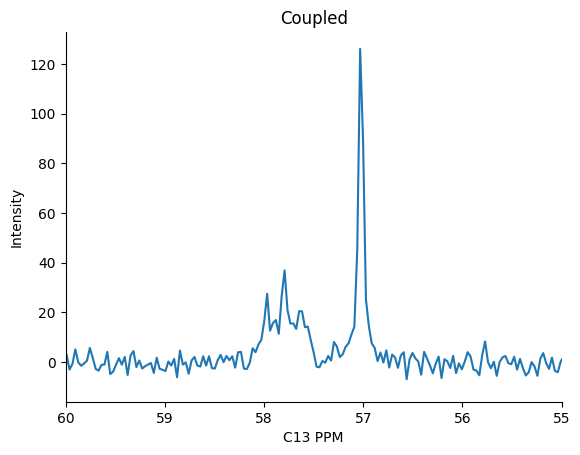

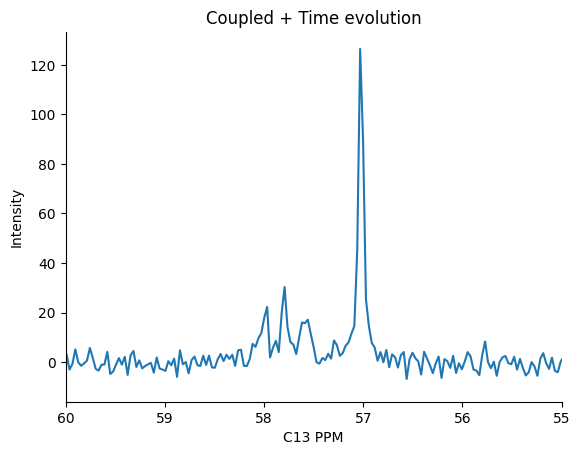

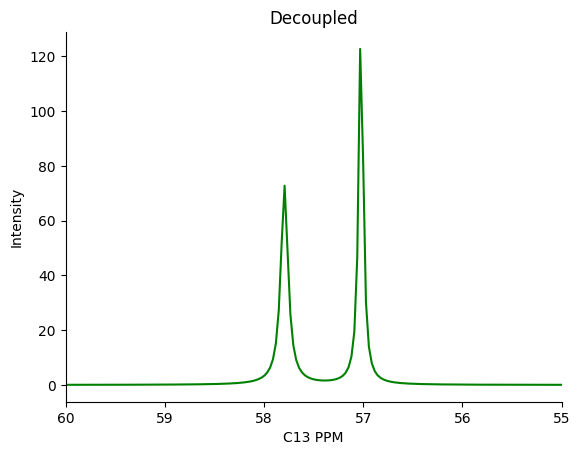


********************************************************************************

EXAMPLE: 2


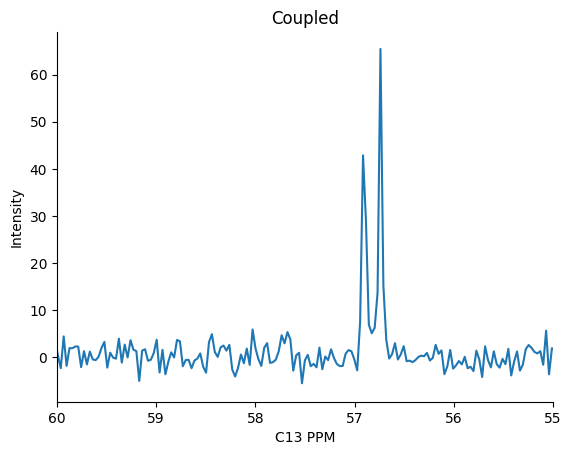

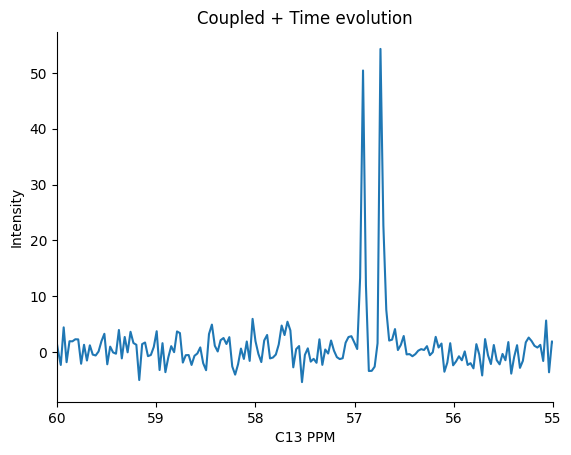

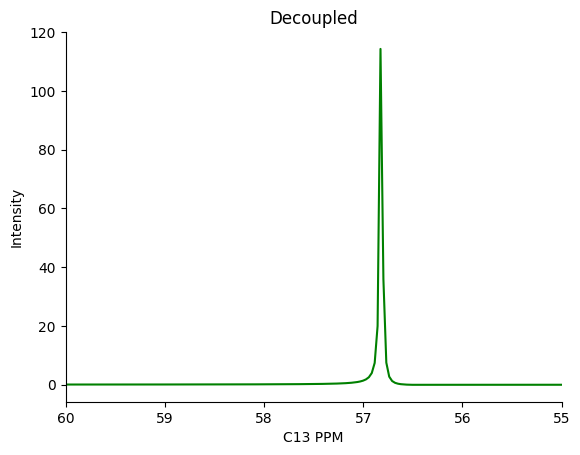


********************************************************************************

EXAMPLE: 3


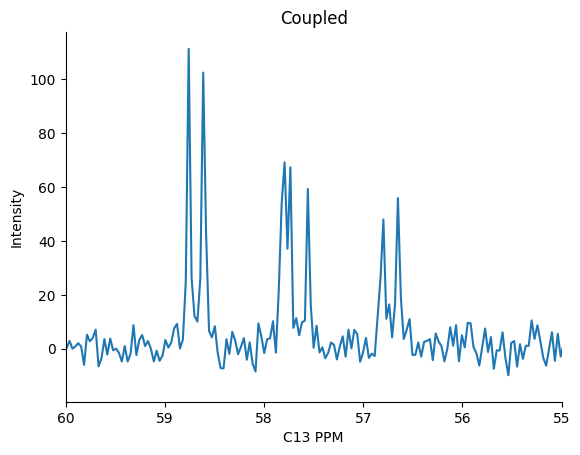

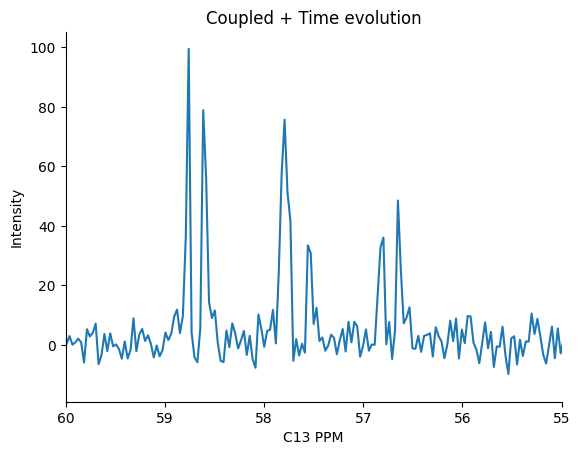

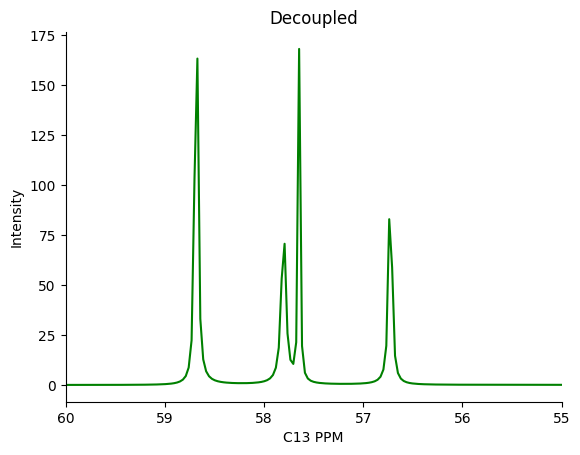


********************************************************************************

EXAMPLE: 4


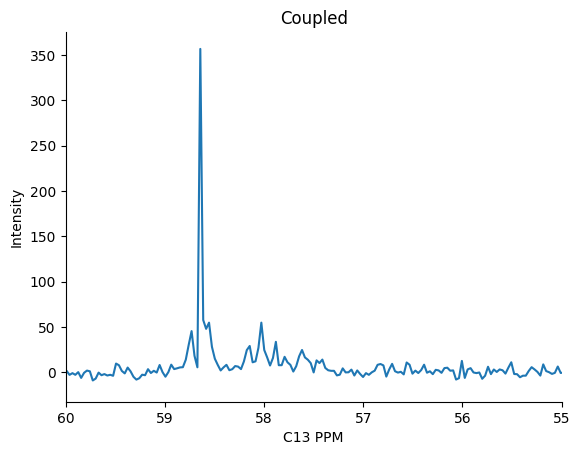

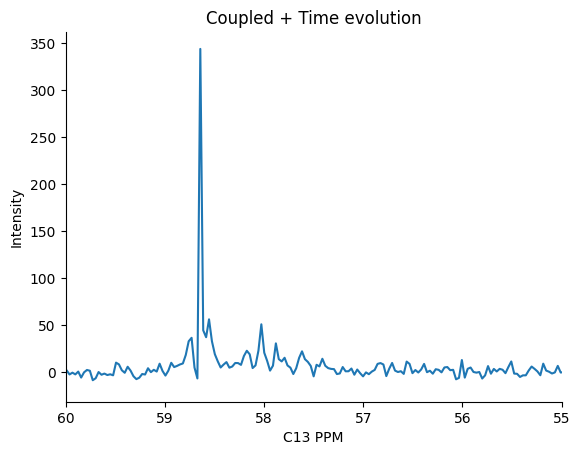

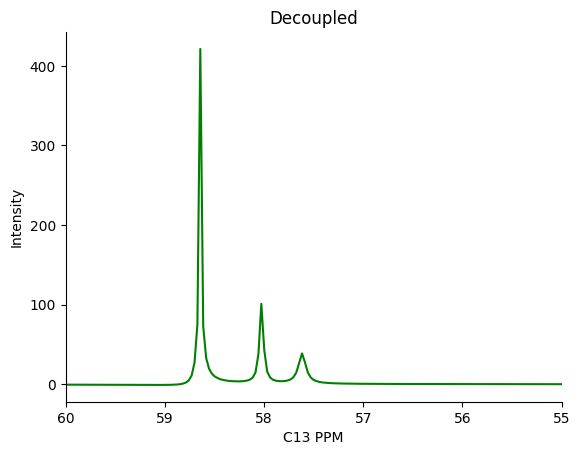


********************************************************************************

EXAMPLE: 5


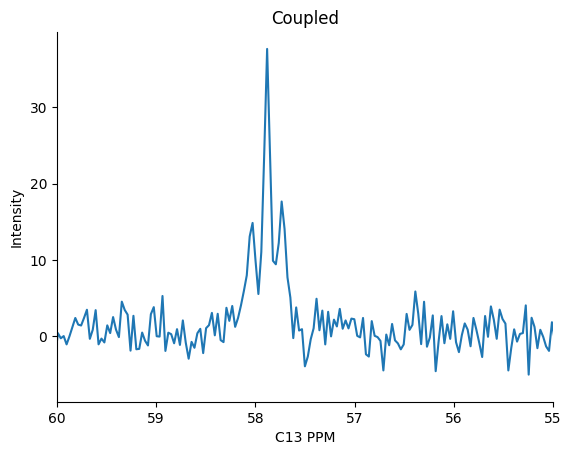

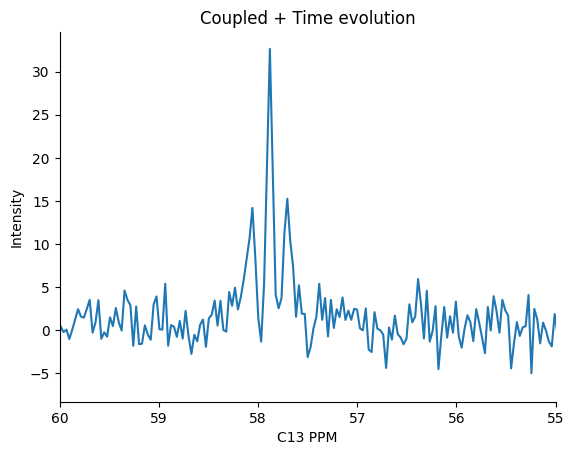

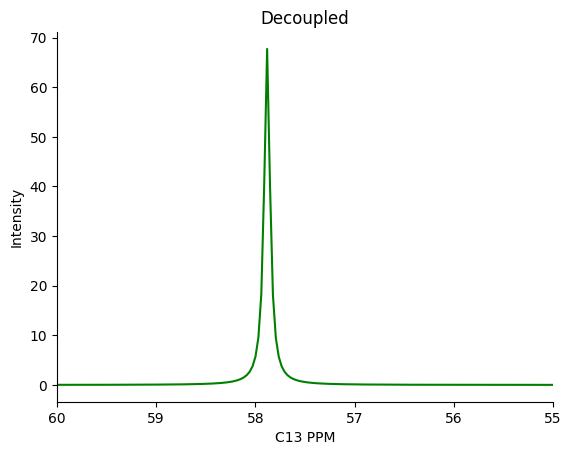


********************************************************************************



In [4]:
spec_gen_examples = int(input("How many examples from the training dataset would you like to see? "))

for i in range(spec_gen_examples):
    spec_number = random.randint(0, number_of_spectra-1)
    
    full_FID = y[spec_number]
    full_coupled_FID = x_coupled[spec_number]
    full_coupled_T_FID = x_coupled_t[spec_number]
    
    spectrum = fftshift(fft(full_FID))
    spectrum2 = fftshift(fft(full_coupled_FID))
    spectrum3 = fftshift(fft(full_coupled_T_FID))
    
    x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
    ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
    ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

    print("EXAMPLE: " + str(i+1))
    plt.plot(ppm, spectrum2)
    plt.xlabel("C13 PPM")
    plt.ylabel("Intensity")
    plt.title("Coupled")
    plt.xlim(55, 60)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()

    plt.plot(ppm, spectrum3)
    plt.xlabel("C13 PPM")
    plt.ylabel("Intensity")
    plt.title("Coupled + Time evolution")
    plt.xlim(55, 60)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()

    plt.plot(ppm, spectrum, color="green")
    plt.xlabel("C13 PPM")
    plt.ylabel("Intensity")
    plt.title("Decoupled")
    plt.xlim(55, 60)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()

    print("")
    print("********************************************************************************")
    print("")

#### One of the benefits of decoupling is easier peak detection due to an increased signal to noise ratio, as shown below:

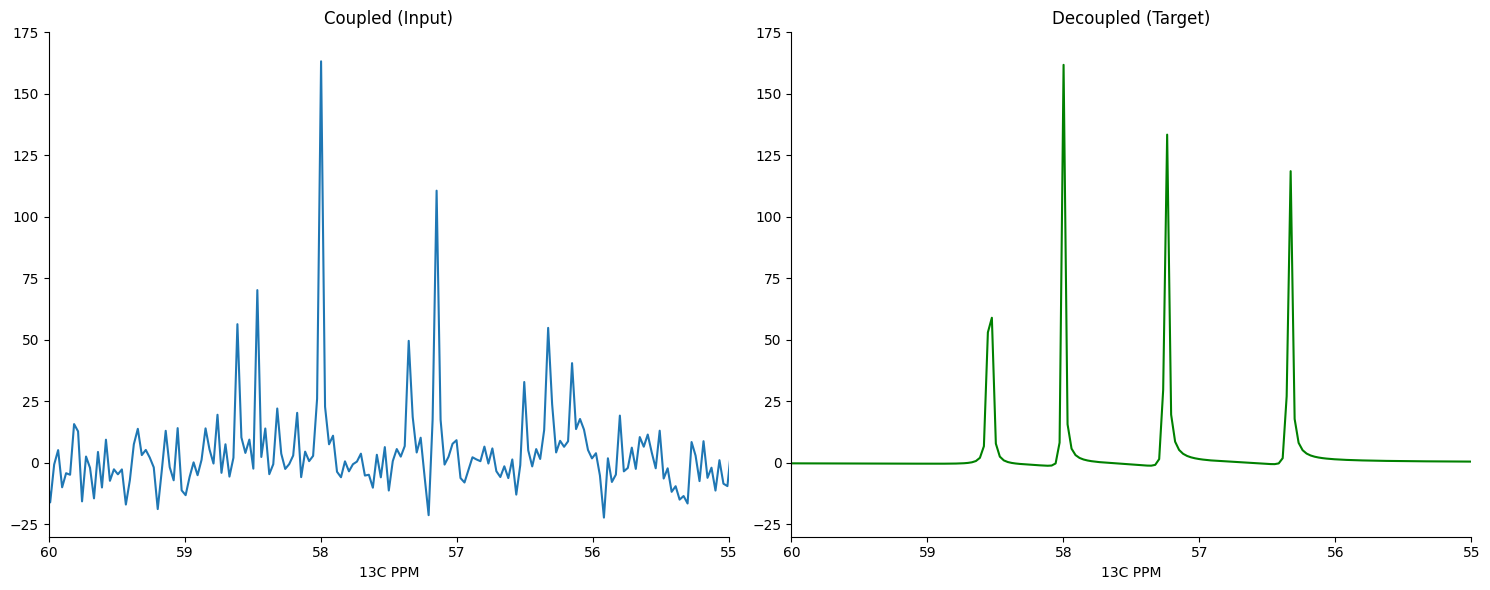

In [5]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        peak_list =          [-1457, -318, 629, 1304] #omega values in Hz
        J_list =             [35, 38, 0, 29] #J values in Hz
        couple_degree_list = [2, 1, 0, 3]
        A_list =             [0.8, 0.9, 0.7, 0.7]
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = len(peak_list)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = peak_list[i]
            t = np.linspace(0, self.duration, self.points)
            A = A_list[i]
            R2 = 10
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = couple_degree_list[i]
            J = J_list[i]
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            np.random.seed(23)
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_FID_noisy = full_FID + noise
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_full_FID_noisy = full_FID_noisy
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei


m = gen_FID()
full_FID = m.out_full_FID
full_coupled_FID = m.out_coupled_FID
full_coupled_T_FID = m.out_coupled_T_FID
full_noisy_FID = m.out_full_FID_noisy

spectrum = fftshift(fft(full_FID))
spectrum2 = fftshift(fft(full_coupled_FID))
spectrum3 = fftshift(fft(full_coupled_T_FID))
spectrum4 = fftshift(fft(full_noisy_FID))
x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(np.real(ppm), np.real(spectrum2))
axs[0].set_title("Coupled (Input)")
axs[0].set_xlabel("13C PPM")
axs[0].set_ylim(-30, 175)
axs[0].set_xlim(55, 60)
axs[0].invert_xaxis()
axs[0].spines["top"].set_visible(False)   
axs[0].spines["right"].set_visible(False)
axs[1].plot(np.real(ppm), np.real(spectrum), color="green")
axs[1].set_title("Decoupled (Target)")
axs[1].set_xlabel("13C PPM")
axs[1].set_ylim(-30, 175)
axs[1].set_xlim(55, 60)
axs[1].invert_xaxis()
axs[1].spines["top"].set_visible(False)   
axs[1].spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
print("")
print("")

<a id="d_train"></a>
### Basic feed forward network for virtual decoupling
---
The first implementation of deep learning for virtual decoupling in this investigation was a simple feed forward network made up of dense, fully-connected layers. This network will be referred to as 1D Train throughout this lab book. 

The code for the network is below. When the code is run, the model will begin training on the dataset generated above. 

Training model:

Number of parameters: 7347200
Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.1556 - rmsd: 0.3916 - val_loss: 0.1229 - val_rmsd: 0.3485 - learning_rate: 0.0010
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.1176 - rmsd: 0.3410 - val_loss: 0.1180 - val_rmsd: 0.3417 - learning_rate: 0.0010
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.1069 - rmsd: 0.3253 - val_loss: 0.1127 - val_rmsd: 0.3338 - learning_rate: 0.0010
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.0971 - rmsd: 0.3097 - val_loss: 0.1061 - val_rmsd: 0.3235 - learning_rate: 0.0010
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0904 - rmsd: 0.2992 - val_loss: 0.1059 - val_rmsd: 0.3235 - learning_rate: 0.0010
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0828 - rmsd: 0.2866 - val_loss: 0.1004 - val_rmsd: 0.3148 - learning_rate: 0.0010
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0768 - rmsd: 

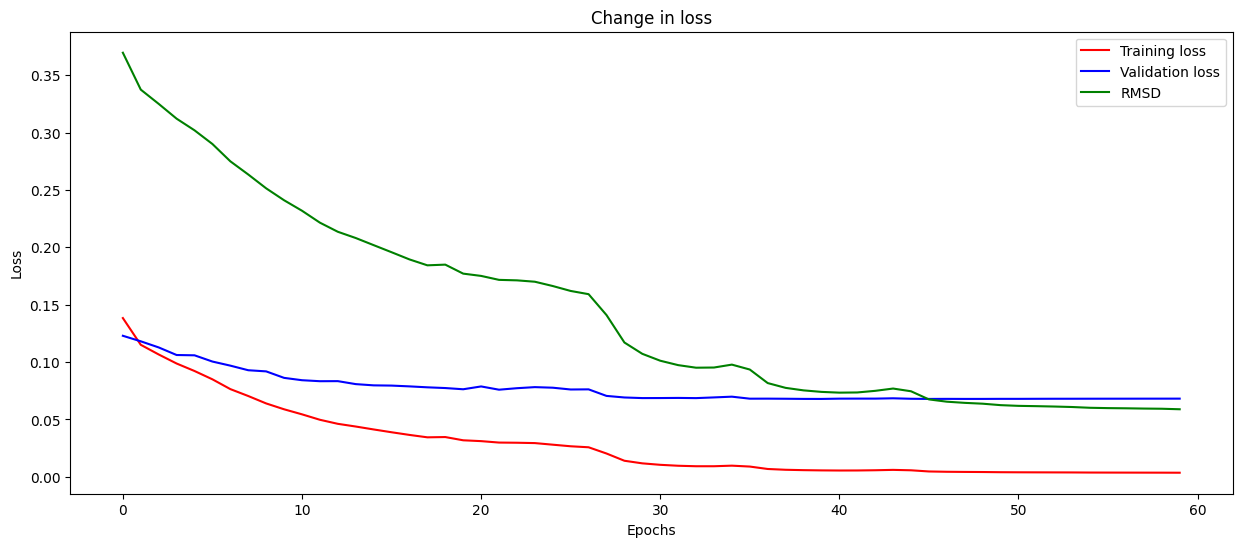

Final Loss: 0.06784

Change in loss: 0.05503

Loss decrease: 44.78955%

Final RMSD: 0.25837



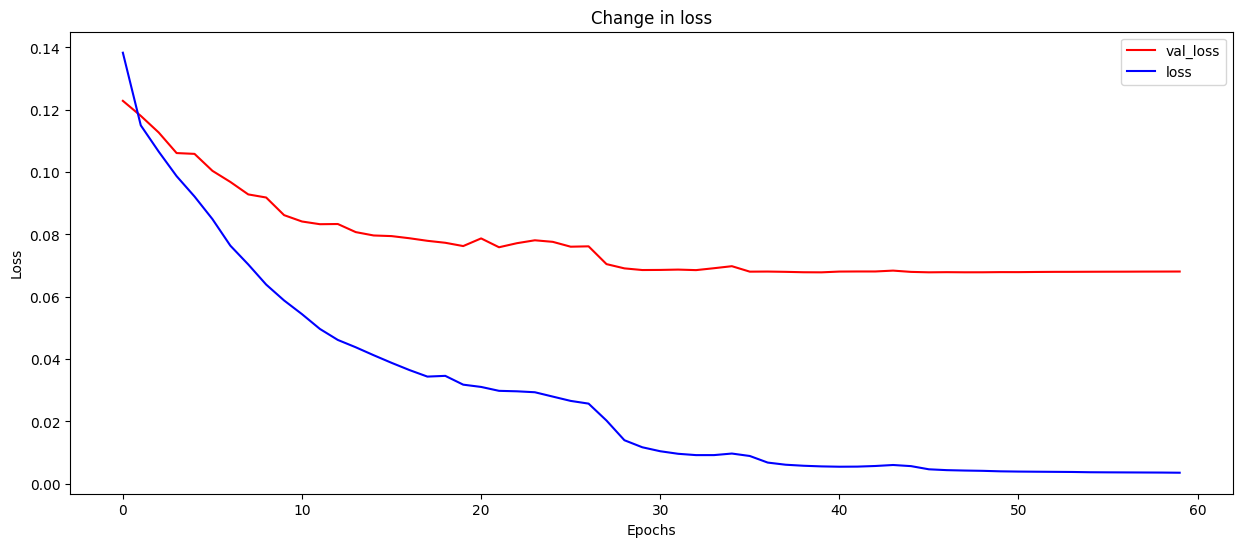

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,041,602 (84.08 MB)

 Trainable params: 7,347,200 (28.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,694,402 (56.05 MB)

In [6]:
from tensorflow.keras.layers import Dense, Input, Concatenate, Conv1D, Reshape
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import tensorflow.keras.backend as K

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

x_input = x_input.reshape(-1, int(minuk_gen_FID.points*2))
x_input_t = x_input_t.reshape(-1, int(minuk_gen_FID.points*2))
y_output = y_output.reshape(-1, int(minuk_gen_FID.points*2))

print("Training model:")
print("")

#Model architecture:
layer_size = 1024

input_layer_x = Input(shape=(x_input.shape[1],))

x_branch = Dense(layer_size, activation="relu")(input_layer_x)
hidden1 = Dense(layer_size, activation="relu")(x_branch)
hidden2 = Dense(layer_size, activation="relu")(hidden1)
hidden3 = Dense(layer_size, activation="relu")(hidden2)
hidden4 = Dense(layer_size, activation="relu")(hidden3)
hidden5 = Dense(layer_size, activation="relu")(hidden4)
output_layer = Dense(1024)(hidden5)
#Model architecture^

model = Model(inputs=[input_layer_x], outputs=output_layer)
model.compile(optimizer=Adam(), loss="mse", metrics=[rmsd])
print("Number of parameters: " + str(model.count_params()))

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1) #Slows the learning rate when the decrease in loss slows down
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1) #Stops training when convergence is reached.

start_time = time.time()
history = model.fit(
    [x_input], 
    y_output, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[lr_scheduler, early_stopping])
end_time = time.time()

print("")
print("**************************************************************")
print("Training complete")
training_time = end_time - start_time
print("Training time: " + str(round(training_time, 2)) + " seconds")
print("")

loss_history = history.history["loss"]
log_loss = np.log(loss_history)
min_loss = min(loss_history)
rmsd_history = history.history["rmsd"]
min_rmsd = min(rmsd_history)
print("Final training loss: " + str(round(min_loss, 5)))
print("")
print("Change in training loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
val_loss_history = history.history["val_loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="Training loss")
plt.plot(val_loss_history, color="blue", label="Validation loss")
plt.plot(rmsd_history, color="green", label="RMSD")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()
loss_history = history.history["val_loss"]
min_loss = min(loss_history)
log_loss = np.log(loss_history)
rmsd_history = history.history["val_rmsd"]
min_rmsd = min(rmsd_history)
print("Final Loss: " + str(round(min_loss, 5)))
print("")
print("Change in loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
loss_loss = history.history["loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="val_loss")
plt.plot(loss_loss, color="blue", label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()


print("")
print("")
model.summary()
print("")
print("")

This neural network achieved an average validation MSE loss of 0.06862 when trained on 5 different datasets of 10,000 examples, more detail in the [Results section.](#res_exp_time_evolved) However sometimes the network struggled to discern 2 proximal singlets from a true doublet as shown in the code block below.

The code block below loads a pretrained model that has the same architecture as the model above and was trained on 10,000 examples. 

**NB:** The plots below will show an x-axis that is limited from ±0.8ppm from the height of the biggest peak to maximise clarity as one cannot zoom into a plot generated in a Jupyter notebook. If any of the DecoupleNET or prediction scripts: `DecoupleNET_1D_Train.py`, `DecoupleNET.py`, `DecoupleNET_conv.py`, `21.specific_parameter_predictions.py`, `22.random_parameter_predictions.py`, or `23.high_accuracy_predictions.py` are run in an environment that has all the relevant libraries installed correctly, as detailed in the [Setup section](#setup), all the plots generated will show the full sweep width of 3000Hz / 15ppm (50 - 65ppm).

`21.specific_parameter_predictions.py` will allow one to load the exact same input into any of the 3 models described in this notebook.


Loading model: saved_model/DecoupleNET_1D_10k.keras




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,041,602 (84.08 MB)

 Trainable params: 7,347,200 (28.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,694,402 (56.05 MB)




*************************** Verification example ***************************
Number of nuclei / peaks: 2
J: 0
A: 1
Omega: 1100
Coupling degree: 0


INPUT: 
Peak PPM: 58.37890625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
PREDICTION: 
Peak PPM: 58.37890625
Difference between peaks: 0.0


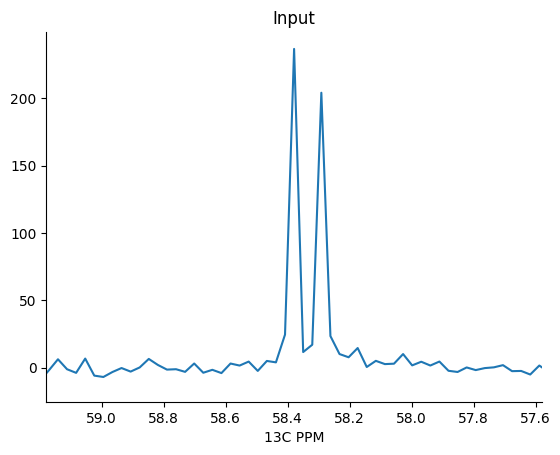

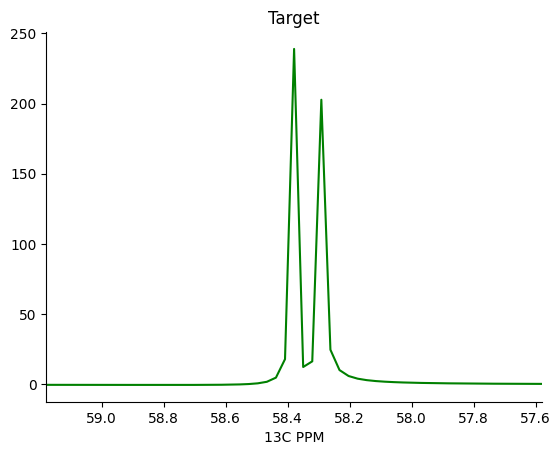

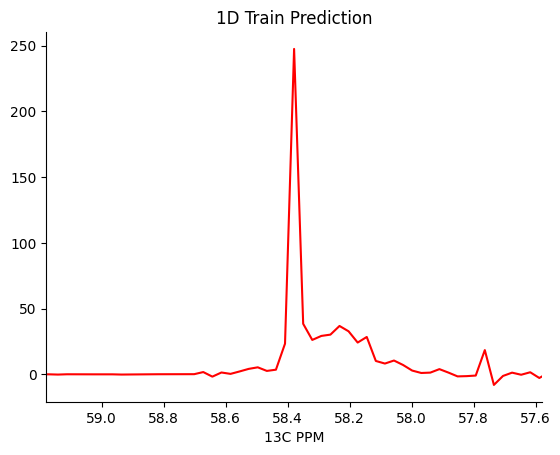

In [7]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        peak_list =          [1000, 1100] #omega values in Hz
        J_list =             [0, 0] #J values in Hz
        couple_degree_list = [0, 0]
        A_list =             [1, 1]
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = len(peak_list)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = peak_list[i]
            t = np.linspace(0, self.duration, self.points)
            A = A_list[i]
            R2 = 10
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = couple_degree_list[i]
            J = J_list[i]
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            np.random.seed(23)
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_FID_noisy = full_FID + noise
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_full_FID_noisy = full_FID_noisy
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

#Function to convert an array in the form [R1, R2, R3, I1, I2, I3] to [R1+I1, R2+I2, R3+I3]
def output_parse(array):
    final_prediction = []
    transpose = int(len(array)/2)
    for i in range(transpose):
        real = array[i]
        imag = array[i+transpose]
        add = complex(real, imag)
        final_prediction.append(add)
    return final_prediction

def gen_FID():
    return minuk_gen_FID()

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

pre_trained_model = "saved_model/DecoupleNET_1D_10k.keras"

print("")
print("Loading model: " + str(pre_trained_model))
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

print("")
print("")
model.summary()
print("")
print("")

#Verification
def verify():
    print("")
    print("*************************** Verification example ***************************")
    m = gen_FID()
    full_FID = m.out_full_FID
    full_coupled_FID = m.out_coupled_FID
    full_coupled_T_FID = m.out_coupled_T_FID
    full_noisy_FID = m.out_full_FID_noisy
    
    spectrum = fftshift(fft(full_FID))
    spectrum2 = fftshift(fft(full_coupled_FID))
    spectrum3 = fftshift(fft(full_coupled_T_FID))
    spectrum4 = fftshift(fft(full_noisy_FID))
    x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
    ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
    ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

    verify_no_nuclei = m.out_no_nuclei
    verify_J = m.out_J
    verify_A = m.out_A
    verify_omega = m.out_omega
    verify_coupling_degree = m.out_couple_degree
    
    print("Number of nuclei / peaks: " + str(verify_no_nuclei))
    print("J: " + str(verify_J))
    print("A: " + str(verify_A))
    print("Omega: " + str(verify_omega))
    print("Coupling degree: " + str(verify_coupling_degree))
    print("")
    print("")
    print("INPUT: ")
    print("Peak PPM: " + str(ppm[spectrum.argmax()]))

    model_input = []
    for j in range(len(full_coupled_FID)):
        model_input.append(full_coupled_FID[j].real)
    for k in range((len(full_coupled_FID))):
        model_input.append(full_coupled_FID[k].imag)
    model_input = np.array(model_input)
    model_input = model_input.reshape(1, -1)
    prediction = model.predict([model_input])
    output = []
    for n in range(len(prediction[0])):
        output.append(prediction[0][n])
    final_output = output_parse(output)
    final_spectrum = fftshift(fft(final_output))

    print("PREDICTION: ")
    print("Peak PPM: "  + str(ppm[final_spectrum.argmax()]))
    print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))
    
    plt.plot(np.real(ppm), np.real(spectrum2))
    plt.title("Input")
    plt.xlabel("13C PPM")
    plt.xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()
    print("")
    print("")
    plt.plot(np.real(ppm), np.real(spectrum), color="green")
    plt.title("Target")
    plt.xlabel("13C PPM")
    plt.xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()
    print("")
    print("")
    plt.plot(np.real(ppm), np.real(final_spectrum), color="red")
    plt.title("1D Train Prediction")
    plt.xlabel("13C PPM")
    plt.xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()
    print("")
    print("")

verify()

<a id="time_evolved"></a>
### Time evolved feed forward neural network for virtual decoupling
---

With direction from my team and having read the [FID-Net paper](https://link.springer.com/article/10.1007/s10858-021-00366-w), I decided to incorporate time evolved input spectra to my feed forward network. This involved adding a second input layer, allowing the network to learn the relationship between 2 input spectra and their corresponding output spectrum. 

This helps the network differentiate between 2 proximal singlets and a true doublet, addressing the problem above. This is because a true doublet will evolve and change over time, whereas 2 proximal singlets will remain unchanged.

This effect is demonstrated below:


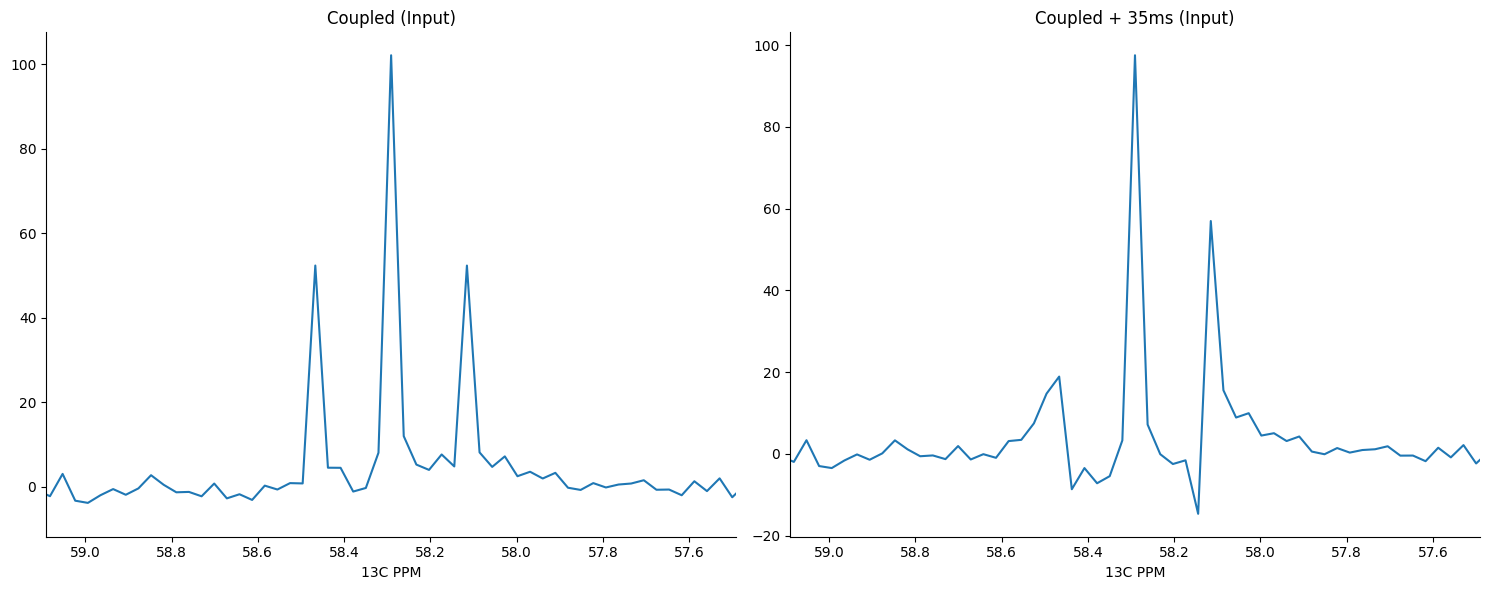

In [8]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        peak_list =          [1000] #omega values in Hz
        J_list =             [35] #J values in Hz
        couple_degree_list = [2]
        A_list =             [1]
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = len(peak_list)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = peak_list[i]
            t = np.linspace(0, self.duration, self.points)
            A = A_list[i]
            R2 = 10
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = couple_degree_list[i]
            J = J_list[i]
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            np.random.seed(23)
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_FID_noisy = full_FID + noise
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_full_FID_noisy = full_FID_noisy
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei


m = gen_FID()
full_FID = m.out_full_FID
full_coupled_FID = m.out_coupled_FID
full_coupled_T_FID = m.out_coupled_T_FID
full_noisy_FID = m.out_full_FID_noisy

spectrum = fftshift(fft(full_FID))
spectrum2 = fftshift(fft(full_coupled_FID))
spectrum3 = fftshift(fft(full_coupled_T_FID))
spectrum4 = fftshift(fft(full_noisy_FID))
x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(np.real(ppm), np.real(spectrum2))
axs[0].set_title("Coupled (Input)")
axs[0].set_xlabel("13C PPM")
axs[0].set_xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
axs[0].invert_xaxis()
axs[0].spines["top"].set_visible(False)   
axs[0].spines["right"].set_visible(False)
axs[1].plot(np.real(ppm), np.real(spectrum3))
axs[1].set_title("Coupled + 35ms (Input)")
axs[1].set_xlabel("13C PPM")
axs[1].set_xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
axs[1].invert_xaxis()
axs[1].spines["top"].set_visible(False)   
axs[1].spines["right"].set_visible(False)
plt.tight_layout()
plt.show()
print("")
print("")

Below is a simple feed forward network with 2 input layers, which allow the network to learn the relationship between pairs of spectra, and their corresponding decoupled spectrum. This neural network achieved an average validation MSE loss of 0.05022, when trained on the same 5 datasets as the neural network with 1 input layer. More details in the [Results section.](#res_exp_time_evolved)

**This network architecture, with 2 input layers, and dense hidden layers will be referred to as DecoupleNET.**

Number of parameters: 7346176
Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.1502 - rmsd: 0.3846 - val_loss: 0.1151 - val_rmsd: 0.3376 - learning_rate: 0.0010
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.1005 - rmsd: 0.3156 - val_loss: 0.0991 - val_rmsd: 0.3128 - learning_rate: 0.0010
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0796 - rmsd: 0.2809 - val_loss: 0.0873 - val_rmsd: 0.2934 - learning_rate: 0.0010
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0643 - rmsd: 0.2522 - val_loss: 0.0786 - val_rmsd: 0.2788 - learning_rate: 0.0010
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0541 - rmsd: 0.2313 - val_loss: 0.0739 - val_rmsd: 0.2700 - learning_rate: 0.0010
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0480 - rmsd: 0.2173 - val_loss: 0.0725 - val_rmsd: 0.2671 - learning_rate: 0.0010
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0432 - rmsd: 0.2063 - val_loss

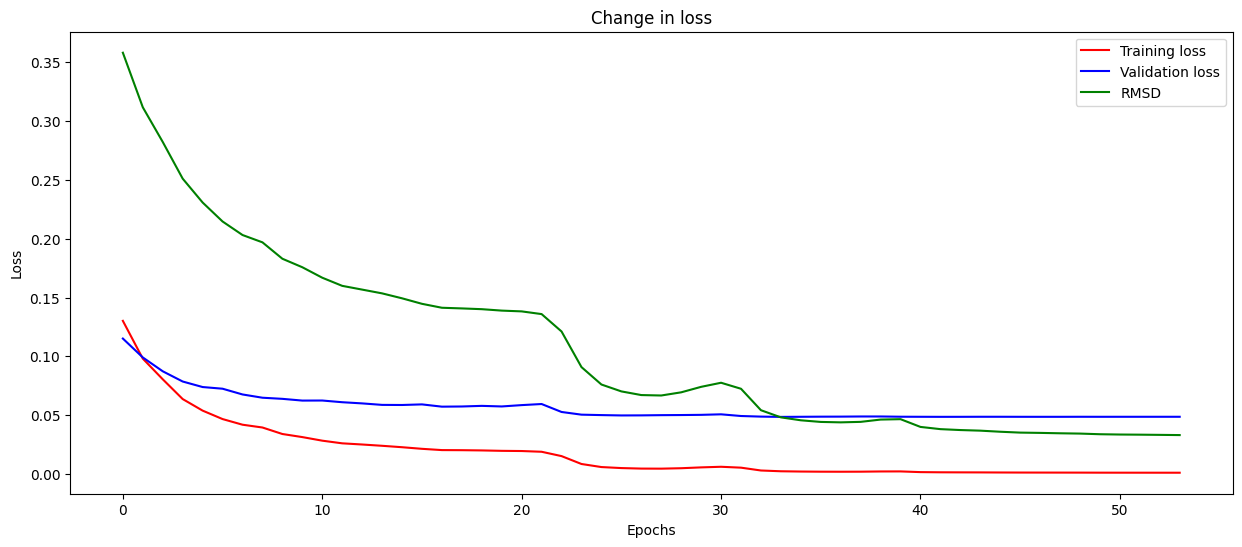

Final Loss: 0.04855

Change in loss: 0.06657

Loss decrease: 57.82735%

Final RMSD: 0.21832



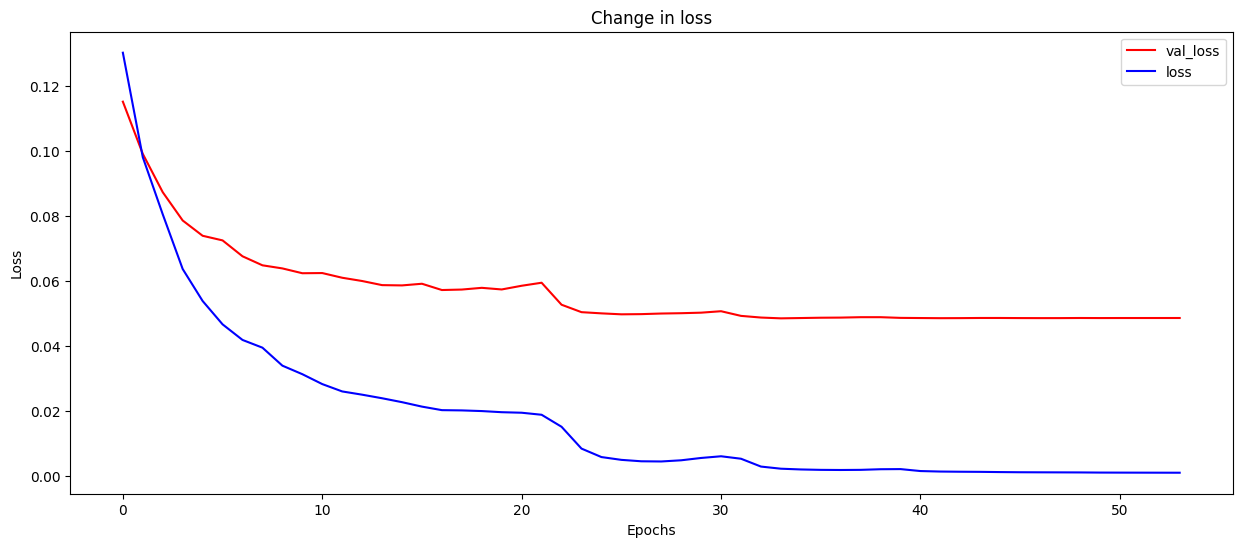

In [9]:
x_input = x_input.reshape(-1, int(minuk_gen_FID.points*2))
x_input_t = x_input_t.reshape(-1, int(minuk_gen_FID.points*2))
y_output = y_output.reshape(-1, int(minuk_gen_FID.points*2))

#Model architecture:
layer_size = 1024

input_layer_x = Input(shape=(x_input.shape[1],))
input_layer_x_t = Input(shape=(x_input_t.shape[1],))

x_branch = Dense(layer_size, activation="relu")(input_layer_x)
t_branch = Dense(layer_size, activation="relu")(input_layer_x_t)

combiner = Concatenate()([x_branch, t_branch])

hidden1 = Dense(layer_size, activation="relu")(combiner)
hidden2 = Dense(layer_size, activation="relu")(hidden1)
hidden3 = Dense(layer_size, activation="relu")(hidden2)

output_layer = Dense(1024)(hidden3)
#Model architecture^

model = Model(inputs=[input_layer_x, input_layer_x_t], outputs=output_layer)
model.compile(optimizer=Adam(), loss="mse", metrics=[rmsd])
print("Number of parameters: " + str(model.count_params()))

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1) #Slows the learning rate when the decrease in loss slows down
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1) #Stops training when convergence is reached.

start_time = time.time()
history = model.fit(
    [x_input, x_input_t], 
    y_output, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[lr_scheduler, early_stopping])
end_time = time.time()

print("")
print("**************************************************************")
print("Training complete")
training_time = end_time - start_time
print("Training time: " + str(round(training_time, 2)) + " seconds")
print("")

loss_history = history.history["loss"]
log_loss = np.log(loss_history)
min_loss = min(loss_history)
rmsd_history = history.history["rmsd"]
min_rmsd = min(rmsd_history)
print("Final training loss: " + str(round(min_loss, 5)))
print("")
print("Change in training loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
val_loss_history = history.history["val_loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="Training loss")
plt.plot(val_loss_history, color="blue", label="Validation loss")
plt.plot(rmsd_history, color="green", label="RMSD")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()
loss_history = history.history["val_loss"]
min_loss = min(loss_history)
log_loss = np.log(loss_history)
rmsd_history = history.history["val_rmsd"]
min_rmsd = min(rmsd_history)
print("Final Loss: " + str(round(min_loss, 5)))
print("")
print("Change in loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
loss_loss = history.history["loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="val_loss")
plt.plot(loss_loss, color="blue", label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()

<a id="opti"></a>
### Optimisation of the feed forward network
---

I tested various versions of DecoupleNET, but varying the number of hidden layers and neurons in each hidden layer. I determined that 2 layers of 1024 neurons resulted in the lowest validation MSE loss of 0.04876. This is 2.91% better than the previous validation MSE loss of 0.05022. This model has 6,296,576 parameters which is 14.29% smaller than the previous version with 7,346,176 parameters. All of the data can be found in the [Results section.](#res_depth)

The optimised network architecture can be found below:

Training model:

Number of parameters: 6296576
Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 0.1502 - rmsd: 0.3840 - val_loss: 0.1036 - val_rmsd: 0.3202 - learning_rate: 0.0010
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0899 - rmsd: 0.2983 - val_loss: 0.0893 - val_rmsd: 0.2973 - learning_rate: 0.0010
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0645 - rmsd: 0.2527 - val_loss: 0.0810 - val_rmsd: 0.2830 - learning_rate: 0.0010
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0529 - rmsd: 0.2288 - val_loss: 0.0713 - val_rmsd: 0.2651 - learning_rate: 0.0010
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0438 - rmsd: 0.2081 - val_loss: 0.0662 - val_rmsd: 0.2555 - learning_rate: 0.0010
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0388 - rmsd: 0.1952 - val_loss: 0.0647 - val_rmsd: 0.2529 - learning_rate: 0.0010
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0380 - rmsd: 

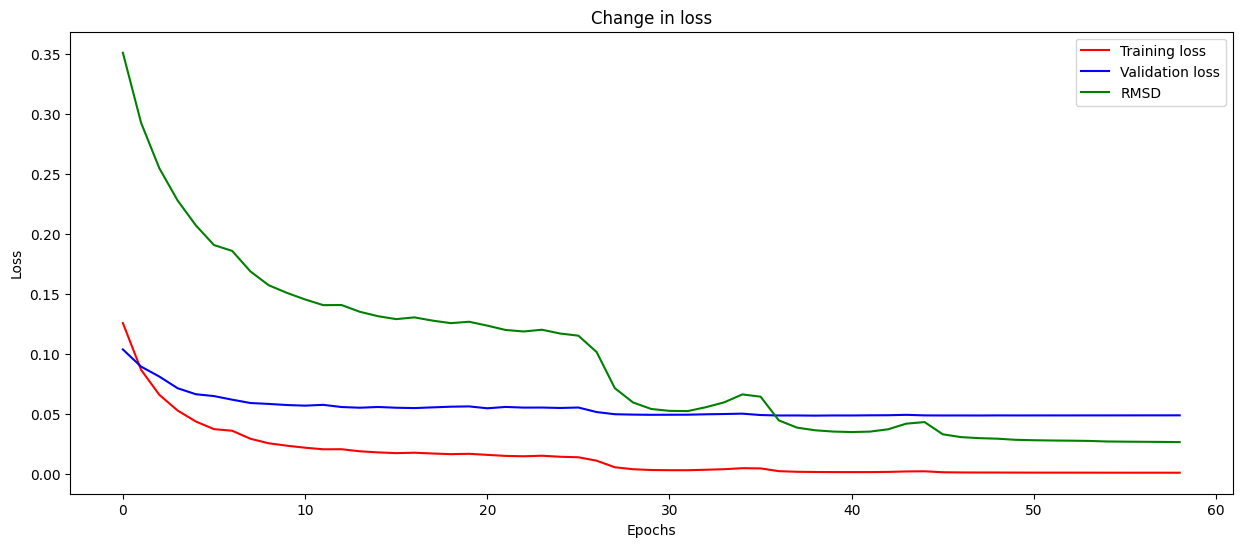

Final Loss: 0.04837

Change in loss: 0.05525

Loss decrease: 53.31972%

Final RMSD: 0.21835



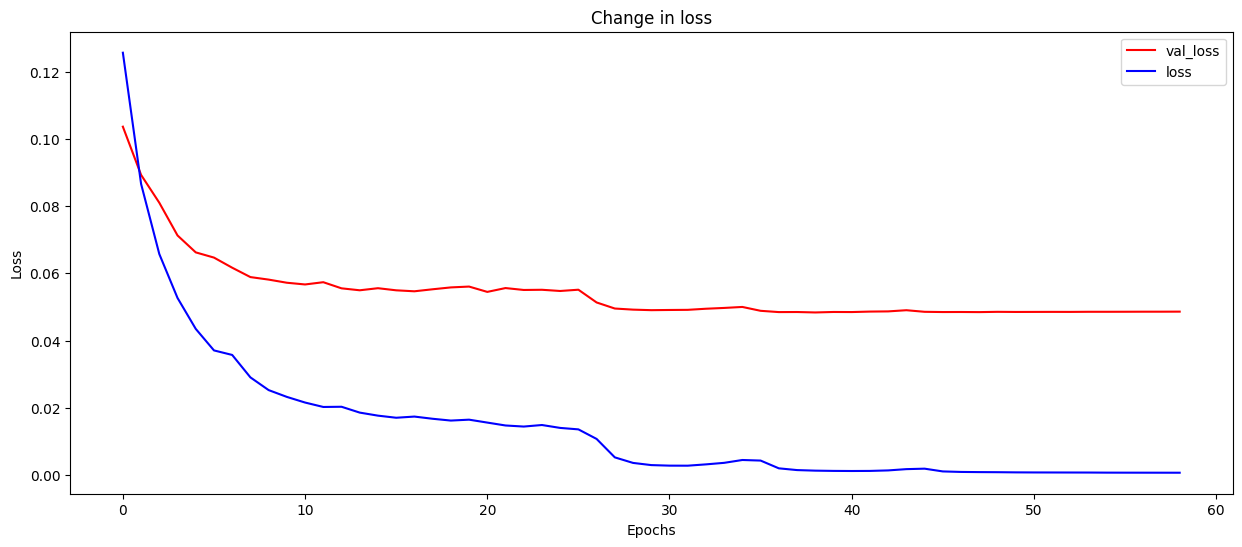

In [10]:
x_input = x_input.reshape(-1, int(minuk_gen_FID.points*2))
x_input_t = x_input_t.reshape(-1, int(minuk_gen_FID.points*2))
y_output = y_output.reshape(-1, int(minuk_gen_FID.points*2))

print("Training model:")
print("")

#Model architecture:
layer_size = 1024

input_layer_x = Input(shape=(x_input.shape[1],))
input_layer_x_t = Input(shape=(x_input_t.shape[1],))

x_branch = Dense(layer_size, activation="relu")(input_layer_x)
t_branch = Dense(layer_size, activation="relu")(input_layer_x_t)

combiner = Concatenate()([x_branch, t_branch])

hidden1 = Dense(layer_size, activation="relu")(combiner)
hidden2 = Dense(layer_size, activation="relu")(hidden1)

output_layer = Dense(1024)(hidden2)
#Model architecture^

model = Model(inputs=[input_layer_x, input_layer_x_t], outputs=output_layer)
model.compile(optimizer=Adam(), loss="mse", metrics=[rmsd])
print("Number of parameters: " + str(model.count_params()))

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1) #Slows the learning rate when the decrease in loss slows down
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1) #Stops training when convergence is reached.

start_time = time.time()
history = model.fit(
    [x_input, x_input_t], 
    y_output, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[lr_scheduler, early_stopping])
end_time = time.time()

print("")
print("**************************************************************")
print("Training complete")
training_time = end_time - start_time
print("Training time: " + str(round(training_time, 2)) + " seconds")
print("")

loss_history = history.history["loss"]
log_loss = np.log(loss_history)
min_loss = min(loss_history)
rmsd_history = history.history["rmsd"]
min_rmsd = min(rmsd_history)
print("Final training loss: " + str(round(min_loss, 5)))
print("")
print("Change in training loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
val_loss_history = history.history["val_loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="Training loss")
plt.plot(val_loss_history, color="blue", label="Validation loss")
plt.plot(rmsd_history, color="green", label="RMSD")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()
loss_history = history.history["val_loss"]
min_loss = min(loss_history)
log_loss = np.log(loss_history)
rmsd_history = history.history["val_rmsd"]
min_rmsd = min(rmsd_history)
print("Final Loss: " + str(round(min_loss, 5)))
print("")
print("Change in loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
loss_loss = history.history["loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="val_loss")
plt.plot(loss_loss, color="blue", label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()

The code block below loads a pretrained version of DecoupleNET which has been trained on 10,000 examples and is therefore comparable to the simpler model in the [Basic feed forward neural network](#d_train) section. The DecoupleNET model is then given the exact same pair of spectra to virtually decouple. 

**NB:** The plots below will show an x-axis that is limited from ±0.8ppm from the height of the biggest peak to maximise clarity as one cannot zoom into a plot generated in a Jupyter notebook. If any of the DecoupleNET or prediction scripts: `DecoupleNET_1D_Train.py`, `DecoupleNET.py`, `DecoupleNET_conv.py`, `21.specific_parameter_predictions.py`, `22.random_parameter_predictions.py`, or `23.high_accuracy_predictions.py` are run in an environment that has all the relevant libraries installed correctly, as detailed in the [Setup section](#setup), all the plots generated will show the full sweep width of 3000Hz / 15ppm (50 - 65ppm).

`21.specific_parameter_predictions.py` will allow one to load the exact same input into any of the 3 models described in this notebook.


Loading model: saved_model/DecoupleNet_10k.keras




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  1,049,600 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │  1,049,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2048)      │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  2,098,176 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1024)      │  1,049,600 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1024)      │  1,049,600 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,889,730 (72.06 MB)

 Trainable params: 6,296,576 (24.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,593,154 (48.04 MB)




*************************** Verification example ***************************
Number of nuclei / peaks: 2
J: 0
A: 1
Omega: 1100
Coupling degree: 0


INPUT: 
Peak PPM: 58.37890625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
PREDICTION: 
Peak PPM: 58.37890625
Difference between peaks: 0.0


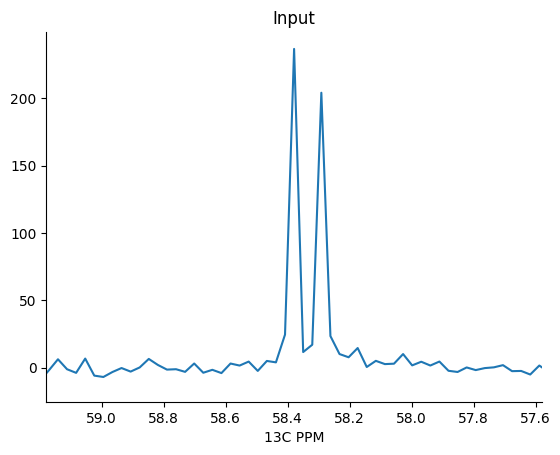

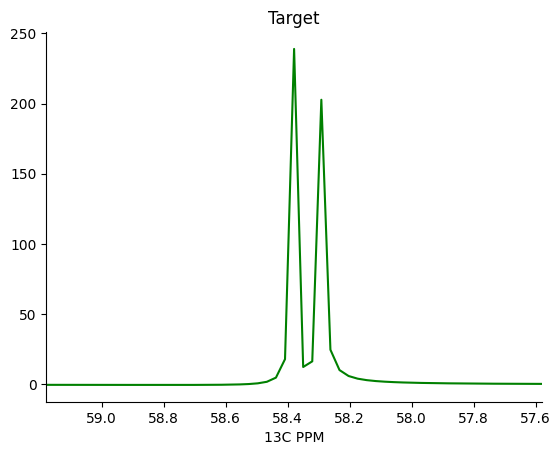

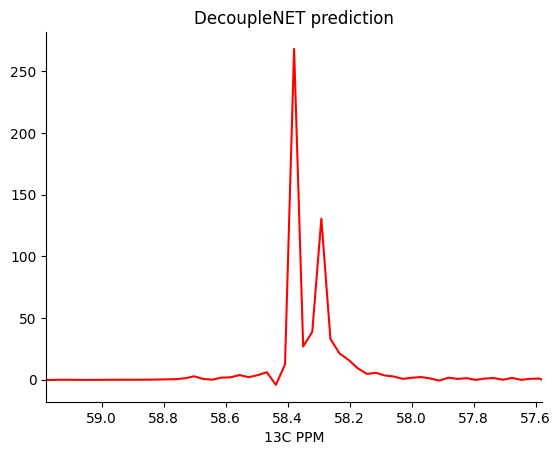

In [11]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        peak_list =          [1000, 1100] #omega values in Hz
        J_list =             [0, 0] #J values in Hz
        couple_degree_list = [0, 0]
        A_list =             [1, 1]
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = len(peak_list)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = peak_list[i]
            t = np.linspace(0, self.duration, self.points)
            A = A_list[i]
            R2 = 10
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = couple_degree_list[i]
            J = J_list[i]
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            np.random.seed(23)
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_FID_noisy = full_FID + noise
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_full_FID_noisy = full_FID_noisy
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

#Function to convert an array in the form [R1, R2, R3, I1, I2, I3] to [R1+I1, R2+I2, R3+I3]
def output_parse(array):
    final_prediction = []
    transpose = int(len(array)/2)
    for i in range(transpose):
        real = array[i]
        imag = array[i+transpose]
        add = complex(real, imag)
        final_prediction.append(add)
    return final_prediction

def gen_FID():
    return minuk_gen_FID()

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

pre_trained_model = "saved_model/DecoupleNet_10k.keras"

print("")
print("Loading model: " + str(pre_trained_model))
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

print("")
print("")
model.summary()
print("")
print("")

#Verification
def verify():
    print("")
    print("*************************** Verification example ***************************")
    m = gen_FID()
    full_FID = m.out_full_FID
    full_coupled_FID = m.out_coupled_FID
    full_coupled_T_FID = m.out_coupled_T_FID
    full_noisy_FID = m.out_full_FID_noisy
    
    spectrum = fftshift(fft(full_FID))
    spectrum2 = fftshift(fft(full_coupled_FID))
    spectrum3 = fftshift(fft(full_coupled_T_FID))
    spectrum4 = fftshift(fft(full_noisy_FID))
    x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
    ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
    ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

    verify_no_nuclei = m.out_no_nuclei
    verify_J = m.out_J
    verify_A = m.out_A
    verify_omega = m.out_omega
    verify_coupling_degree = m.out_couple_degree
    
    print("Number of nuclei / peaks: " + str(verify_no_nuclei))
    print("J: " + str(verify_J))
    print("A: " + str(verify_A))
    print("Omega: " + str(verify_omega))
    print("Coupling degree: " + str(verify_coupling_degree))
    print("")
    print("")
    print("INPUT: ")
    print("Peak PPM: " + str(ppm[spectrum.argmax()]))

    model_input = []
    model_input_t = []
    for j in range(len(full_coupled_FID)):
        model_input.append(full_coupled_FID[j].real)
    for k in range((len(full_coupled_FID))):
        model_input.append(full_coupled_FID[k].imag)
    for l in range((len(full_coupled_T_FID))):
        model_input_t.append(full_coupled_T_FID[l].real)
    for m in range((len(full_coupled_T_FID))):
        model_input_t.append(full_coupled_T_FID[m].imag)
    model_input = np.array(model_input)
    model_input_t = np.array(model_input_t)
    model_input = model_input.reshape(1, -1)
    model_input_t = model_input_t.reshape(1, -1)
    prediction = model.predict([model_input, model_input_t])
    output = []
    for n in range(len(prediction[0])):
        output.append(prediction[0][n])
    final_output = output_parse(output)
    final_spectrum = fftshift(fft(final_output))

    print("PREDICTION: ")
    print("Peak PPM: "  + str(ppm[final_spectrum.argmax()]))
    print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))
    
    plt.plot(np.real(ppm), np.real(spectrum2))
    plt.title("Input")
    plt.xlabel("13C PPM")
    plt.xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()
    print("")
    print("")
    plt.plot(np.real(ppm), np.real(spectrum), color="green")
    plt.title("Target")
    plt.xlabel("13C PPM")
    plt.xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()
    print("")
    print("")
    plt.plot(np.real(ppm), np.real(final_spectrum), color="red")
    plt.title("DecoupleNET prediction")
    plt.xlabel("13C PPM")
    plt.xlim(ppm[spectrum.argmax()]-0.8, ppm[spectrum.argmax()]+0.8)
    ax = plt.gca()  
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.invert_xaxis()
    plt.show()
    print("")
    print("")

verify()

Although one peak is significantly smaller in the predicted spectrum than in the target spectrum, the DecoupleNET prediction maintains the second peak far better than the 1D Train prediction. 

<a id="conv"></a>
### Convolutional neural network for virtual decoupling
---

Many neural networks that are widely used for virtual decoupling utilise convolutional layers instead of dense (fully connected, feed forward) layers. Hence the next architectural feature I investigated was the performance difference between convolutional and dense layers. 

The network below has the same branched structure as the network above, but far fewer parameters. The optimised feed forward network (DecoupleNET) has 6,296,576 parameters and the optimised convolutional network below has 149,442 parameters, which is over 42 times less. The network below will be referred to as DecoupleNET_conv throughout this lab book.

 The CNN below achieved an average validation MSE loss of 0.05813 which is 41.11676% better than the comparable dense network which achieved an average validation MSE loss of 0.09871 on the same 5 datasets. More detail in the [Experiments](#densevsconv) and [Results section.](#res_densevsconv)

Training model:

Number of parameters: 149442
Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - loss: 0.1112 - rmsd: 0.3293 - val_loss: 0.0860 - val_rmsd: 0.2917 - learning_rate: 0.0010
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - loss: 0.0847 - rmsd: 0.2888 - val_loss: 0.0792 - val_rmsd: 0.2799 - learning_rate: 0.0010
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 0.0761 - rmsd: 0.2738 - val_loss: 0.0716 - val_rmsd: 0.2661 - learning_rate: 0.0010
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 0.0692 - rmsd: 0.2606 - val_loss: 0.0680 - val_rmsd: 0.2590 - learning_rate: 0.0010
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 0.0678 - rmsd: 0.2582 - val_loss: 0.0647 - val_rmsd: 0.2526 - learning_rate: 0.0010
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - loss: 0.0655 - rmsd: 0.2541 - val_loss: 0.0635 - val_rmsd: 0.2503 - learning_rate: 0.0010
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - loss: 0.0626 - 

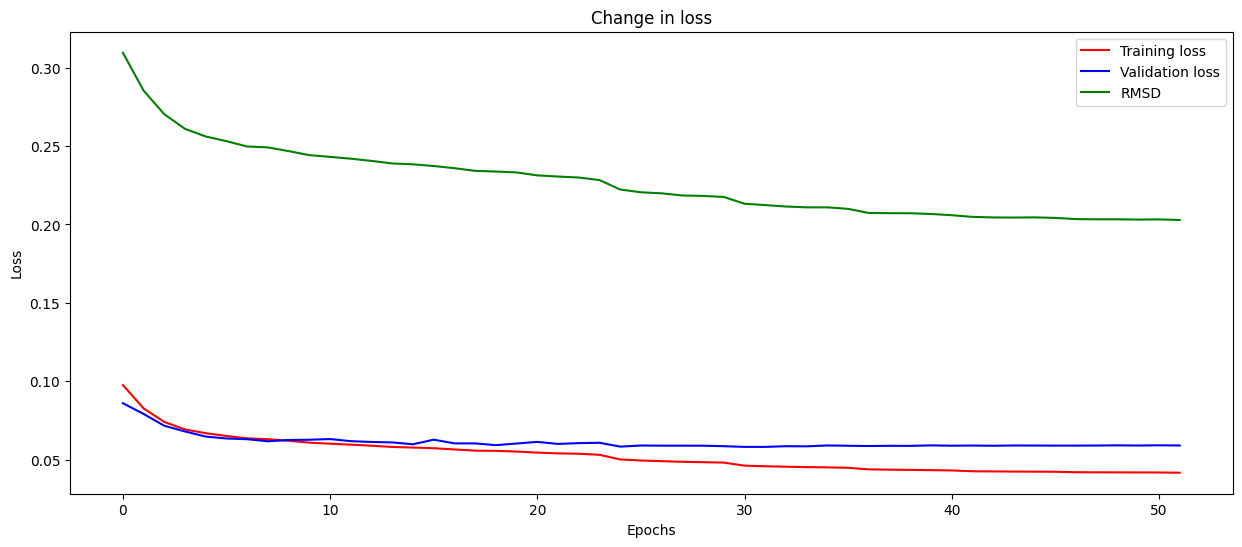

Final Loss: 0.05816

Change in loss: 0.02786

Loss decrease: 32.38897%

Final RMSD: 0.23906



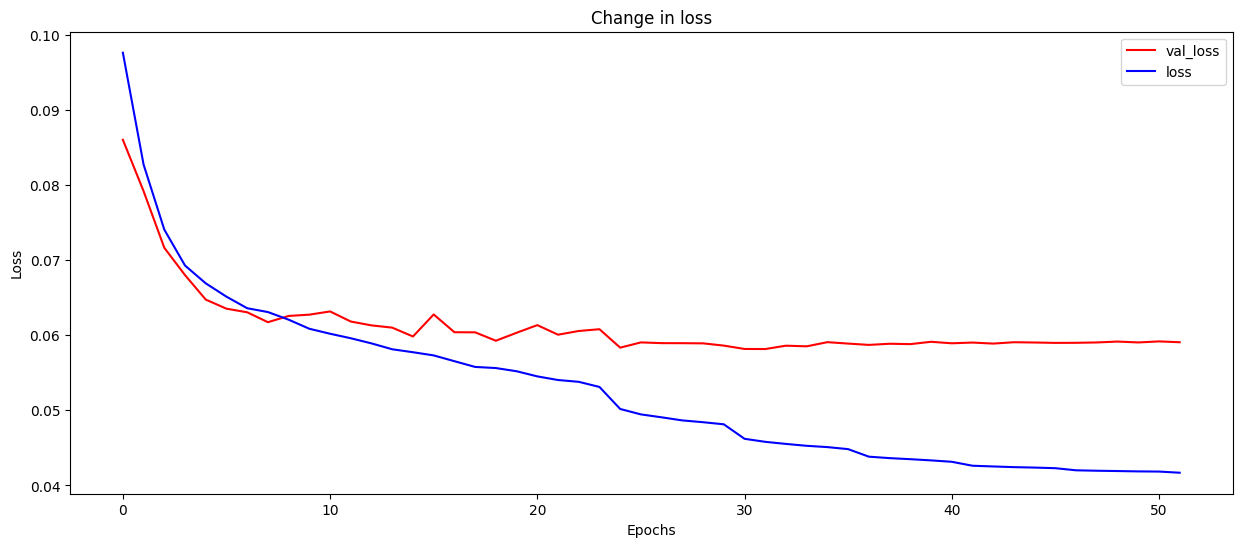

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 512, 2)    │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 512, 2)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 64)   │        320 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 512, 64)   │        320 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 64)   │     32,832 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 64)   │     20,544 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 512, 64)   │     24,640 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 512, 64)   │     28,736 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │     41,024 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 512, 2)    │      1,026 │ conv1d_6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 448,328 (1.71 MB)

 Trainable params: 149,442 (583.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 298,886 (1.14 MB)

In [12]:
print("Training model:")
print("")
x_input = x_input.reshape(-1, int(minuk_gen_FID.points*2))
x_input_t = x_input_t.reshape(-1, int(minuk_gen_FID.points*2))
y_output = y_output.reshape((-1, int(minuk_gen_FID.points), 2)) #Reshaping the list of targets to match the dimensionality of the convolutional neural network

#Model architecture:
filters_number = 64

input_layer_x = Input(shape=(x_input.shape[1],))
input_layer_x_t = Input(shape=(x_input_t.shape[1],))

x_reshape = Reshape((int(minuk_gen_FID.points), 2))(input_layer_x)
x_branch = Conv1D(filters=filters_number, kernel_size=2, activation="relu", padding="same")(x_reshape)

t_reshape = Reshape((int(minuk_gen_FID.points), 2))(input_layer_x_t)
t_branch = Conv1D(filters=filters_number, kernel_size=2, activation="relu", padding="same")(t_reshape)

combiner = Concatenate()([x_branch, t_branch])

hidden1 = Conv1D(filters=filters_number, kernel_size=4, activation="relu", padding="same")(combiner)
hidden2 = Conv1D(filters=filters_number, kernel_size=5, activation="relu", padding="same")(hidden1)
hidden3 = Conv1D(filters=filters_number, kernel_size=6, activation="relu", padding="same")(hidden2)
hidden4 = Conv1D(filters=filters_number, kernel_size=7, activation="relu", padding="same")(hidden3)
hidden5 = Conv1D(filters=filters_number, kernel_size=10, activation="relu", padding="same")(hidden4)
output_layer = Conv1D(filters=2, kernel_size=8, activation="linear", padding="same")(hidden5)
#Model architecture^


model = Model(inputs=[input_layer_x, input_layer_x_t], outputs=output_layer)
model.compile(optimizer=Adam(), loss="mse", metrics=[rmsd])
print("Number of parameters: " + str(model.count_params()))

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1) #Slows the learning rate when the decrease in loss slows down
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1) #Stops training when convergence is reached.

start_time = time.time()
history = model.fit(
    [x_input, x_input_t], 
    y_output, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[lr_scheduler, early_stopping])
end_time = time.time() 

print("")
print("**************************************************************")
print("Training complete")
training_time = end_time - start_time
print("Training time: " + str(round(training_time, 2)) + " seconds")
print("")

loss_history = history.history["loss"]
log_loss = np.log(loss_history)
min_loss = min(loss_history)
rmsd_history = history.history["rmsd"]
min_rmsd = min(rmsd_history)
print("Final training loss: " + str(round(min_loss, 5)))
print("")
print("Change in training loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
val_loss_history = history.history["val_loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="Training loss")
plt.plot(val_loss_history, color="blue", label="Validation loss")
plt.plot(rmsd_history, color="green", label="RMSD")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()
loss_history = history.history["val_loss"]
min_loss = min(loss_history)
log_loss = np.log(loss_history)
rmsd_history = history.history["val_rmsd"]
min_rmsd = min(rmsd_history)
print("Final Loss: " + str(round(min_loss, 5)))
print("")
print("Change in loss: " + str(round(loss_history[0]-min_loss, 5)))
print("")
print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")
print("")
print("Final RMSD: " + str(round(min_rmsd, 5)))
print("")
loss_loss = history.history["loss"]
loss_fig = plt.figure(figsize=(15, 6))
loss_fig.canvas.manager.set_window_title("Change in loss")
plt.plot(loss_history, color="red", label="val_loss")
plt.plot(loss_loss, color="blue", label="loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Change in loss")
plt.show()


print("")
print("")
model.summary()
print("")
print("")

## Experiments

<a id="basic"></a>
### Basic experimental protocol
---

For all experimental data collection I wrote new scripts which had the relevant model architecture, but I had removed the class which was used to generate the training datasets. I also removed the functionality that allowed one to test or save the trained model. All of these scripts can be found in the `experiment_scripts` folder. 

In order to ensure a fair comparison of the networks I generated 5 datasets using the code in the [NMR spectra generation](#spec_gen) section. Once each dataframe was made, I saved it to a .csv file to maintain a static dataset which could be used to train all of the networks. 

I used the line:
`training_df.to_csv("EXPERIMENT_TRAINING_SET_10K_1.csv", index=False)`
to save each dataframe to a .csv file, ensuring each new dataset was saved to a different file ending in a different number. The file `training_csv_gen.py` in the `experiment_scripts` folder can be used to generate new .csv files containing a training dataset.

Once I had made 5 different datasets, stored in 5 different .csv files, I loaded them into each network using the code in the cell below:

NB: During the experiments, files that contained 10,000 training examples were loaded - the cell block below will load a file that contains only 50 examples to ensure a small enough file size that the .csv file can be uploaded to GitHub.

In [13]:
import ast

file_name = "experiment_scripts/EXPERIMENT_TRAINING_SET_TESTER.csv" #Each time I trained a network to test its performance, I loaded a different dataset by changing the file name.
training_df = pd.read_csv(file_name)
print("Training set: " + file_name)

x_coupled = training_df["Coupled"]
x_coupled_t = training_df["Coupled+T"]
y = training_df["FID"]
x_input = []
x_input_t = []
y_output = []

print("Parsing CSV file:")
for j in tqdm(range(len(x_coupled))):
    x_coupled[j] = ast.literal_eval(x_coupled[j])
    x_coupled_t[j] = ast.literal_eval(x_coupled_t[j])
    y[j] = ast.literal_eval(y[j])

Training set: experiment_scripts/EXPERIMENT_TRAINING_SET_TESTER.csv
Parsing CSV file:


100%|██████████| 50/50 [00:00<00:00, 193.11it/s]


The training data was then parsed using the same block of code from the [NMR spectra generation](#spec_gen) section, which is also shown below:

In [14]:
#This loop converts our training data from the form [R1+I1, R2+I2, R3+I3] to [R1, R2, R3, I1, I2, I3]
#This is because the model cannot work with complex numbers, 
#hence each complex value must be split into real and imaginary components.
print("Converting complex FIDs to real components:")
for i in tqdm(range(len(x_coupled))):
    x_coupled_real_add = []
    x_coupled_imag_add = []
    x_coupled_t_real_add = []
    x_coupled_t_imag_add = []
    y_real_add = []
    y_imag_add = []
    for j in range(len(x_coupled[i])):
        x_coupled_real_add.append(x_coupled[i][j].real)
        x_coupled_imag_add.append(x_coupled[i][j].imag)
        x_coupled_t_real_add.append(x_coupled_t[i][j].real)
        x_coupled_t_imag_add.append(x_coupled_t[i][j].imag)
        y_real_add.append(y[i][j].real)
        y_imag_add.append(y[i][j].imag)
    x_final_add = np.concatenate((x_coupled_real_add, x_coupled_imag_add), axis=0)
    x_final_t_add = np.concatenate((x_coupled_t_real_add, x_coupled_t_imag_add), axis=0)
    y_final_add = np.concatenate((y_real_add, y_imag_add), axis=0)

    x_input.append(np.array(x_final_add))
    x_input_t.append(np.array(x_final_t_add))
    y_output.append(np.array(y_final_add))

x_input = np.array(x_input)
x_input_t = np.array(x_input_t)
y_output = np.array(y_output)

x_input = x_input.reshape(-1, int(minuk_gen_FID.points*2))
x_input_t = x_input_t.reshape(-1, int(minuk_gen_FID.points*2))
y_output = y_output.reshape(-1, int(minuk_gen_FID.points*2))

Converting complex FIDs to real components:


100%|██████████| 50/50 [00:00<00:00, 301.70it/s]


Once all the data had been loaded and parsed into the 3 tensors: `x_input`, `x_input_t`, and `y_output`, the networks were then trained as shown above. 

I used the early stopping callback: `early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)` to stop the training process when the model's validation loss had not improved for 20 epochs, and then printed out the validation MSE loss value using:

`loss_history = history.history["val_loss"]`

`min_loss = min(loss_history)`

`print("Final Loss: " + str(round(min_loss, 5)))`

These values were then recorded in a Microsoft Excel spreadsheet; screen shots of which can be found in the [Results section.](#res_exp_time_evolved).

I also measured the RMSD using the code in the cell below. This function was incorporated as a metric when each model was compiled using:

`model.compile(optimizer=Adam(), loss="mse", metrics=[rmsd])`

In [15]:
import tensorflow.keras.backend as K

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

<a id="exp_time_evolved"></a>
### Measuring the effect of incorporating time evolution
---

To measure the effect of incorporating time evolution I used the original version of 2 feed forward neural networks which can be found in sections: [Basic feed forward neural network](#d_train) and
[Time evolved feed forward neural network](#time_evolved). The network with 2 input layers (DecoupleNET) had 3 main hidden layers, and 1 hidden layer in each branch, before the concatenate layer; the whole network had 7,346,176 parameters. The network with 1 input layer had 6 hidden layers with a total of 7,347,200 parameters. All the layers in both networks had 1024 neurons. The size of the models in parameters were within 0.01394% of each other to ensure a fair comparison. 

I trained each network on each of the 5 training datasets I had generated earlier and then calculated the average validation MSE loss, using the methodology detailed in the [Basic experimental protocol section](#basic). 

The results of this experiment can be found in the [Results section.](#res_exp_time_evolved)

<a id="depth"></a>
### Measuring the effect of network depth
---

To measure the effect of network depth I trained 5 versions of DecoupleNET, each with 1 layer after each input layer in each branch, and then a varying number of hidden layers between the concatenate and output layers. The number of hidden layers varied from 1 to 5. Every layer in the network had 1024 neurons.

I trained each network on each of the 5 training datasets I had generated earlier and then calculated the average validation MSE loss, using the methodology detailed in the [Basic experimental protocol section](#basic). 

The results of this experiment can be found in the [Results section.](#res_depth)

<a id="neurons"></a>
### Measuring the effect of layer size
---

Once I had measured the effect of network depth, I had determined that 2 layers was optimal for the network to virtually decouple C13 spectra with the dataset that I am using. I, then investigated the effect of changing the layer size to identify the relationship between layer size and performance. As is the convention when designing simple neural networks I used layer sizes that are powers of 2, this convention is often atributed to the fact that this architecture performs better when training a model with a graphical processing unit. I built 4 different networks, each with one layer in each branch before the concatenate layer and 2 hidden layers after the concatenate layer. Each network contained layers of all the same size, apart from the input and output layers which remained at 1024 neurons to be compatible with the training data. The hidden layer size for each of the networks was either 256, 512, 1024, or 2048.

I trained each network on each of the 5 training datasets I had generated earlier and then calculated the average validation MSE loss, using the methodology detailed in the [Basic experimental protocol section](#basic). 

The results of this experiment can be found in the [Results section.](#res_neurons)

<a id="densevsconv"></a>
### Measuring the difference between dense and convolutional layers
---

As I was running all of these experiments on a 2020 M1 MacBook Pro, it would be computationally infeasible to build a convolutional network that had a comparable number of parameters as the optimised version of DecoupleNET (6,296,576). 

Therefore, I designed 4 different convolutional neural networks (CNNs), varying the number of layers and filters in each network. The convolutional networks either had 3 or 5 hidden layers between the concatenate layer and the output layer. For the CNNs that had 3 hidden layers, the kernel sizes were: 4, 7, and 10. For the CNNs that had 5 hidden layers, the kernel sizes were: 4, 5, 6, 7, and 10. All 4 networks had one hidden layer between each input layer and the concatenate layer. This layer, in each branch, had a kernel size of 2. The kernel size of all output layers across all of the CNNs was 8. For any given CNN every convolutional layer in the network had the same number of filters as each other (64 or 128). The code for the 5 hidden layer CNN with 64 filters per layer can be found [here.](#conv)

I, then designed 4 corresponding dense networks with the same number of layers, and adjusted the number of neurons per layer, such that the total number of parameters was comparable to the corresponding CNN. I, then measured the performance of all 8 networks on the same 5 datasets to determine which layer type was best suited for virtual decoupling of protein C13 NMR spectra. 

I trained each network on each of the 5 training datasets I had generated earlier and then calculated the average validation MSE loss, using the methodology detailed in the [Basic experimental protocol section.](#basic)

The results of this experiment can be found in the [Results section.](#res_densevsconv)

## Results

In the data tables below the columns titled: "MSE" and "RMSD" contain the lowest values for training MSE loss and training RMSD, respectively - for a given training set and model. The columns titled: "val MSE" and "val RMSD" contain the lowest values of validation MSE loss and validation RMSD, respectively - for a given training set and model. 

NB: The values for RMSD, both training and validation, are the lowest values achieved by the model. These values might not necessarily be the values for RMSD that fully trained model can achieve as the model selects the weights that produced the lowest MSE, not the lowest RMSD. However, as the RMSD values are highly correlated to the MSE values, the weights that generated the lowest MSE, will very often also generate the lowest RMSD.

The columns titled "MSE %" and "val MSE %" contain the values for percentage decrease in training MSE loss and validation MSE loss between the end of the first training epoch and the end of the best performing epoch. Calculated by the code below:

`loss_history = history.history["val_loss"]`

`min_loss = min(loss_history)`

`print("Loss decrease: " + str(round(((loss_history[0]-min_loss)/loss_history[0])*100, 5)) + "%")`

<a id="res_exp_time_evolved"></a>
### Results of measuring the effect of incorporating time evolution
---

In the table below the model referred to as DecoupleNET describes the model with 2 input layers and 3 hidden layers after the concatenate layer, which result in 7,346,176 parameters; the model can be found [here.](#time_evolved) The model referred to as 1D Train describes the model with 1 input layer and 6 hidden layers, which result in 7,347,200 parameters; the model can be found [here.](#d_train)

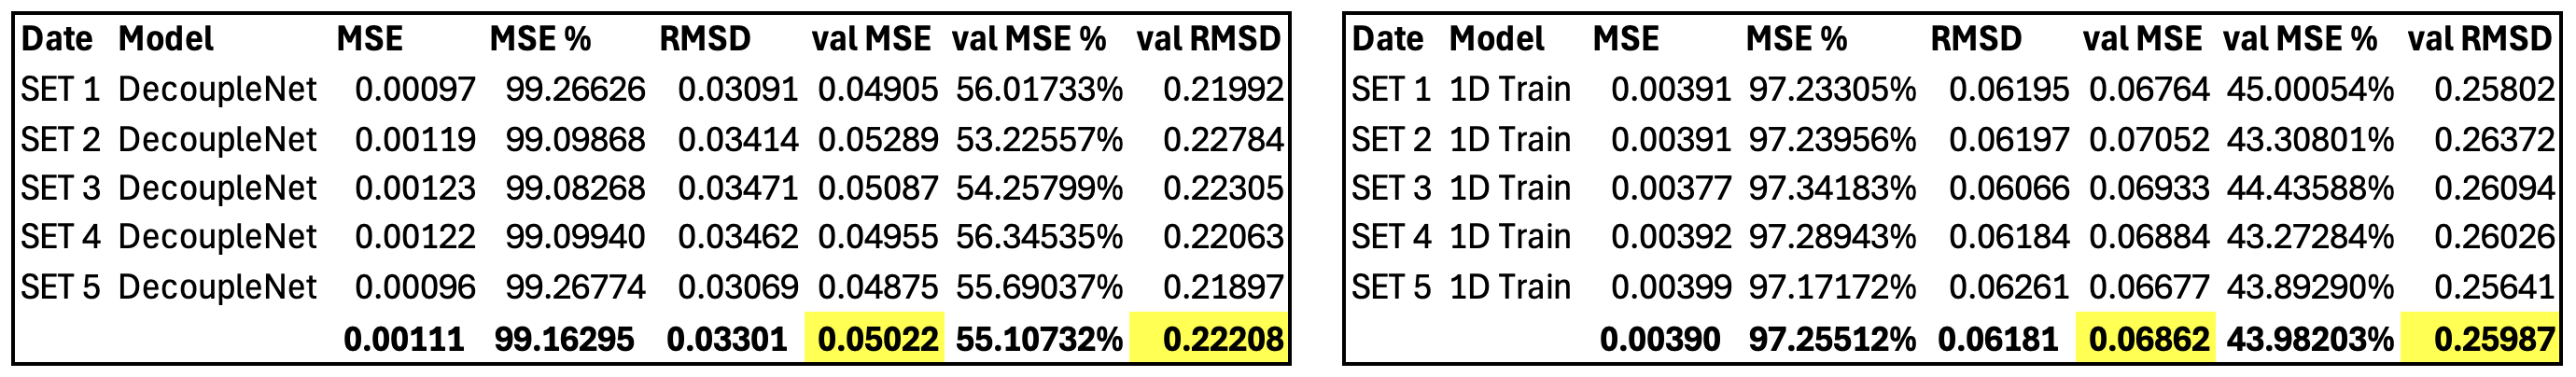

When comparing the performance of DecoupleNET to 1D Train we can see that DecoupleNET achieved an average validation MSE loss of 0.05022 and 1D Train achieved an average validation MSE loss of 0.06862. Hence, when measuring performance using validation MSE loss **DecoupleNET performed 26.811% better than 1D Train.** When looking at the lowest RMSD achieved by either model one can see that DecoupleNET performed 14.541% better than 1D Train. 

In [16]:
from scipy import stats

DecoupleNetValues = [0.04905, 0.05289, 0.05087, 0.04955, 0.04875] 
OneDTrainValues   = [0.06764, 0.07052, 0.06933, 0.06884, 0.06677] 

t_stat, p_value = stats.ttest_rel(DecoupleNetValues, OneDTrainValues)
if p_value < 0.05:
    print("Datasets are significantly different at a 5% confidence level")
    print("P-value: " + str(round(p_value, 12)))
else:
    print("Datasets are not significantly different at a 5% confidence level")
    print("P-value: " + str(round(p_value, 12)))

Datasets are significantly different at a 5% confidence level
P-value: 3.21831e-07


As shown by the paired t-test above incorporating time evolution into a dense feed forward neural network leads to a statistically significant improvement of performance in virtual decoupling of protein C13 NMR spectra. 

<a id="res_depth"></a>
### Results of measuring the effect of network depth
---

In the table below the model name describes the number of layers and neurons per layer. In this experiment the number of neurons (1024) was kept the same for each model, as a control variable. Each model had a different number of hidden layers after the concatenate layer. They each had one layer of 1024 neurons after each of the input layers before the concatenate layer. The general structure can be found [here](#opti), the model at the link is the optimised version of DecoupleNET, which is shown in the table below as 2L_1024N, as it has 2 hidden layers of 1024 neurons after the concatenate layer.

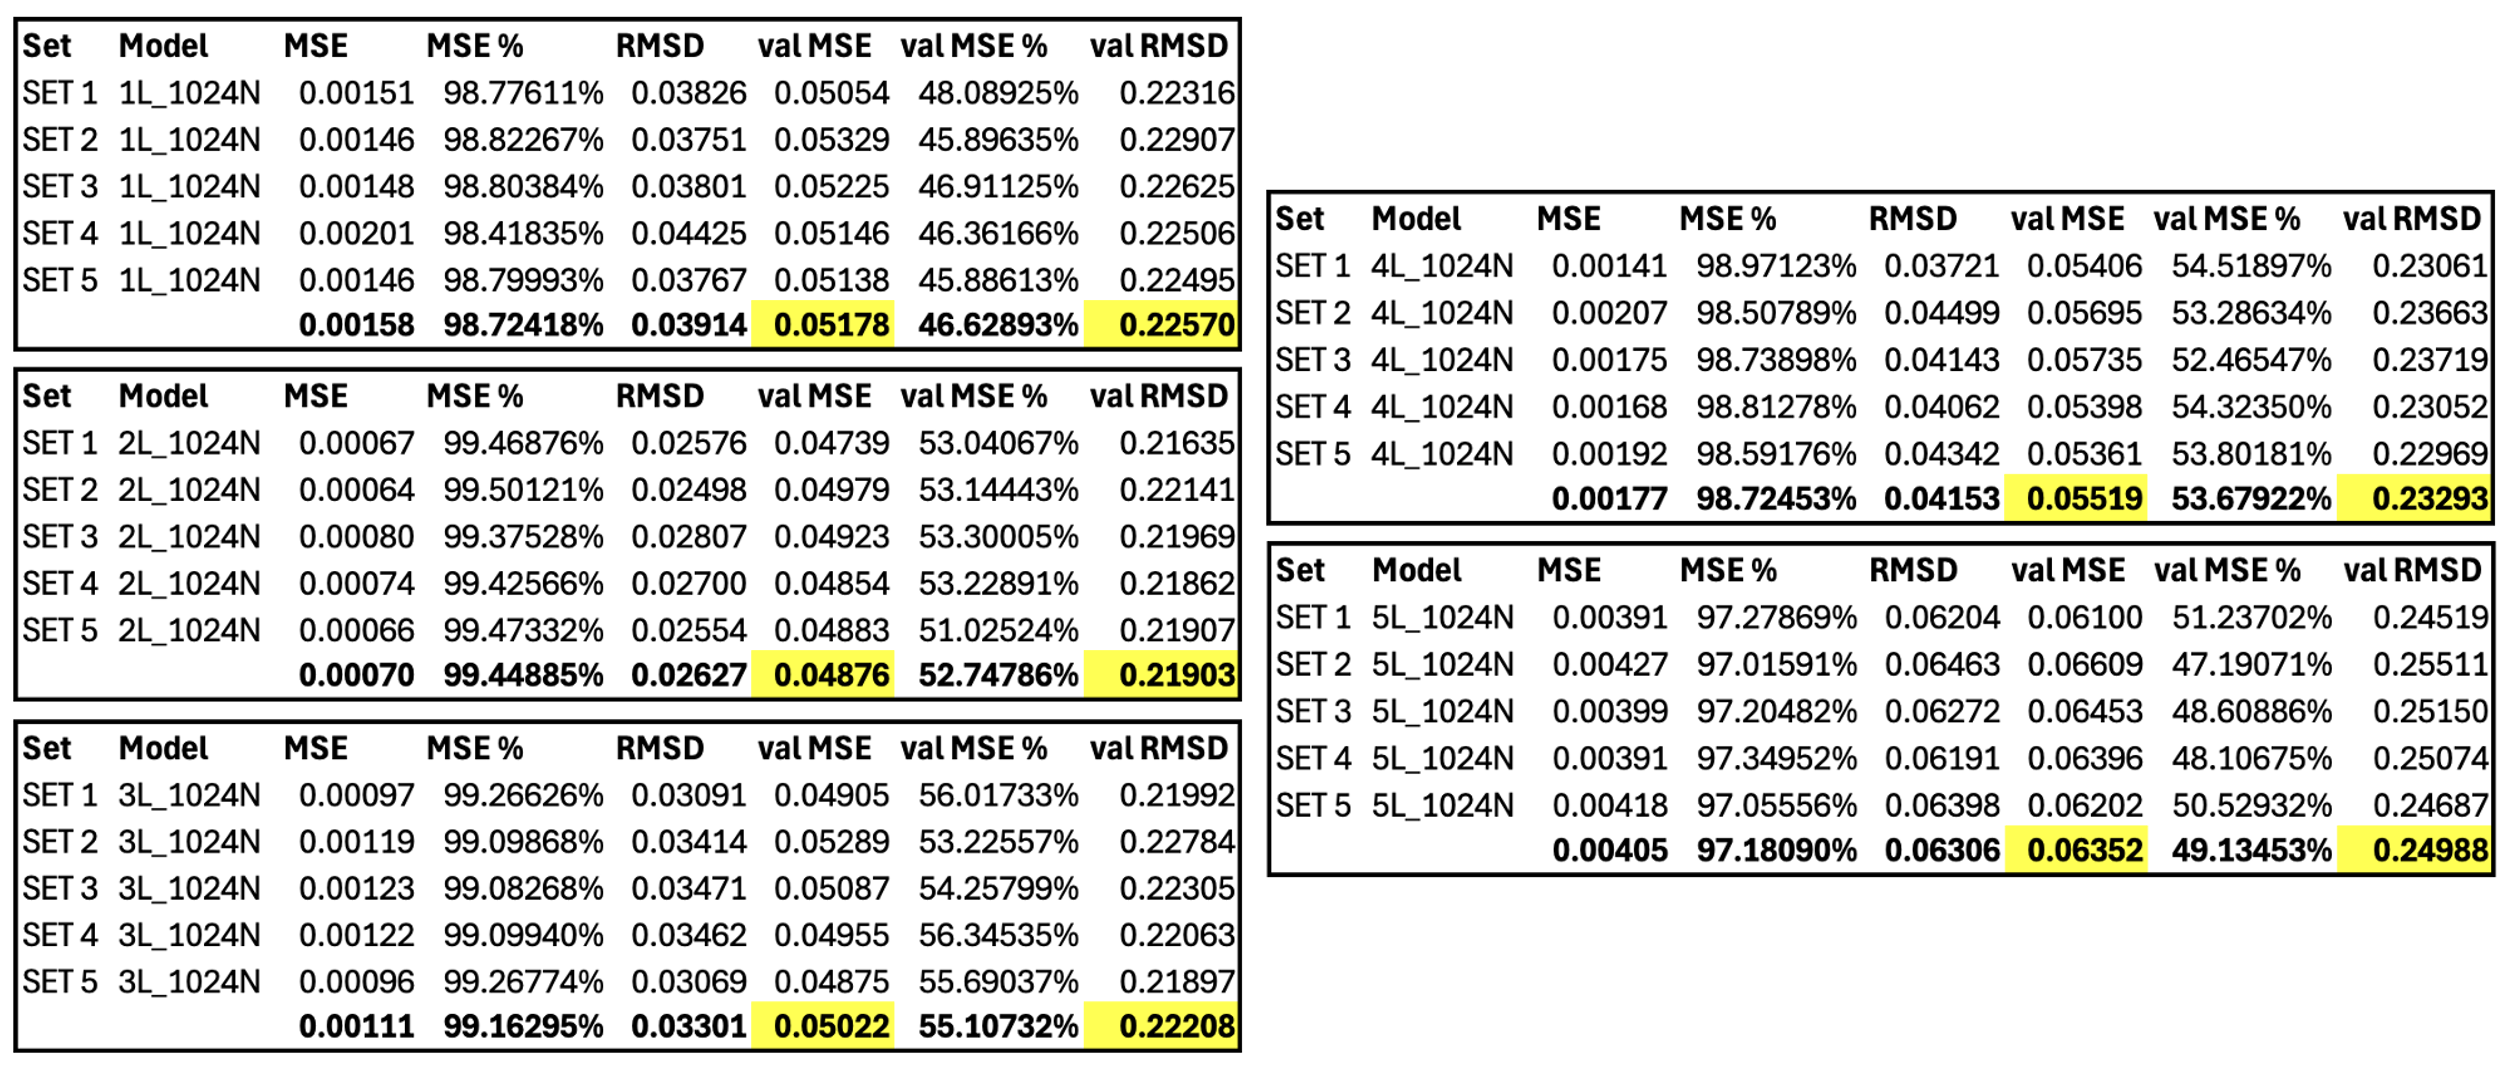

In [17]:
_1L = [0.05054, 0.05329, 0.05225, 0.05146, 0.05138]
_2L = [0.04739, 0.04979, 0.04923, 0.04854, 0.04883] 
_3L = [0.04905, 0.05289, 0.05087, 0.04955, 0.04875]
_4L = [0.05406, 0.05695, 0.05735, 0.05398, 0.05361]
_5L = [0.06100, 0.06609, 0.06453, 0.06396, 0.06202]

vals_dict = {
    "1L_1024N" : _1L,
    "2L_1024N" : _2L,
    "3L_1024N" : _3L,
    "4L_1024N" : _4L,
    "5L_1024N" : _5L
}

mean_losses = {name: np.mean(values) for name, values in vals_dict.items()}
print("Average loss for each model:")
for name, mean in mean_losses.items():
    print(name + ": " + str(round(mean, 5)))
print("")

best_model = min(mean_losses, key=mean_losses.get)
best_model_vals = vals_dict[best_model]
print("The best model is " + best_model + " with an average validation MSE loss across the 5 training datasets of: " + str(round(mean_losses[best_model], 5)))
print("")

print("Paired t-test of the other models vs best model:")
for name, vals in vals_dict.items():
    if name == best_model:
        continue
    t_stat, p_val = stats.ttest_rel(best_model_vals, vals)
    if p_val < 0.05:
        print(best_model + " vs " + name + " --> p-value = " + str(round(p_val, 10)) + " --> Statistically significant at a 5% confidence level")
    else:
        print(best_model + " vs " + name + " --> p-value = " + str(round(p_val, 10)) + " --> Not statistically significant at a 5% confidence level")

Average loss for each model:
1L_1024N: 0.05178
2L_1024N: 0.04876
3L_1024N: 0.05022
4L_1024N: 0.05519
5L_1024N: 0.06352

The best model is 2L_1024N with an average validation MSE loss across the 5 training datasets of: 0.04876

Paired t-test of the other models vs best model:
2L_1024N vs 1L_1024N --> p-value = 4.00496e-05 --> Statistically significant at a 5% confidence level
2L_1024N vs 3L_1024N --> p-value = 0.0469527447 --> Statistically significant at a 5% confidence level
2L_1024N vs 4L_1024N --> p-value = 0.0004227427 --> Statistically significant at a 5% confidence level
2L_1024N vs 5L_1024N --> p-value = 1.48137e-05 --> Statistically significant at a 5% confidence level


As shown by the output of the code block above model 2L_1024N performed better than the other models.

As shown by the t-tests of the validation MSE loss values of model 2L_1024N against the other models, model 2L_1024N showed a statistically significant difference in performance when compared to all of the other models. 

<a id="res_neurons"></a>
### Results of measuring the effect of layer size
---

As shown by the [section above](#res_depth), 2 hidden layers after the concatenate layer led to the best performance for virtually decoupling C13 NMR spectra with parameters used in the [spectra generation section.](#spec_gen) 

Therefore I measured the effect of changing the size of the hidden layers; the 2 hidden layers after the concatenate layer and each of the branch layers (the layers between each input layer and the concatenate layer).

As with the section above, in the table below the model name describes the number of layers and neurons per layer.

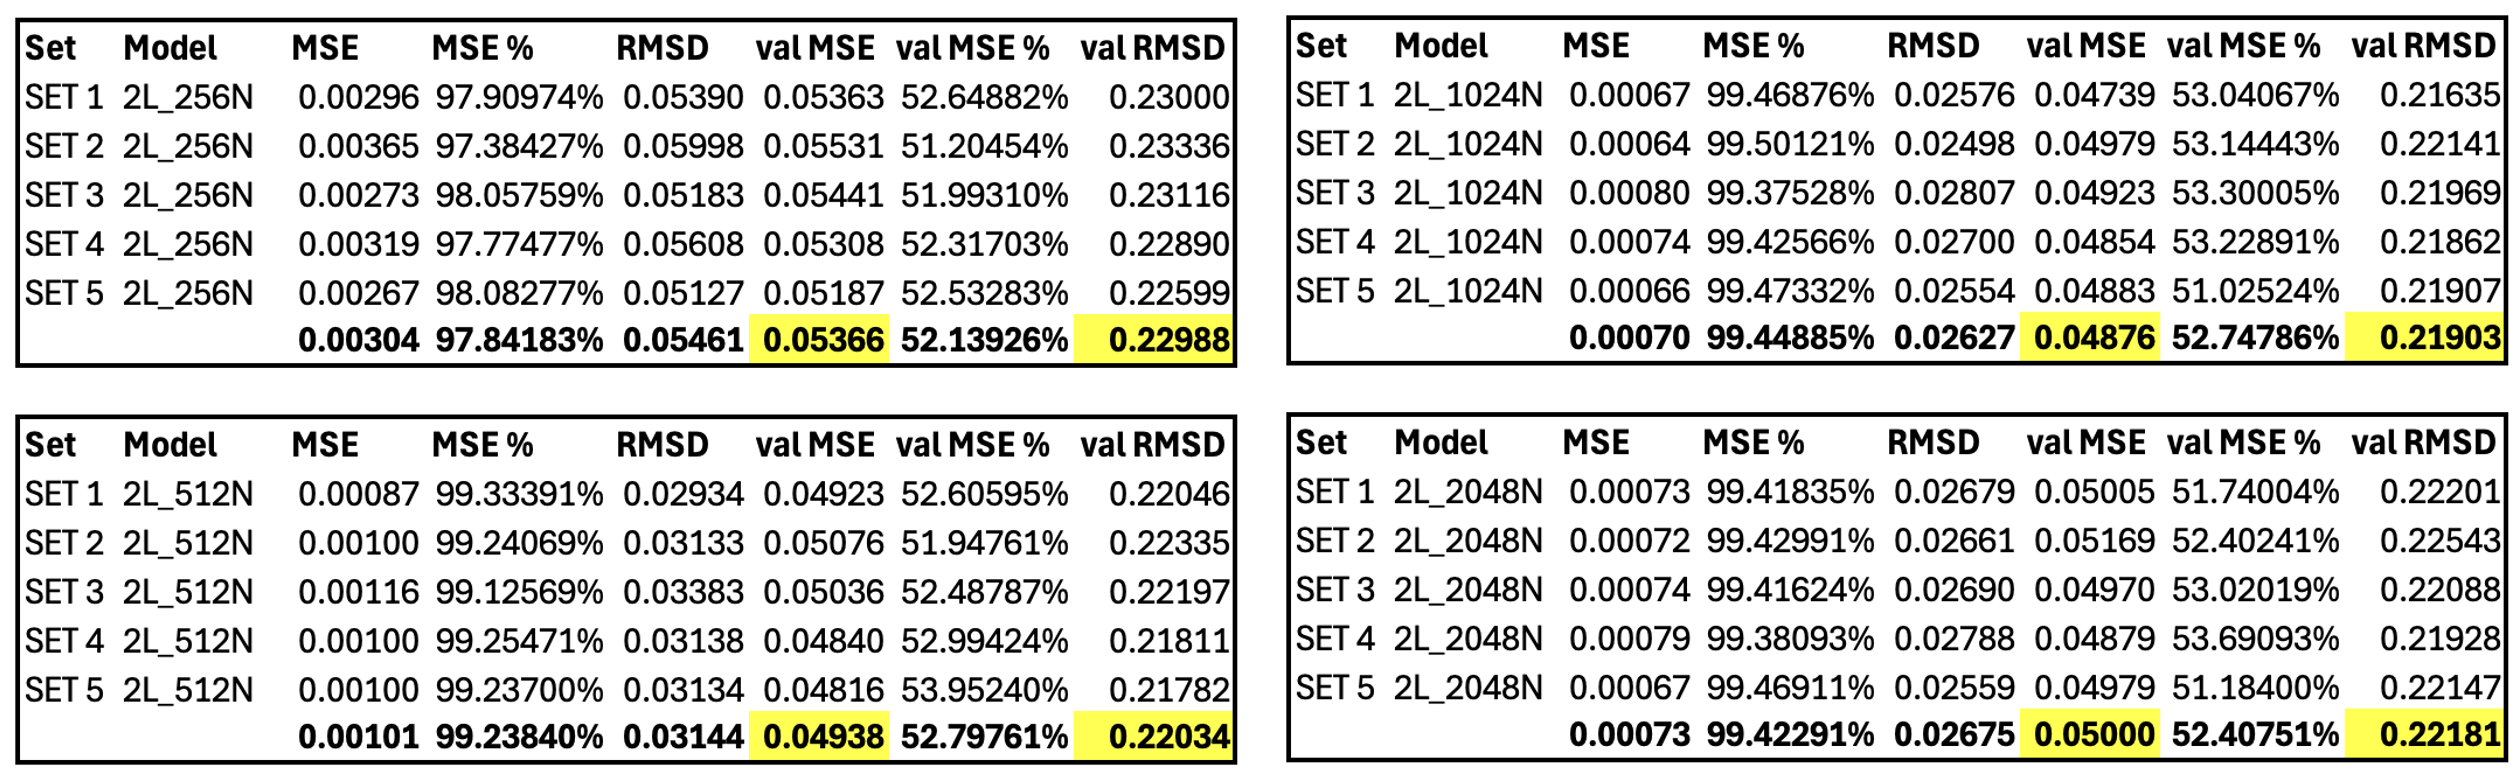

In [18]:
_256  = [0.05363, 0.05531, 0.05441, 0.05308, 0.05187]
_512  = [0.04923, 0.05076, 0.05036, 0.04840, 0.04816] 
_1024 = [0.04739, 0.04979, 0.04923, 0.04854, 0.04883]
_2048 = [0.05005, 0.05169, 0.04970, 0.04879, 0.04979]


vals_dict = {
    "2L_256N"  : _256,
    "2L_512N"  : _512,
    "2L_1024N" : _1024,
    "2L_2048N" : _2048
}

mean_losses = {name: np.mean(values) for name, values in vals_dict.items()}
print("Average loss for each model:")
for name, mean in mean_losses.items():
    print(name + ": " + str(round(mean, 5)))
print("")

best_model = min(mean_losses, key=mean_losses.get)
best_model_vals = vals_dict[best_model]
print("The best model is " + best_model + " with an average validation MSE loss across the 5 training datasets of: " + str(round(mean_losses[best_model], 5)))
print("")

print("Paired t-test of the other models vs best model:")
for name, vals in vals_dict.items():
    if name == best_model:
        continue
    t_stat, p_val = stats.ttest_rel(best_model_vals, vals)
    if p_val < 0.05:
        print(best_model + " vs " + name + " --> p-value = " + str(round(p_val, 10)) + " --> Statistically significant at a 5% confidence level")
    else:
        print(best_model + " vs " + name + " --> p-value = " + str(round(p_val, 10)) + " --> Not statistically significant at a 5% confidence level")

Average loss for each model:
2L_256N: 0.05366
2L_512N: 0.04938
2L_1024N: 0.04876
2L_2048N: 0.05

The best model is 2L_1024N with an average validation MSE loss across the 5 training datasets of: 0.04876

Paired t-test of the other models vs best model:
2L_1024N vs 2L_256N --> p-value = 0.0008192729 --> Statistically significant at a 5% confidence level
2L_1024N vs 2L_512N --> p-value = 0.2395605068 --> Not statistically significant at a 5% confidence level
2L_1024N vs 2L_2048N --> p-value = 0.0510936075 --> Not statistically significant at a 5% confidence level


As shown by the output of the code block above model 2L_1024N performed better than the other models.

As shown by the t-tests of the validation MSE loss values of model 2L_1024N against the other models, model 2L_1024N showed a statistically significant difference in performance when compared to only 2L_256N.

<a id="res_densevsconv"></a>
### Results of measuring the difference between dense and convolutional layers
---

#### Performance: 
The table below provides an overview of the architecture of all 8 models and their average validation MSE loss when tested on the 5 static training datasets.

All 8 of the models have 2 input layers and 1 hidden layer between each input layer and the concatenate layer. In the data table below the value in the 'Hidden layers' column refers to the number of hidden layers between the concatenate layer and the output layer. The 'Size diff%' column contains the values for the difference in the number of parameters, expressed as a percentage of the number of parameters in the dense model, for a given pair of dense and convolutional models. The 'Improve%' column contains the magnitude of the difference in the validation MSE loss of a given pair of models, expressed as a percentage of the relevant dense model.

Model names that start with 'conv' denote a convolutional model, model names that start with 'vsCONV' denote a dense, feed-forward model.

The model suffix '_S' denotes a smaller version of the model (less filters or neurons); the model suffix '_3L' denotes a version of the model that only has 3 hidden layers between the concatenate and output layers, rather than 5. 

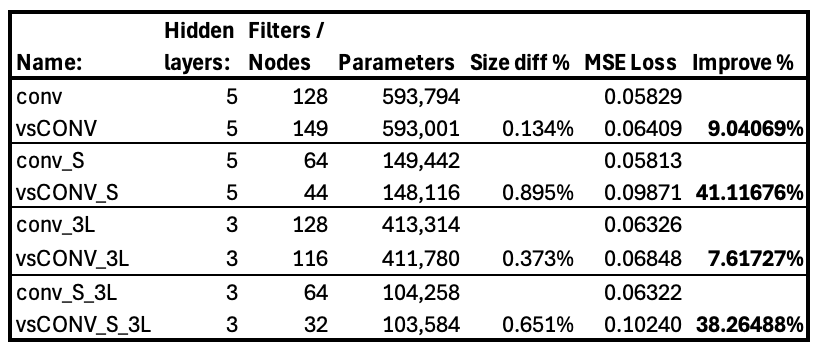

#### Data:
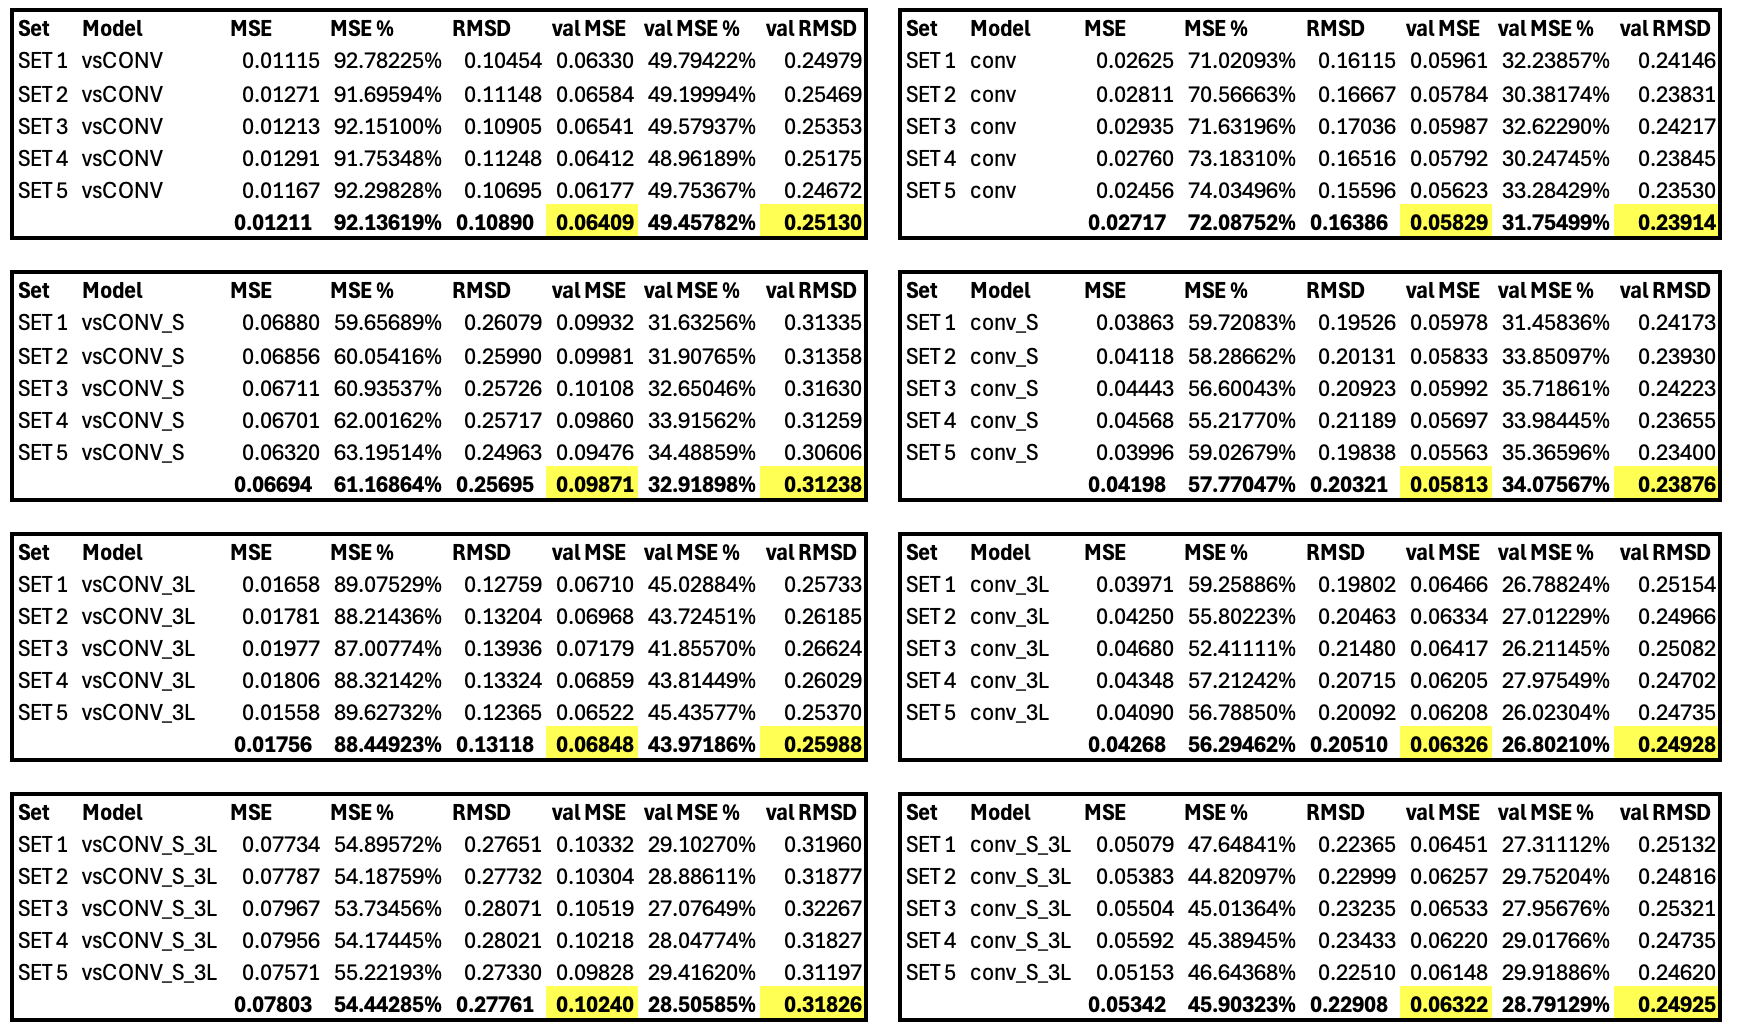

In [19]:
vsCONV_vals      = [0.06330, 0.06584, 0.06541, 0.06412, 0.06177]
conv_vals        = [0.05961, 0.05784, 0.05987, 0.05792, 0.05623]

vsCONV_S_vals    = [0.09932, 0.09981, 0.10108, 0.09860, 0.09476]
conv_S_vals      = [0.05978, 0.05833, 0.05992, 0.05697, 0.05563]

vsCONV_3L_vals   = [0.06710, 0.06968, 0.07179, 0.06859, 0.06522]
conv_3L_vals     = [0.06466, 0.06334, 0.06417, 0.06205, 0.06208]

vsCONV_S_3L_vals = [0.10332, 0.10304, 0.10519, 0.10218, 0.09828]
conv_S_3L_vals   = [0.06451, 0.06257, 0.06533, 0.06220, 0.06148]

vals_dict = {
    "vsCONV vs conv          " : [vsCONV_vals, conv_vals],
    "vsCONV_S vs conv_S      " : [vsCONV_S_vals, conv_S_vals],
    "vsCONV_3L vs conv_3L    " : [vsCONV_3L_vals, conv_3L_vals],
    "vsCONV_S_3L vs conv_S_3L" : [vsCONV_S_3L_vals, conv_S_3L_vals]
}

print("Average validation MSE loss values and improvement:")
for exp_name, value in vals_dict.items():
    dense_mean = np.mean(value[0])
    conv_mean  = np.mean(value[1])
    improvement = round(((dense_mean-conv_mean) / dense_mean) * 100, 5)
    print(exp_name + " : " + str(round(dense_mean, 5)) + " vs " + str(round(conv_mean, 5)) + " --> Improvement: " + str(improvement) + "%")
print("")
print("")

print("Significance tests using paired t-test:")
for exp_name, value in vals_dict.items():
    dense_vals = value[0]
    conv_vals  = value[1]
    t_stat, p_val = stats.ttest_rel(dense_vals, conv_vals)
    if p_val < 0.05:
        print(exp_name + " --> p-value = " + str(round(p_val, 10)) + " --> Statistically significant at a 5% confidence level")
    else:
        print(exp_name + " --> p-value = " + str(round(p_val, 10)) + " --> Not statistically significant at a 5% confidence level")


Average validation MSE loss values and improvement:
vsCONV vs conv           : 0.06409 vs 0.05829 --> Improvement: 9.04069%
vsCONV_S vs conv_S       : 0.09871 vs 0.05813 --> Improvement: 41.11676%
vsCONV_3L vs conv_3L     : 0.06848 vs 0.06326 --> Improvement: 7.61727%
vsCONV_S_3L vs conv_S_3L : 0.1024 vs 0.06322 --> Improvement: 38.26488%


Significance tests using paired t-test:
vsCONV vs conv           --> p-value = 0.0011150704 --> Statistically significant at a 5% confidence level
vsCONV_S vs conv_S       --> p-value = 1.629e-07 --> Statistically significant at a 5% confidence level
vsCONV_3L vs conv_3L     --> p-value = 0.0069183016 --> Statistically significant at a 5% confidence level
vsCONV_S_3L vs conv_S_3L --> p-value = 4.662e-07 --> Statistically significant at a 5% confidence level


As shown by the output of the code block above, in all 4 of the experiments the convolutional neural network (CNN) outperformed its dense counterpart. 

Furthermore, there was a statistically significant difference between the validation MSE loss values of all 4 CNNs and their dense counterpart. 

## Figures

<a id="fig1"></a>
### Figure 1: Difference in validation MSE loss with and without time evolution
---

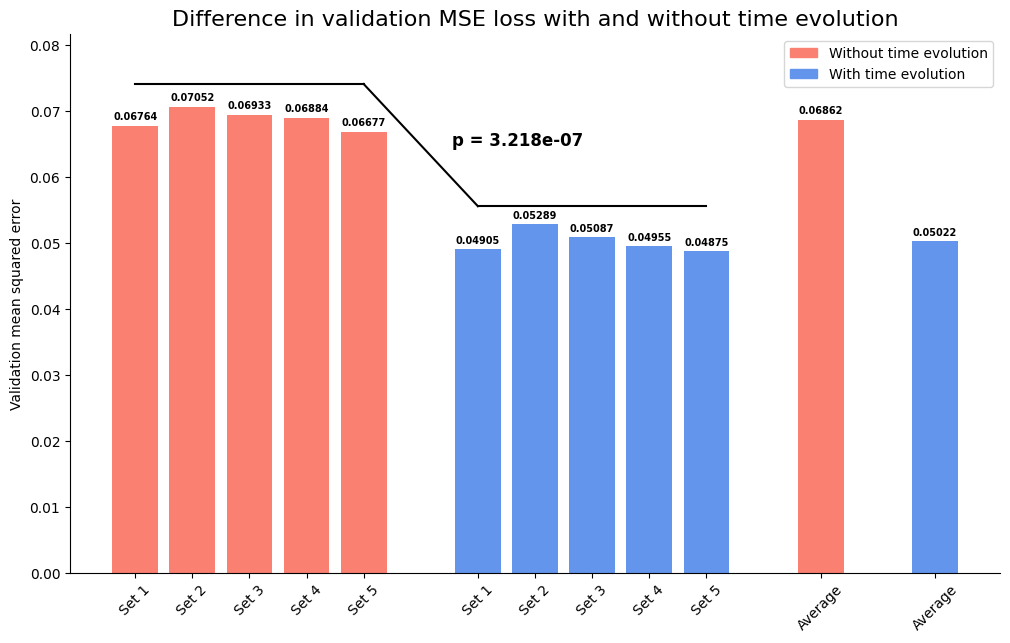

In [20]:
import matplotlib.patches as mpatches 
from scipy import stats

#validation MSE loss values
OneDTrainValues   = [0.06764, 0.07052, 0.06933, 0.06884, 0.06677] 
DecoupleNetValues = [0.04905, 0.05289, 0.05087, 0.04955, 0.04875] 

t_stat, p_value = stats.ttest_rel(OneDTrainValues, DecoupleNetValues)

OneDTrainAverage   = np.mean(OneDTrainValues)
DecoupleNetAverage = np.mean(DecoupleNetValues)

#Spacing
x1 = np.arange(len(OneDTrainValues))  
x2 = np.arange(len(DecoupleNetValues)) + len(x1) + 1  
x3 = [x2[-1] + 2]  
x4 = [x3[-1] + 2]  

x_pos = np.concatenate([x1, x2, x3, x4])
y_vals = OneDTrainValues + DecoupleNetValues + [OneDTrainAverage] + [DecoupleNetAverage]

colors = ["salmon"] * len(OneDTrainValues) + ["cornflowerblue"] * len(DecoupleNetValues) + ["salmon"] + ["cornflowerblue"]

plt.figure(figsize=(12, 7))
plt.bar(x_pos, y_vals, color=colors)

x_labels = []
for i in range(len(OneDTrainValues)):
    x_labels.append("Set " + str(i+1))
for i in range(len(DecoupleNetValues)):
    x_labels.append("Set " + str(i+1))
x_labels.append("Average")
x_labels.append("Average")

for x, y_val in zip(x_pos, y_vals): #adding labels above the bars
    plt.text(x, y_val + (y_val * 0.01), str(round(y_val, 5)), ha="center", va="bottom", fontsize=7, fontweight="bold")

plt.xticks(x_pos, labels=x_labels, rotation=45)

plt.ylabel("Validation mean squared error")
plt.title("Difference in validation MSE loss with and without time evolution", fontsize=16)

OneDTrainLabel   = mpatches.Patch(color="salmon", label="Without time evolution")
DecoupleNetLabel = mpatches.Patch(color="cornflowerblue", label="With time evolution")
plt.legend(handles=[OneDTrainLabel, DecoupleNetLabel])

decouple_height = max(DecoupleNetValues) * 1.05
oneD_height     = max(OneDTrainValues) * 1.05
p_text_height   = ((oneD_height) + (decouple_height)) / 2

plt.plot([x1[0], x1[-1]], [oneD_height, oneD_height], color="black", linewidth=1.5)
plt.plot([x2[0], x2[-1]], [decouple_height, decouple_height], color="black", linewidth=1.5)
plt.plot([x2[0], x1[-1]], [decouple_height, oneD_height], color="black", linewidth=1.5)

plt.plot([x1[0], x2[-1]], [oneD_height*1.05, oneD_height*1.05], color="white") #creates space so the legend doesn't overlap

p_text = "p = " + str(round(p_value, 10)) 
plt.text(((x1[-1]+x2[0])/2)+1.7, p_text_height, p_text, ha="center", fontsize=12, fontweight="bold")

ax = plt.gca()  
ax.spines["top"].set_visible(False)   
ax.spines["right"].set_visible(False)

plt.show()

<a id="fig2"></a>
### Figure 2: Relationship between number of layers and neurons, and validation MSE loss
---

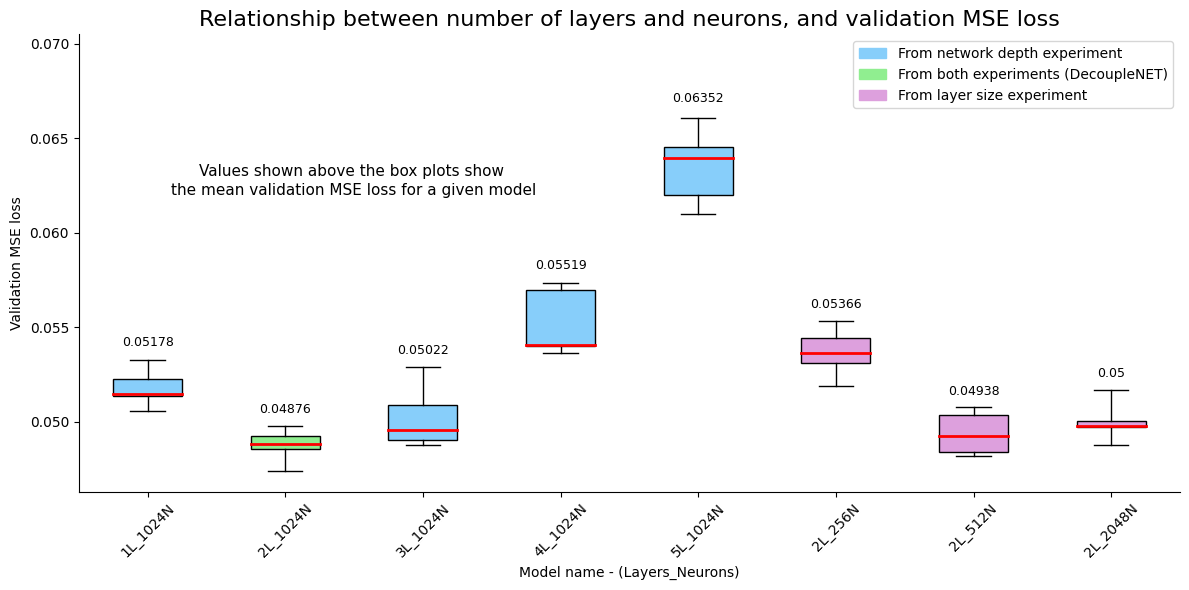

In [21]:
_1L_1024N = [0.05054, 0.05329, 0.05225, 0.05146, 0.05138]
_2L_1024N = [0.04739, 0.04979, 0.04923, 0.04854, 0.04883] 
_3L_1024N = [0.04905, 0.05289, 0.05087, 0.04955, 0.04875]
_4L_1024N = [0.05406, 0.05695, 0.05735, 0.05398, 0.05361]
_5L_1024N = [0.06100, 0.06609, 0.06453, 0.06396, 0.06202]

_2L_256N  = [0.05363, 0.05531, 0.05441, 0.05308, 0.05187]
_2L_512N  = [0.04923, 0.05076, 0.05036, 0.04840, 0.04816] 
_2L_1024N = [0.04739, 0.04979, 0.04923, 0.04854, 0.04883] #exists in both datasets 
_2L_2048N = [0.05005, 0.05169, 0.04970, 0.04879, 0.04979]

data = {
    "1L_1024N" : _1L_1024N,
    "2L_1024N" : _2L_1024N,
    "3L_1024N" : _3L_1024N,
    "4L_1024N" : _4L_1024N,
    "5L_1024N" : _5L_1024N,
    "2L_256N"  : _2L_256N,
    "2L_512N"  : _2L_512N,
    "2L_2048N" : _2L_2048N
}

labels = list(data.keys())
values = list(data.values())

plt.figure(figsize=(12, 6))
box_plot = plt.boxplot(values, labels=labels, patch_artist=True, whis=np.inf)

colors = ["lightskyblue", "lightgreen"]
for i in range(3):
    colors.append("lightskyblue")
for i in range(3):
    colors.append("plum")
for i, box in enumerate(box_plot["boxes"]):
    box.set_facecolor(colors[i]) 

for median in box_plot["medians"]:
    median.set(color="red", linewidth=2)

for i, y_values in enumerate(values):
    height = max(y_values) * 1.01
    mean_val = np.mean(y_values)
    plt.text(i + 1, height, str(round(mean_val, 5)), ha="center", va="bottom", fontsize=9, color="black")


plt.text(2.5, 0.063, "Values shown above the box plots show ", ha="center", fontsize=11, color="black") 
plt.text(2.5, 0.062, "the mean validation MSE loss for a given model", ha="center", fontsize=11, color="black")
plt.plot([2, 5], [max(_5L_1024N)*1.05, max(_5L_1024N)*1.05], color="white") #creates space so the highest average value doesnt overlap 

plt.xticks(rotation=45)
plt.ylabel("Validation MSE loss")
plt.xlabel("Model name - (Layers_Neurons)")
plt.title("Relationship between number of layers and neurons, and validation MSE loss", fontsize=16)
layers_label    = mpatches.Patch(color="lightskyblue", label="From network depth experiment")
decoupNET_label = mpatches.Patch(color="lightgreen", label="From both experiments (DecoupleNET)")
neurons_label   = mpatches.Patch(color="plum", label="From layer size experiment")
plt.legend(handles=[layers_label, decoupNET_label, neurons_label])
plt.tight_layout()

ax = plt.gca()  
ax.spines["top"].set_visible(False)   
ax.spines["right"].set_visible(False)

plt.show()

<a id="fig3"></a>
### Figure 3: Comparison of validation MSE loss using convolutional layers against dense layers
---

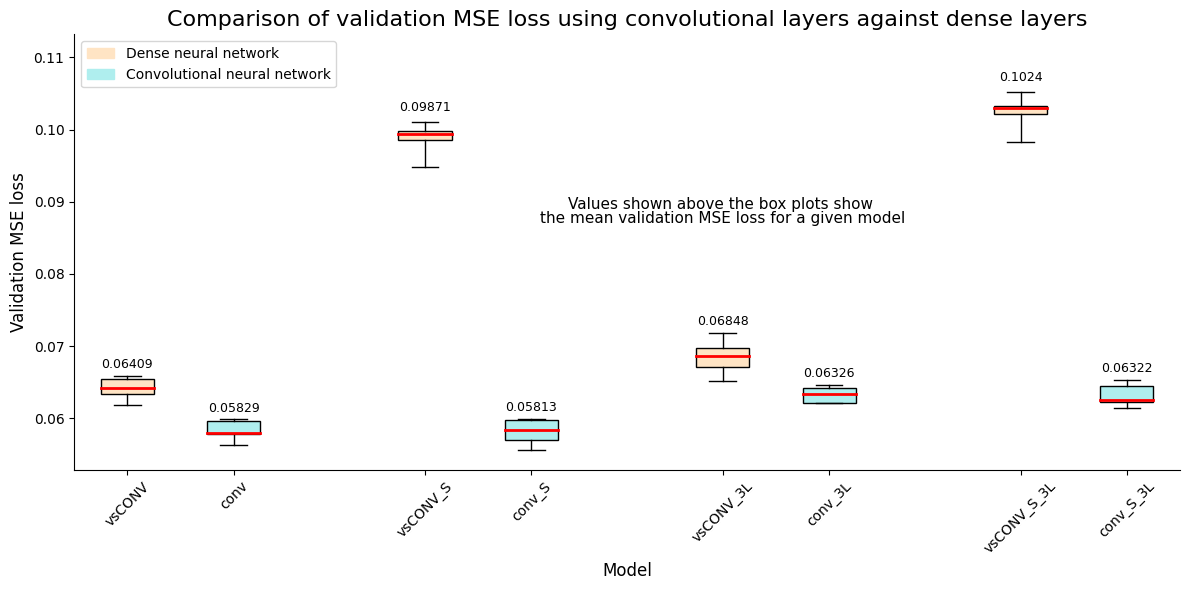

In [22]:
vsCONV_vals      = [0.06330, 0.06584, 0.06541, 0.06412, 0.06177]
conv_vals        = [0.05961, 0.05784, 0.05987, 0.05792, 0.05623]

vsCONV_S_vals    = [0.09932, 0.09981, 0.10108, 0.09860, 0.09476]
conv_S_vals      = [0.05978, 0.05833, 0.05992, 0.05697, 0.05563]

vsCONV_3L_vals   = [0.06710, 0.06968, 0.07179, 0.06859, 0.06522]
conv_3L_vals     = [0.06466, 0.06334, 0.06417, 0.06205, 0.06208]

vsCONV_S_3L_vals = [0.10332, 0.10304, 0.10519, 0.10218, 0.09828]
conv_S_3L_vals   = [0.06451, 0.06257, 0.06533, 0.06220, 0.06148]

values = [
    vsCONV_vals,
    conv_vals,
    vsCONV_S_vals,
    conv_S_vals,
    vsCONV_3L_vals,
    conv_3L_vals,
    vsCONV_S_3L_vals,
    conv_S_3L_vals
]

labels = [
    "vsCONV",
    "conv",
    "vsCONV_S",
    "conv_S",
    "vsCONV_3L",
    "conv_3L",
    "vsCONV_S_3L",
    "conv_S_3L"
]

x_pos = []
colors = []
gap = 1.8

for i in range(int(len(values)/2)):
    shift = gap * i
    x_pos.append(i + shift)
    x_pos.append(i + shift + 1)
    colors.append("bisque")
    colors.append("paleturquoise")

dense_label = mpatches.Patch(color="bisque", label="Dense neural network")
convo_label = mpatches.Patch(color="paleturquoise", label="Convolutional neural network")

plt.figure(figsize=(12, 6))
box_plot = plt.boxplot(values, positions=x_pos, patch_artist=True, whis=np.inf)

for i, box in enumerate(box_plot["boxes"]):
    box.set_facecolor(colors[i]) 
for median in box_plot["medians"]:
    median.set(color="red", linewidth=2)

for i in range(len(values)):
    height = max(values[i]) * 1.01
    mean_val = np.mean(values[i])
    plt.text(x_pos[i], height, str(round(mean_val, 5)), ha="center", va="bottom", fontsize=9, color="black")

plt.text(5.6, 0.089, "Values shown above the box plots show ", ha="center", fontsize=11, color="black") 
plt.text(5.6, 0.087, "the mean validation MSE loss for a given model", ha="center", fontsize=11, color="black")
plt.plot([6.6, 9.3], [max(vsCONV_S_3L_vals)*1.05, max(vsCONV_S_3L_vals)*1.05], color="white") #creates space so the highest average value doesnt overlap

plt.ylabel("Validation MSE loss", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.title("Comparison of validation MSE loss using convolutional layers against dense layers", fontsize=16)
plt.legend(handles=[dense_label, convo_label])
plt.xticks(ticks=x_pos, labels=labels, rotation=45)
plt.tight_layout()
ax = plt.gca()  
ax.spines["top"].set_visible(False)   
ax.spines["right"].set_visible(False)
plt.show()


## Model summary and predictions

<a id="summary"></a>
### Summary of the final version of all 3 models
---

In the table below the MSE value refers to the average validation MSE loss value when the relevant model was trained on each of the 5 static training data sets of 10,000 examples each.

| Model | Input layers | Hidden Layers | Parameters | Layer Type | Layer size | Code | MSE | 
| ----- | ------------ | ------------- | ---------- | ---------- | ---------- | ---- | --- |
| 1D Train | 1 | 6 | 7,347,200 | Dense | 1024 neurons | [Link](#d_train) | 0.06862 |
| DecoupleNET | 2 | 4 (incl 1 layer in each input branch) | 6,296,576 | Dense | 1024 neurons | [Link](#opti) | 0.04876  |
| DecoupleNET_conv | 2 | 7 (incl 1 layer in each input branch)| 149,442 | Convolutional | 64 filters | [Link](#conv) | 0.05813 |

<a id="preds_user"></a>
### Model predictions with user specified parameters
---

#### Use the cell below to generate 1 validation example, with user specified parameters to test all 3 models:

The quality of these predictions may be lower than desired as these models were only trained on 10,000 examples. For high accuracy predictions, please go the [final section](#big) of this notebook to use a model that was trained on 100,000 examples.

When this code is run on a Jupyter Notebook the graphs that are generated are not interactive; one cannot zoom into the plots. Therefore I have also written a script called "**21.specific_parameter_predictions.py**" which will be in the same folder as this notebook. This script, when run in an environment that has the required libraries, detailed in the [setup](#setup) section, will generate the same plots but they will be interactive. To make the peaks below easier to see I have limited the x-axis to PPM values between 55-60 which will encompass any peaks with an omega ranging from -1500 to 1500Hz, if the .py file is run instead, the whole sweep width of 3000Hz (50-65ppm) will be visible and one can zoom into the peaks.

Number of nuclei / peaks: 4
Parameters for the last peak on the spectrum:
J: 0
A: 1.1
Omega: 1437
Coupling degree: 0


INPUT: 
Peak PPM: 58.642578125

Loading model: saved_model/DecoupleNET_1D_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1D Train PREDICTION: 
Predicted peak PPM: 57.236328125
Difference between peaks: 1.40625


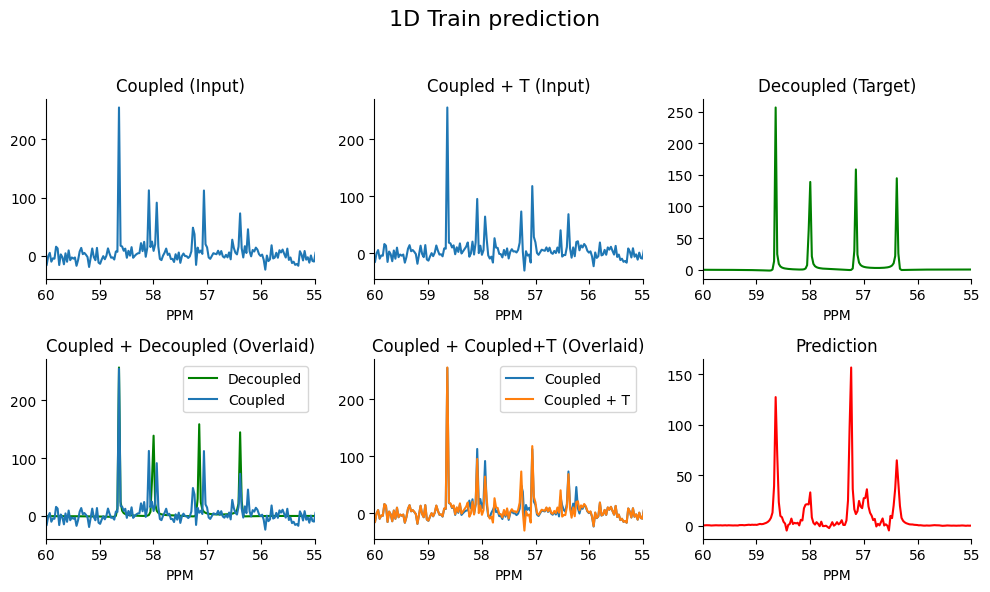






Loading model: saved_model/DecoupleNET_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
DecoupleNET PREDICTION: 
Predicted peak PPM: 58.642578125
Difference between peaks: 0.0


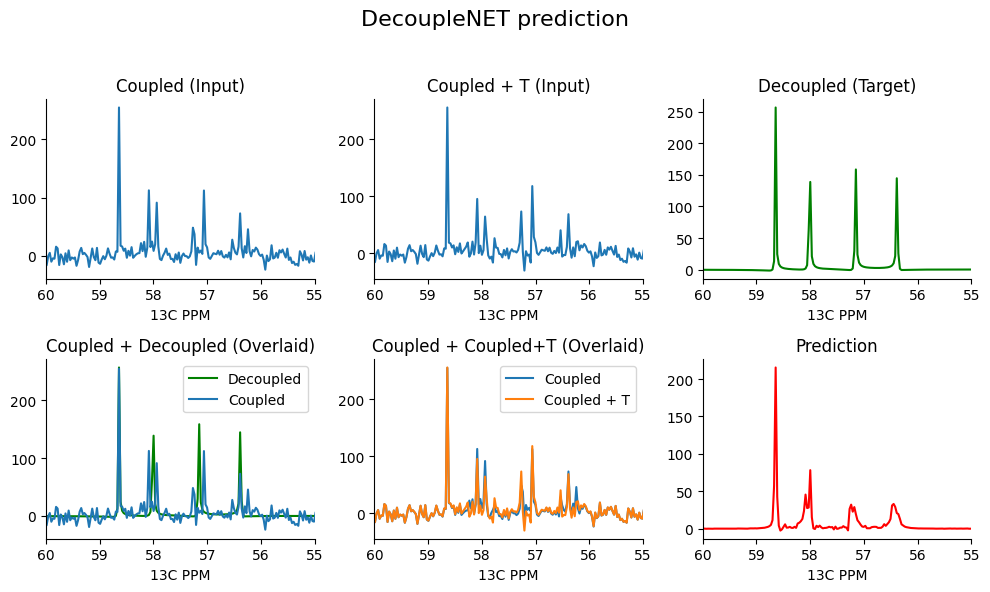






Loading model: saved_model/DecoupleNET_CONV_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
DecoupleNET_conv PREDICTION: 
Predicted peak PPM: 58.642578125
Difference between peaks: 0.0


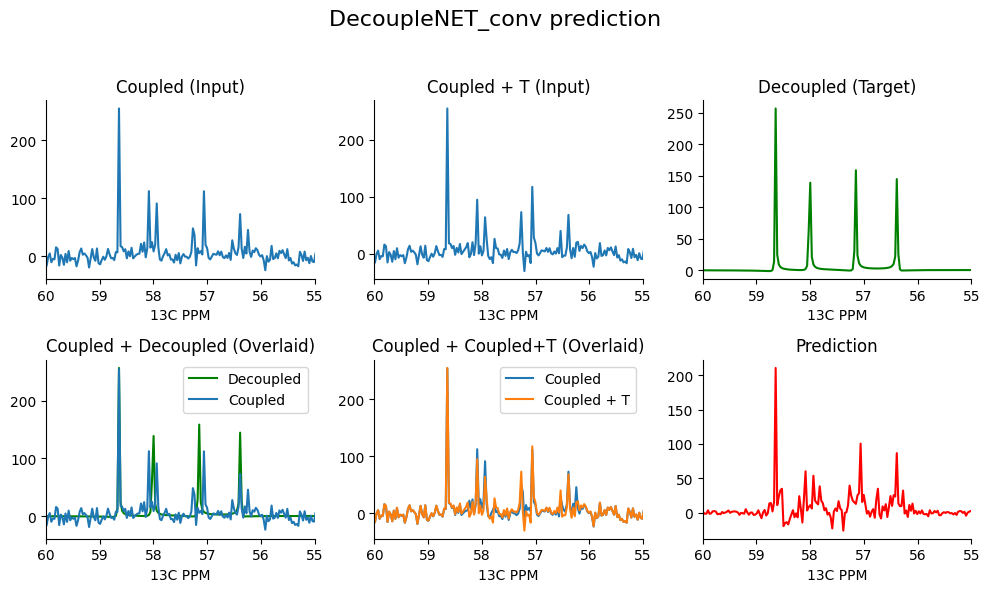

In [23]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        #Adjust the 5 arrays as desired, ensure the length of all 5 arrays are the same.
        #As all of the models were trained on spectra ranging from 1-5 peaks, 
        # it is recommended that the length of the arrays does not exceed 5.
        peak_list =          [-1408, -429, 640, 1437] #Omega values in Hz ranging from -1500 to 1500
        J_list =             [29, 37, 31, 0] #J values in Hz ranging from 28 to 40 
        couple_degree_list = [2, 1, 3, 0] #Coupling degree values ranging from 0 to 3
        A_list =             [0.9, 1, 1.2, 1.1] #A values ranging from >0 to <2
        R2_list =            [10, 10, 10, 10] #R2 values from from 5 to 60
        
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = len(peak_list)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = peak_list[i]
            t = np.linspace(0, self.duration, self.points)
            A = A_list[i]
            R2 = R2_list[i]
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = couple_degree_list[i]
            J = J_list[i]
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            np.random.seed(23)
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_FID_noisy = full_FID + noise
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_full_FID_noisy = full_FID_noisy
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

#Function to convert an array in the form [R1, R2, R3, I1, I2, I3] to [R1+I1, R2+I2, R3+I3]
def output_parse(array):
    final_prediction = []
    transpose = int(len(array)/2)
    for i in range(transpose):
        real = array[i]
        imag = array[i+transpose]
        add = complex(real, imag)
        final_prediction.append(add)
    return final_prediction

def gen_FID():
    return minuk_gen_FID()

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

m = gen_FID()
full_FID = m.out_full_FID
full_coupled_FID = m.out_coupled_FID
full_coupled_T_FID = m.out_coupled_T_FID

spectrum = fftshift(fft(full_FID))
spectrum2 = fftshift(fft(full_coupled_FID))
spectrum3 = fftshift(fft(full_coupled_T_FID))
x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

verify_no_nuclei = m.out_no_nuclei
verify_J = m.out_J
verify_A = m.out_A
verify_omega = m.out_omega
verify_coupling_degree = m.out_couple_degree

print("Number of nuclei / peaks: " + str(verify_no_nuclei))
print("Parameters for the last peak on the spectrum:")
print("J: " + str(verify_J))
print("A: " + str(verify_A))
print("Omega: " + str(verify_omega))
print("Coupling degree: " + str(verify_coupling_degree))
print("")
print("")
print("INPUT: ")
print("Peak PPM: " + str(ppm[spectrum.argmax()]))

#1D TRAIN PREDICTION
pre_trained_model = "saved_model/DecoupleNET_1D_10k.keras"
print("")
print("Loading model: " + str(pre_trained_model))
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

model_input = []
for j in range(len(full_coupled_FID)):
    model_input.append(full_coupled_FID[j].real)
for k in range((len(full_coupled_FID))):
    model_input.append(full_coupled_FID[k].imag)
model_input = np.array(model_input)
model_input = model_input.reshape(1, -1)
prediction = model.predict([model_input])
output = []
for n in range(len(prediction[0])):
    output.append(prediction[0][n])
final_output = output_parse(output)
final_spectrum = fftshift(fft(final_output))

print("1D Train PREDICTION: ")
print("Predicted peak PPM: "  + str(ppm[final_spectrum.argmax()]))
print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle("1D Train prediction", fontsize=16)
axs[0][0].plot(np.real(ppm), np.real(spectrum2))
axs[0][0].set_title("Coupled (Input)")
axs[0][0].set_xlabel("PPM")
axs[0][1].plot(np.real(ppm), np.real(spectrum3))
axs[0][1].set_title("Coupled + T (Input)")
axs[0][1].set_xlabel("PPM")
axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
axs[0][2].set_title("Decoupled (Target)")
axs[0][2].set_xlabel("PPM")
axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
axs[1][0].set_xlabel("PPM")
axs[1][0].legend()
axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
axs[1][1].set_xlabel("PPM")
axs[1][1].legend()
axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
axs[1][2].set_title("Prediction")
axs[1][2].set_xlabel("PPM")
for row in axs:
    for ax in row:
        ax.set_xlim(55, 60)
        ax.invert_xaxis()
        ax.spines["top"].set_visible(False)   
        ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("")
print("")
print("")
print("")

#DecoupleNET PREDICTION
#Change the model name to "saved_model/DecoupleNET_100k.keras" to use the version that was trained on 100k examples.
#More detail on this model in the final section below.
pre_trained_model = "saved_model/DecoupleNET_10k.keras"
print("")
print("Loading model: " + str(pre_trained_model))
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

model_input_t = []
for l in range((len(full_coupled_T_FID))):
    model_input_t.append(full_coupled_T_FID[l].real)
for m in range((len(full_coupled_T_FID))):
    model_input_t.append(full_coupled_T_FID[m].imag)
model_input_t = np.array(model_input_t)
model_input_t = model_input_t.reshape(1, -1)
prediction = model.predict([model_input, model_input_t])
output = []
for n in range(len(prediction[0])):
    output.append(prediction[0][n])
final_output = output_parse(output)
final_spectrum = fftshift(fft(final_output))

print("DecoupleNET PREDICTION: ")
print("Predicted peak PPM: "  + str(ppm[final_spectrum.argmax()]))
print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle("DecoupleNET prediction", fontsize=16)
axs[0][0].plot(np.real(ppm), np.real(spectrum2))
axs[0][0].set_title("Coupled (Input)")
axs[0][0].set_xlabel("13C PPM")
axs[0][1].plot(np.real(ppm), np.real(spectrum3))
axs[0][1].set_title("Coupled + T (Input)")
axs[0][1].set_xlabel("13C PPM")
axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
axs[0][2].set_title("Decoupled (Target)")
axs[0][2].set_xlabel("13C PPM")
axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
axs[1][0].set_xlabel("13C PPM")
axs[1][0].legend()
axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
axs[1][1].set_xlabel("13C PPM")
axs[1][1].legend()
axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
axs[1][2].set_title("Prediction")
axs[1][2].set_xlabel("13C PPM")
for row in axs:
    for ax in row:
        ax.set_xlim(55, 60)
        ax.invert_xaxis()
        ax.spines["top"].set_visible(False)   
        ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("")
print("")
print("")
print("")

#DecoupleNET_conv PREDICTION
pre_trained_model = "saved_model/DecoupleNET_CONV_10k.keras"
print("")
print("Loading model: " + str(pre_trained_model))
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

prediction = model.predict([model_input, model_input_t])
prediction = tf.reshape(prediction, [-1])
output = np.array(prediction)
final_output = output_parse(output)
final_spectrum = fftshift(fft(final_output))

print("DecoupleNET_conv PREDICTION: ")
print("Predicted peak PPM: "  + str(ppm[final_spectrum.argmax()]))
print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.suptitle("DecoupleNET_conv prediction", fontsize=16)
axs[0][0].plot(np.real(ppm), np.real(spectrum2))
axs[0][0].set_title("Coupled (Input)")
axs[0][0].set_xlabel("13C PPM")
axs[0][1].plot(np.real(ppm), np.real(spectrum3))
axs[0][1].set_title("Coupled + T (Input)")
axs[0][1].set_xlabel("13C PPM")
axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
axs[0][2].set_title("Decoupled (Target)")
axs[0][2].set_xlabel("13C PPM")
axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
axs[1][0].set_xlabel("13C PPM")
axs[1][0].legend()
axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
axs[1][1].set_xlabel("13C PPM")
axs[1][1].legend()
axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
axs[1][2].set_title("Prediction")
axs[1][2].set_xlabel("13C PPM")
for row in axs:
    for ax in row:
        ax.set_xlim(55, 60)
        ax.invert_xaxis()
        ax.spines["top"].set_visible(False)   
        ax.spines["right"].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print("")
print("")


<a id="user_rand"></a>
### Model predictions with random parameters
---

#### Use the cell below to generate any number of validation examples with random parameters to test all 3 models

**NB: When the code below below is run, there will be a prompt asking the user for the number of desired verification examples**

When this code is run on a Jupyter Notebook the graphs that are generated are not interactive; one cannot zoom into the plots. Therefore I have also written a script called "**22.random_parameter_predictions.py**" which will be in the same folder as this notebook. This script, when run in an environment that has the required libraries, detailed in the [setup](#setup) section, will generate the same plots but they will be interactive. To make the peaks below easier to see I have limited the x-axis to PPM values between 55-60 which will encompass any peaks with an omega ranging from -1500 to 1500Hz, if the .py file is run instead, the whole sweep width of 3000Hz (50-65ppm) will be visible and one can zoom into the peaks.

********************************* Verification example 1 *********************************
Number of nuclei / peaks: 2
Parameters for the last peak on the spectrum:
J: 33.82469140941358
A: 0.3378532693232932
Omega: -1362.0057954732333
Coupling degree: 2


INPUT: 
Peak PPM: 57.236328125

Loading model: saved_model/DecoupleNET_1D_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1D Train PREDICTION: 
Predicted peak PPM: 57.236328125
Difference between peaks: 0.0


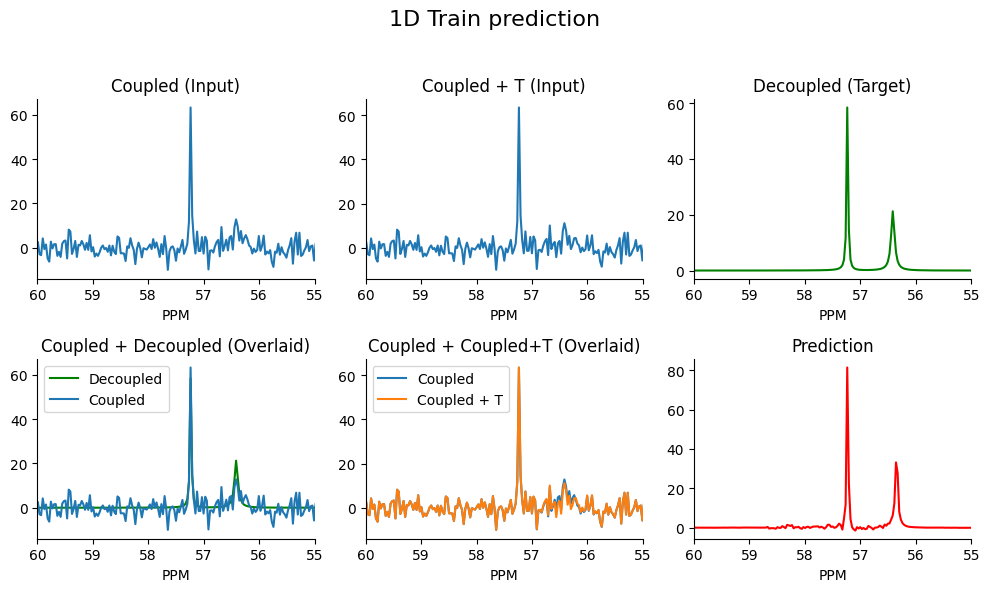






Loading model: saved_model/DecoupleNET_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
DecoupleNET PREDICTION: 
Predicted peak PPM: 57.236328125
Difference between peaks: 0.0


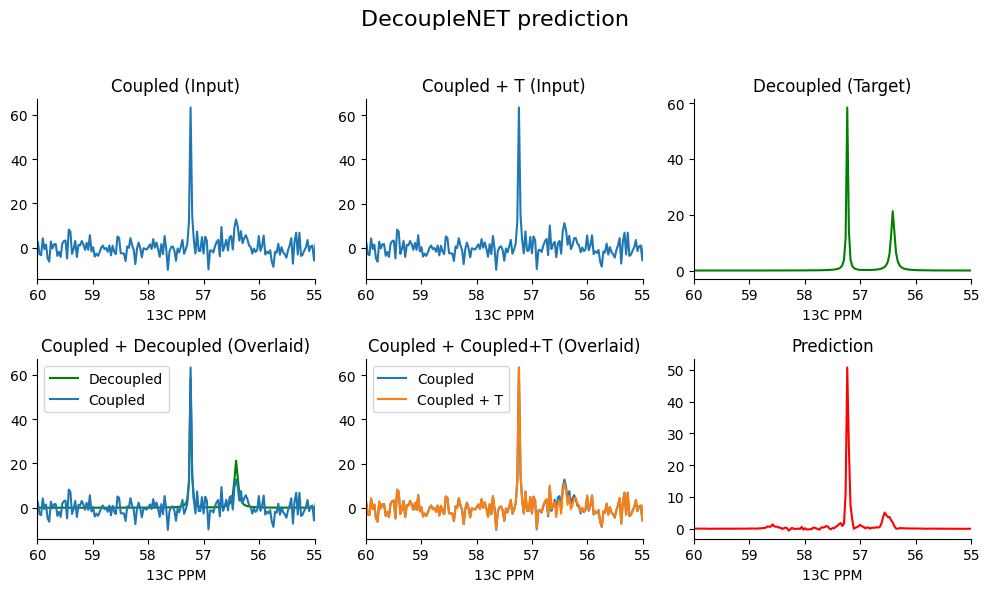






Loading model: saved_model/DecoupleNET_CONV_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
DecoupleNET_conv PREDICTION: 
Predicted peak PPM: 57.236328125
Difference between peaks: 0.0


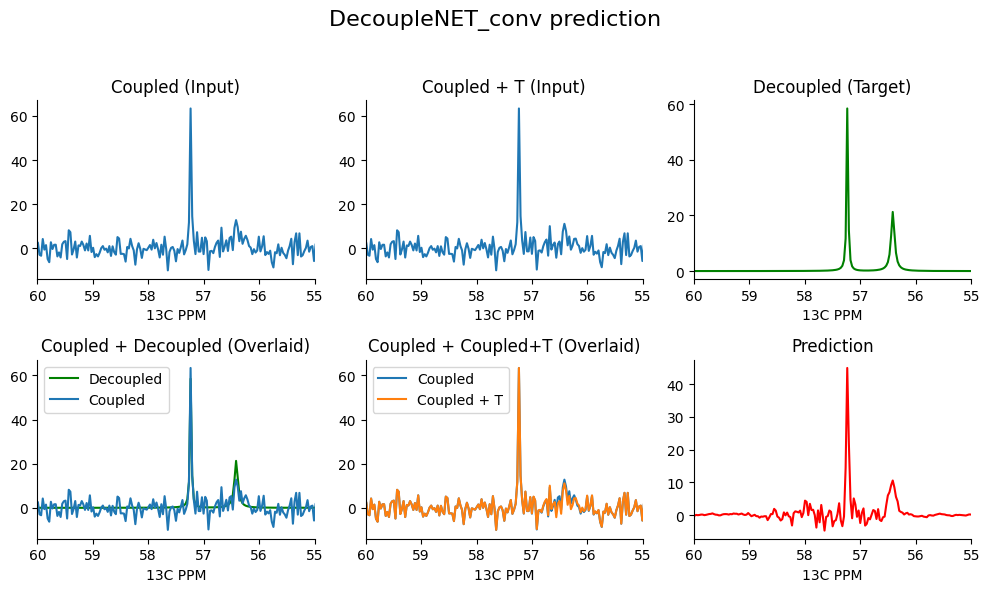







********************************* Verification example 2 *********************************
Number of nuclei / peaks: 3
Parameters for the last peak on the spectrum:
J: 37.93801972832521
A: 0.748860575010226
Omega: 406.2799000885509
Coupling degree: 0


INPUT: 
Peak PPM: 56.5625

Loading model: saved_model/DecoupleNET_1D_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1D Train PREDICTION: 
Predicted peak PPM: 57.822265625
Difference between peaks: 1.259765625


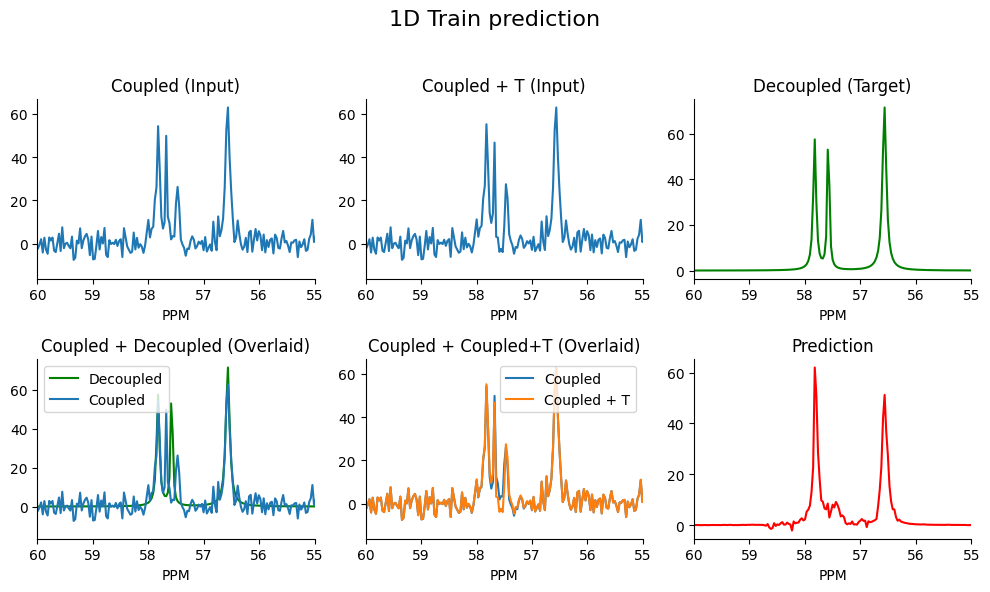






Loading model: saved_model/DecoupleNET_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
DecoupleNET PREDICTION: 
Predicted peak PPM: 57.822265625
Difference between peaks: 1.259765625


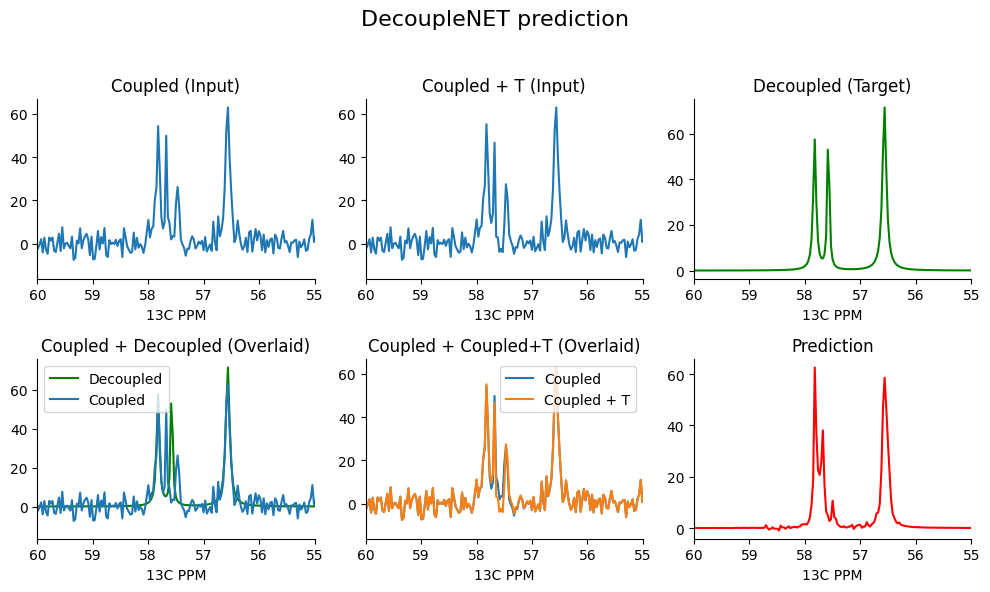






Loading model: saved_model/DecoupleNET_CONV_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
DecoupleNET_conv PREDICTION: 
Predicted peak PPM: 56.5625
Difference between peaks: 0.0


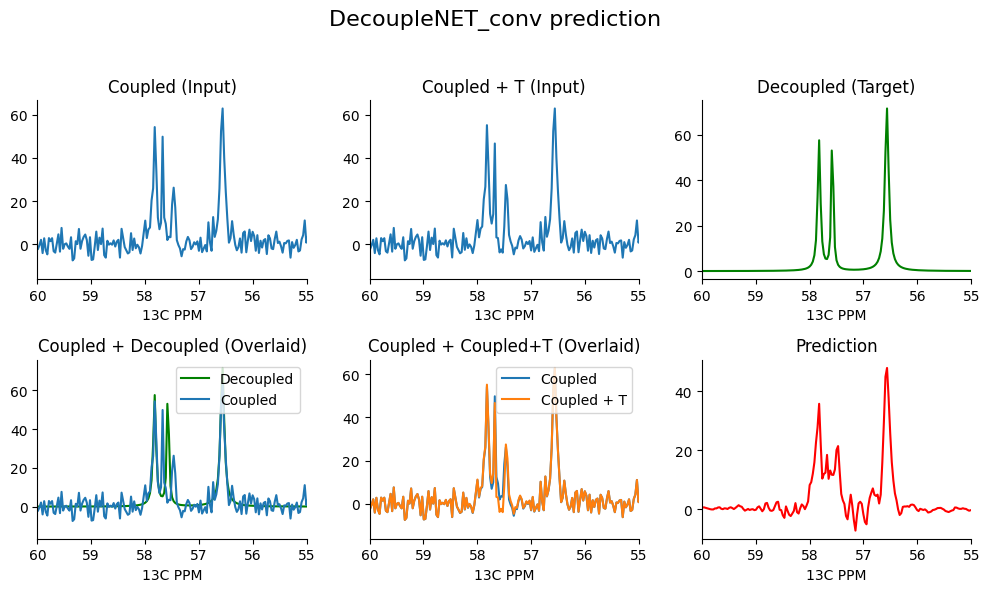







********************************* Verification example 3 *********************************
Number of nuclei / peaks: 1
Parameters for the last peak on the spectrum:
J: 30.859360937315945
A: 0.8579356769060374
Omega: -1385.342340773891
Coupling degree: 1


INPUT: 
Peak PPM: 56.38671875

Loading model: saved_model/DecoupleNET_1D_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1D Train PREDICTION: 
Predicted peak PPM: 56.38671875
Difference between peaks: 0.0


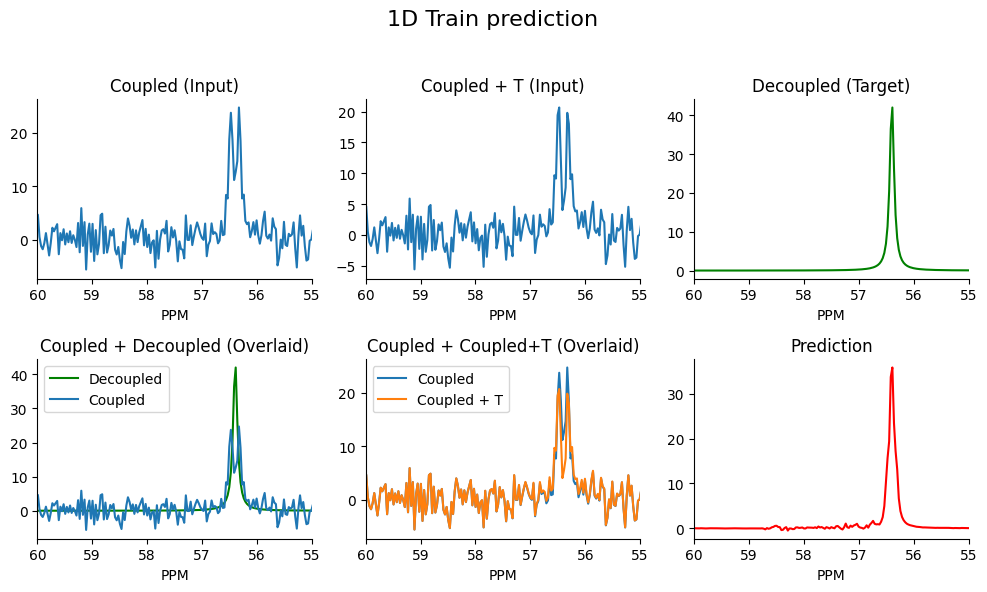






Loading model: saved_model/DecoupleNET_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
DecoupleNET PREDICTION: 
Predicted peak PPM: 56.416015625
Difference between peaks: 0.029296875


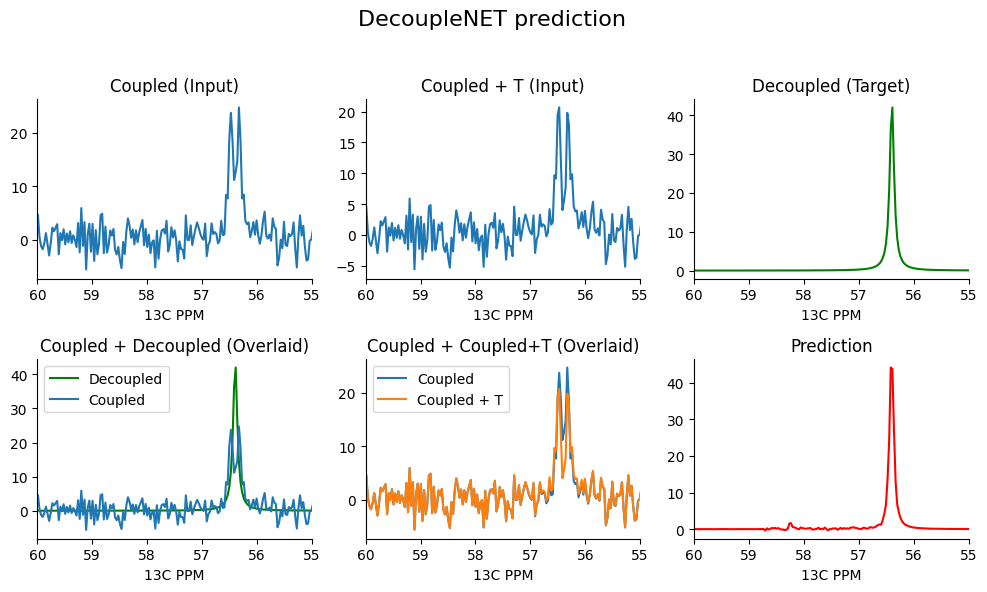






Loading model: saved_model/DecoupleNET_CONV_10k.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
DecoupleNET_conv PREDICTION: 
Predicted peak PPM: 56.38671875
Difference between peaks: 0.0


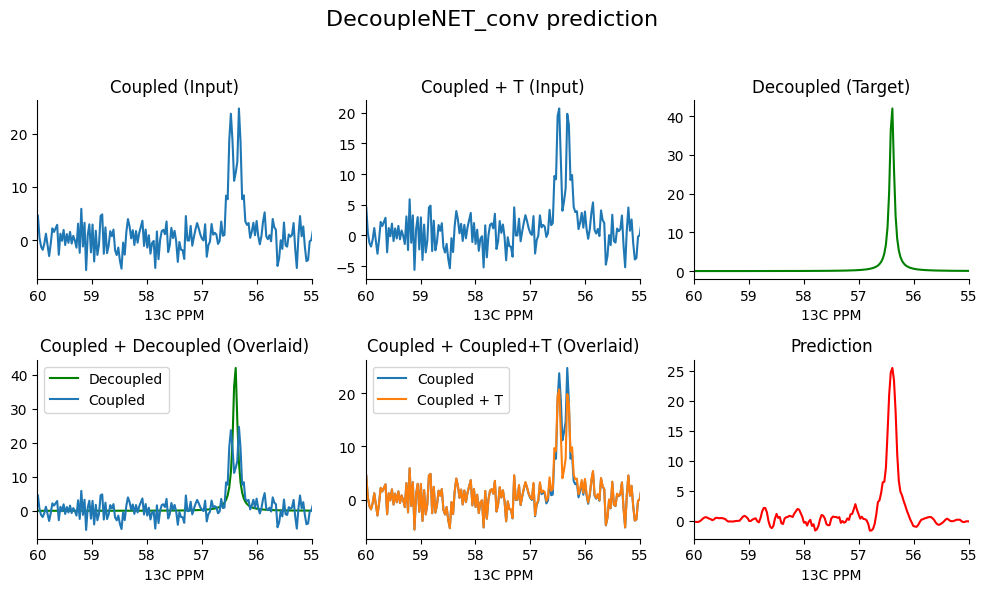

In [24]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    tpi = 2 * np.pi
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = random.randint(self.min_nuclei, self.max_nuclei)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = random.uniform(-self.sweep_width/2, self.sweep_width/2)
            t = np.linspace(0, self.duration, self.points)
            A = self.normal_A()
            while A > 2 or A < 0:
                A = self.normal_A()
            R2 = random.uniform(self.R2_lower, self.R2_upper)
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = random.randint(0, 3)
            J = random.uniform(self.J_lower, self.J_upper)
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

#Function to convert an array in the form [R1, R2, R3, I1, I2, I3] to [R1+I1, R2+I2, R3+I3]
def output_parse(array):
    final_prediction = []
    transpose = int(len(array)/2)
    for i in range(transpose):
        real = array[i]
        imag = array[i+transpose]
        add = complex(real, imag)
        final_prediction.append(add)
    return final_prediction

def gen_FID():
    return minuk_gen_FID()

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

verif_number = input("How many verification examples would you like? ")
for i in range(int(verif_number)):
    print("********************************* Verification example " + str(i + 1) + " *********************************")
    m = gen_FID()
    full_FID = m.out_full_FID
    full_coupled_FID = m.out_coupled_FID
    full_coupled_T_FID = m.out_coupled_T_FID

    spectrum = fftshift(fft(full_FID))
    spectrum2 = fftshift(fft(full_coupled_FID))
    spectrum3 = fftshift(fft(full_coupled_T_FID))
    x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
    ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
    ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

    verify_no_nuclei = m.out_no_nuclei
    verify_J = m.out_J
    verify_A = m.out_A
    verify_omega = m.out_omega
    verify_coupling_degree = m.out_couple_degree

    print("Number of nuclei / peaks: " + str(verify_no_nuclei))
    print("Parameters for the last peak on the spectrum:")
    print("J: " + str(verify_J))
    print("A: " + str(verify_A))
    print("Omega: " + str(verify_omega))
    print("Coupling degree: " + str(verify_coupling_degree))
    print("")
    print("")
    print("INPUT: ")
    print("Peak PPM: " + str(ppm[spectrum.argmax()]))

    #1D TRAIN PREDICTION
    pre_trained_model = "saved_model/DecoupleNET_1D_10k.keras"
    print("")
    print("Loading model: " + str(pre_trained_model))
    model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

    model_input = []
    for j in range(len(full_coupled_FID)):
        model_input.append(full_coupled_FID[j].real)
    for k in range((len(full_coupled_FID))):
        model_input.append(full_coupled_FID[k].imag)
    model_input = np.array(model_input)
    model_input = model_input.reshape(1, -1)
    prediction = model.predict([model_input])
    output = []
    for n in range(len(prediction[0])):
        output.append(prediction[0][n])
    final_output = output_parse(output)
    final_spectrum = fftshift(fft(final_output))

    print("1D Train PREDICTION: ")
    print("Predicted peak PPM: "  + str(ppm[final_spectrum.argmax()]))
    print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle("1D Train prediction", fontsize=16)
    axs[0][0].plot(np.real(ppm), np.real(spectrum2))
    axs[0][0].set_title("Coupled (Input)")
    axs[0][0].set_xlabel("PPM")
    axs[0][1].plot(np.real(ppm), np.real(spectrum3))
    axs[0][1].set_title("Coupled + T (Input)")
    axs[0][1].set_xlabel("PPM")
    axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
    axs[0][2].set_title("Decoupled (Target)")
    axs[0][2].set_xlabel("PPM")
    axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
    axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
    axs[1][0].set_xlabel("PPM")
    axs[1][0].legend()
    axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
    axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
    axs[1][1].set_xlabel("PPM")
    axs[1][1].legend()
    axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
    axs[1][2].set_title("Prediction")
    axs[1][2].set_xlabel("PPM")
    for row in axs:
        for ax in row:
            ax.set_xlim(55, 60)
            ax.invert_xaxis()
            ax.spines["top"].set_visible(False)   
            ax.spines["right"].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print("")
    print("")
    print("")
    print("")

    #DecoupleNET PREDICTION
    pre_trained_model = "saved_model/DecoupleNET_10k.keras"
    print("")
    print("Loading model: " + str(pre_trained_model))
    model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

    model_input_t = []
    for l in range((len(full_coupled_T_FID))):
        model_input_t.append(full_coupled_T_FID[l].real)
    for m in range((len(full_coupled_T_FID))):
        model_input_t.append(full_coupled_T_FID[m].imag)
    model_input_t = np.array(model_input_t)
    model_input_t = model_input_t.reshape(1, -1)
    prediction = model.predict([model_input, model_input_t])
    output = []
    for n in range(len(prediction[0])):
        output.append(prediction[0][n])
    final_output = output_parse(output)
    final_spectrum = fftshift(fft(final_output))

    print("DecoupleNET PREDICTION: ")
    print("Predicted peak PPM: "  + str(ppm[final_spectrum.argmax()]))
    print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle("DecoupleNET prediction", fontsize=16)
    axs[0][0].plot(np.real(ppm), np.real(spectrum2))
    axs[0][0].set_title("Coupled (Input)")
    axs[0][0].set_xlabel("13C PPM")
    axs[0][1].plot(np.real(ppm), np.real(spectrum3))
    axs[0][1].set_title("Coupled + T (Input)")
    axs[0][1].set_xlabel("13C PPM")
    axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
    axs[0][2].set_title("Decoupled (Target)")
    axs[0][2].set_xlabel("13C PPM")
    axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
    axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
    axs[1][0].set_xlabel("13C PPM")
    axs[1][0].legend()
    axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
    axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
    axs[1][1].set_xlabel("13C PPM")
    axs[1][1].legend()
    axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
    axs[1][2].set_title("Prediction")
    axs[1][2].set_xlabel("13C PPM")
    for row in axs:
        for ax in row:
            ax.set_xlim(55, 60)
            ax.invert_xaxis()
            ax.spines["top"].set_visible(False)   
            ax.spines["right"].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print("")
    print("")
    print("")
    print("")

    #DecoupleNET_conv PREDICTION
    pre_trained_model = "saved_model/DecoupleNET_CONV_10k.keras"
    print("")
    print("Loading model: " + str(pre_trained_model))
    model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

    prediction = model.predict([model_input, model_input_t])
    prediction = tf.reshape(prediction, [-1])
    output = np.array(prediction)
    final_output = output_parse(output)
    final_spectrum = fftshift(fft(final_output))

    print("DecoupleNET_conv PREDICTION: ")
    print("Predicted peak PPM: "  + str(ppm[final_spectrum.argmax()]))
    print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    fig.suptitle("DecoupleNET_conv prediction", fontsize=16)
    axs[0][0].plot(np.real(ppm), np.real(spectrum2))
    axs[0][0].set_title("Coupled (Input)")
    axs[0][0].set_xlabel("13C PPM")
    axs[0][1].plot(np.real(ppm), np.real(spectrum3))
    axs[0][1].set_title("Coupled + T (Input)")
    axs[0][1].set_xlabel("13C PPM")
    axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
    axs[0][2].set_title("Decoupled (Target)")
    axs[0][2].set_xlabel("13C PPM")
    axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
    axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
    axs[1][0].set_xlabel("13C PPM")
    axs[1][0].legend()
    axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
    axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
    axs[1][1].set_xlabel("13C PPM")
    axs[1][1].legend()
    axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
    axs[1][2].set_title("Prediction")
    axs[1][2].set_xlabel("13C PPM")
    for row in axs:
        for ax in row:
            ax.set_xlim(55, 60)
            ax.invert_xaxis()
            ax.spines["top"].set_visible(False)   
            ax.spines["right"].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print("")
    print("")
    print("")
    print("")
    print("")
    print("")
        

<a id="big"></a>
### High accuracy model predictions
---

The code block below loads a version of DecoupleNET which has been trained on 100,000 training examples, 10 times more than the other versions of DecoupleNET that have been used in this notebook.

>**This model achieved a validation MSE loss of 0.02523 which is 51.743% better than the version trained on 10,000 examples.**

When this code is run on a Jupyter Notebook the graphs that are generated are not interactive; one cannot zoom into the plots. Therefore I have also written a script called "**23.high_accuracy_predictions.py**" which will be in the same folder as this notebook. This script, when run in an environment that has the required libraries, detailed in the [setup](#setup) section, will generate the same plots but they will be interactive. To make the peaks below easier to see I have limited the x-axis to PPM values between 55-60 which will encompass any peaks with an omega ranging from -1500 to 1500Hz, if the .py file is run instead, the whole sweep width of 3000Hz (50-65ppm) will be visible and one can zoom into the peaks.

The block below will generate the same spectrum as the [user specified section.](#preds_user) The code block below will allow one to generate as many spectra as desired.


Loading model: saved_model/DecoupleNET_100k.keras

Number of nuclei / peaks: 4
Parameters for the last peak on the spectrum:
J: 0
A: 1.1
Omega: 1437
Coupling degree: 0


INPUT: 
Peak PPM: 58.642578125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
PREDICTION: 
Peak PPM: 58.642578125
Difference between peaks: 0.0


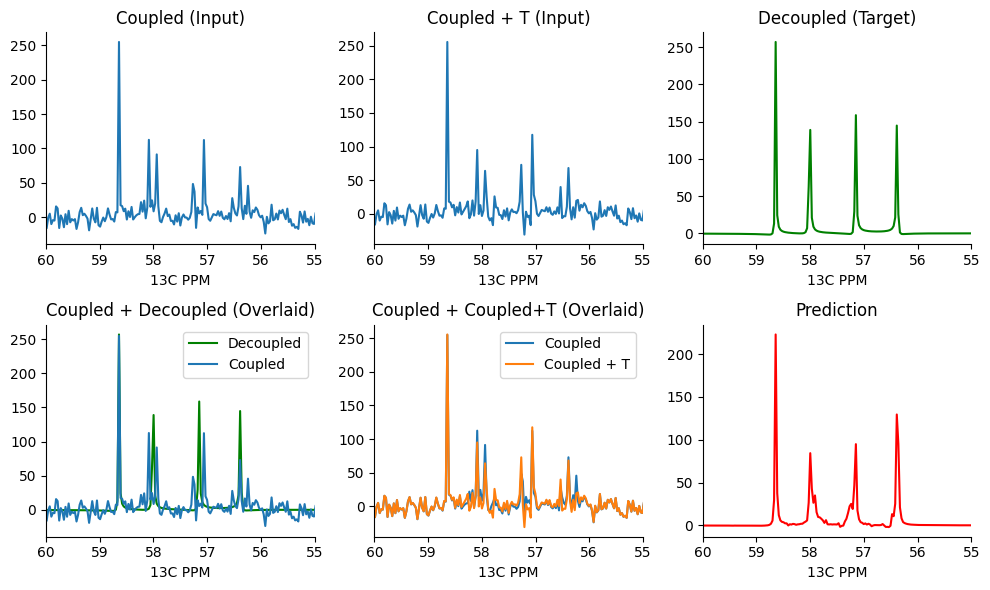

In [25]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        #Adjust the 5 arrays as desired, ensure the length of all 5 arrays are the same.
        #As all of the models were trained on spectra ranging from 1-5 peaks, 
        # it is recommended that the length of the arrays does not exceed 5.
        peak_list =          [-1408, -429, 640, 1437] #Omega values in Hz ranging from -1500 to 1500
        J_list =             [29, 37, 31, 0] #J values in Hz ranging from 28 to 40 
        couple_degree_list = [2, 1, 3, 0] #Coupling degree values ranging from 0 to 3
        A_list =             [0.9, 1, 1.2, 1.1] #A values ranging from >0 to <2
        R2_list =            [10, 10, 10, 10] #R2 values from from 5 to 60
        
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = len(peak_list)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = peak_list[i]
            t = np.linspace(0, self.duration, self.points)
            A = A_list[i]
            R2 = R2_list[i]
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = couple_degree_list[i]
            J = J_list[i]
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            np.random.seed(23)
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_FID_noisy = full_FID + noise
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_full_FID_noisy = full_FID_noisy
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

#Function to convert an array in the form [R1, R2, R3, I1, I2, I3] to [R1+I1, R2+I2, R3+I3]
def output_parse(array):
    final_prediction = []
    transpose = int(len(array)/2)
    for i in range(transpose):
        real = array[i]
        imag = array[i+transpose]
        add = complex(real, imag)
        final_prediction.append(add)
    return final_prediction

def gen_FID():
    return minuk_gen_FID()

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

#DecoupleNET trained on 100,000 examples 
pre_trained_model = "saved_model/DecoupleNET_100k.keras"
print("")
print("Loading model: " + str(pre_trained_model))
print("")
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

m = gen_FID()
full_FID = m.out_full_FID
full_coupled_FID = m.out_coupled_FID
full_coupled_T_FID = m.out_coupled_T_FID

spectrum = fftshift(fft(full_FID))
spectrum2 = fftshift(fft(full_coupled_FID))
spectrum3 = fftshift(fft(full_coupled_T_FID))
x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

verify_no_nuclei = m.out_no_nuclei
verify_J = m.out_J
verify_A = m.out_A
verify_omega = m.out_omega
verify_coupling_degree = m.out_couple_degree

print("Number of nuclei / peaks: " + str(verify_no_nuclei))
print("Parameters for the last peak on the spectrum:")
print("J: " + str(verify_J))
print("A: " + str(verify_A))
print("Omega: " + str(verify_omega))
print("Coupling degree: " + str(verify_coupling_degree))
print("")
print("")
print("INPUT: ")
print("Peak PPM: " + str(ppm[spectrum.argmax()]))

model_input = []
model_input_t = []
for j in range(len(full_coupled_FID)):
    model_input.append(full_coupled_FID[j].real)
for k in range((len(full_coupled_FID))):
    model_input.append(full_coupled_FID[k].imag)
for l in range((len(full_coupled_T_FID))):
    model_input_t.append(full_coupled_T_FID[l].real)
for m in range((len(full_coupled_T_FID))):
    model_input_t.append(full_coupled_T_FID[m].imag)
model_input = np.array(model_input)
model_input_t = np.array(model_input_t)
model_input = model_input.reshape(1, -1)
model_input_t = model_input_t.reshape(1, -1)
prediction = model.predict([model_input, model_input_t])
output = []
for n in range(len(prediction[0])):
    output.append(prediction[0][n])
final_output = output_parse(output)
final_spectrum = fftshift(fft(final_output))

print("PREDICTION: ")
print("Peak PPM: "  + str(ppm[final_spectrum.argmax()]))
print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
fig.canvas.manager.set_window_title("Verification example " + str(int(i+1)))
axs[0][0].plot(np.real(ppm), np.real(spectrum2))
axs[0][0].set_title("Coupled (Input)")
axs[0][0].set_xlabel("13C PPM")
axs[0][1].plot(np.real(ppm), np.real(spectrum3))
axs[0][1].set_title("Coupled + T (Input)")
axs[0][1].set_xlabel("13C PPM")
axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
axs[0][2].set_title("Decoupled (Target)")
axs[0][2].set_xlabel("13C PPM")
axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
axs[1][0].set_xlabel("13C PPM")
axs[1][0].legend()
axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
axs[1][1].set_xlabel("13C PPM")
axs[1][1].legend()
axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
axs[1][2].set_title("Prediction")
axs[1][2].set_xlabel("13C PPM")
for row in axs:
    for ax in row:
        ax.set_xlim(55, 60)
        ax.invert_xaxis()
        ax.spines["top"].set_visible(False)   
        ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

#### Use the code block below to generate as many verification examples as desired.

**NB: When this code block is run, there will be a prompt asking for how many verification examples are desired.**


Loading model: saved_model/DecoupleNET_100k.keras

*************************** Verification example 1 ***************************
Number of nuclei / peaks: 2
J: 33.82469140941358
A: 0.3378532693232932
Omega: -1362.0057954732333
Coupling degree: 2


INPUT: 
Peak PPM: 57.236328125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
PREDICTION: 
Peak PPM: 57.236328125
Difference between peaks: 0.0


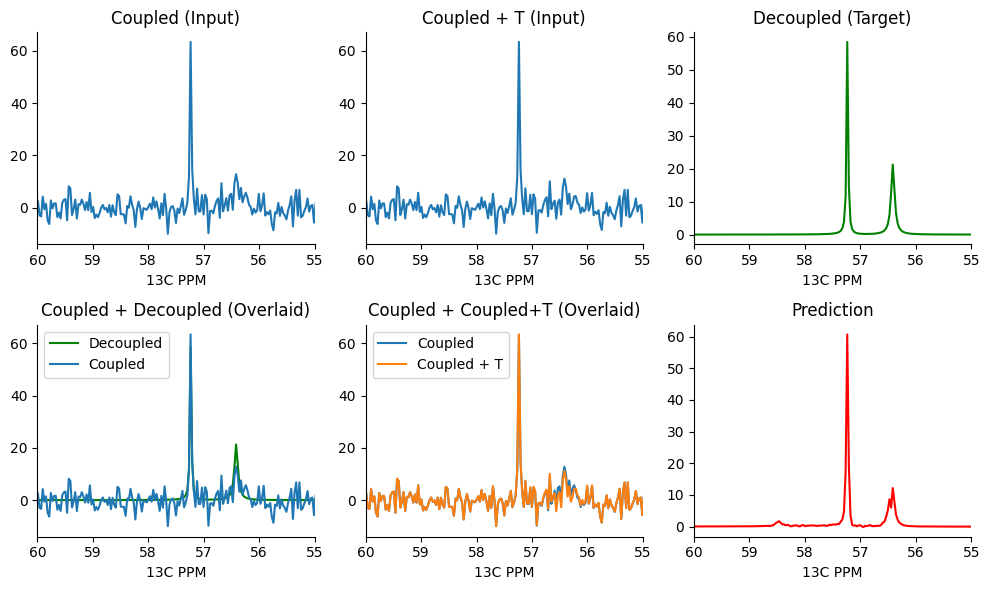



*************************** Verification example 2 ***************************
Number of nuclei / peaks: 3
J: 37.93801972832521
A: 0.748860575010226
Omega: 406.2799000885509
Coupling degree: 0


INPUT: 
Peak PPM: 56.5625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
PREDICTION: 
Peak PPM: 56.5625
Difference between peaks: 0.0


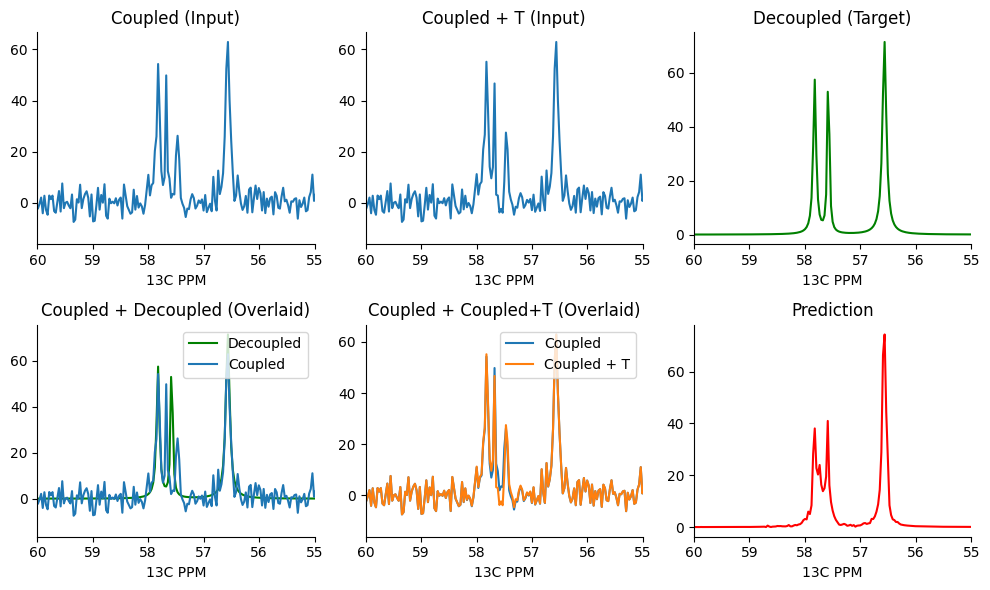



*************************** Verification example 3 ***************************
Number of nuclei / peaks: 1
J: 30.859360937315945
A: 0.8579356769060374
Omega: -1385.342340773891
Coupling degree: 1


INPUT: 
Peak PPM: 56.38671875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
PREDICTION: 
Peak PPM: 56.38671875
Difference between peaks: 0.0


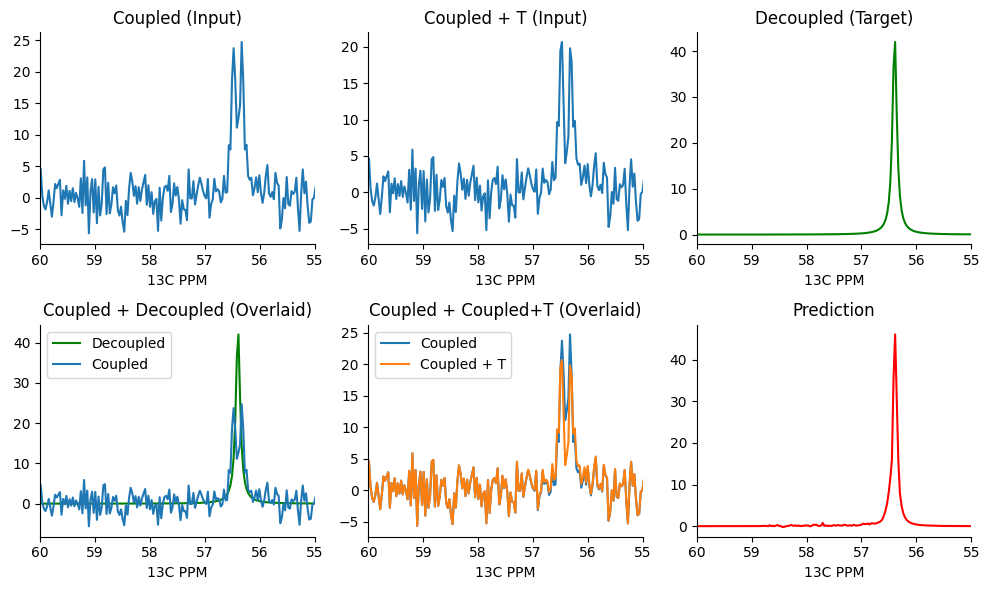



*************************** Verification example 4 ***************************
Number of nuclei / peaks: 1
J: 30.76223020515927
A: 0.859307753543737
Omega: 1007.541583685866
Coupling degree: 2


INPUT: 
Peak PPM: 58.291015625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
PREDICTION: 
Peak PPM: 58.291015625
Difference between peaks: 0.0


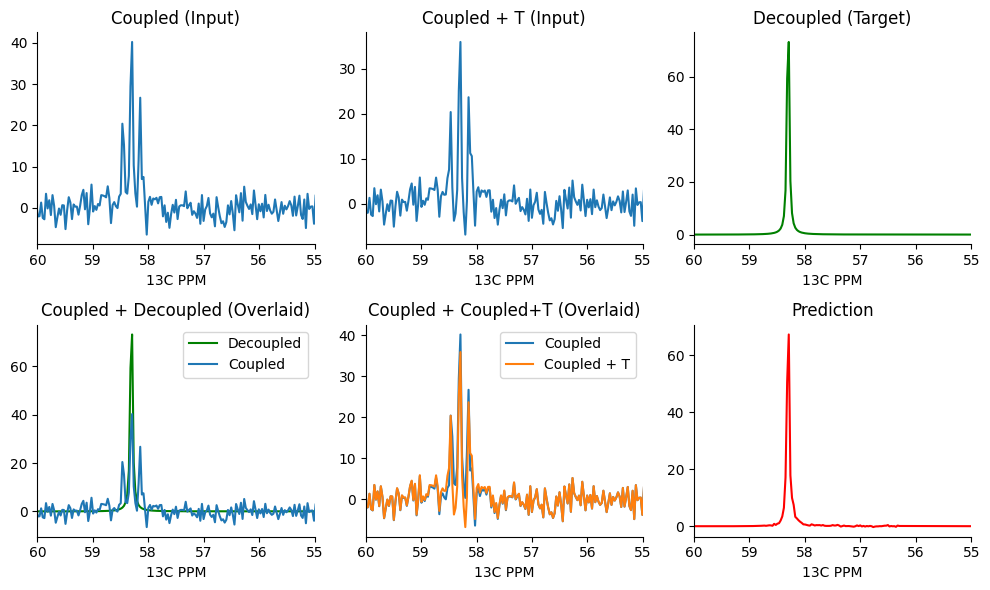



*************************** Verification example 5 ***************************
Number of nuclei / peaks: 3
J: 39.08327798351325
A: 0.15137646791470616
Omega: 958.2890341979842
Coupling degree: 2


INPUT: 
Peak PPM: 56.416015625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
PREDICTION: 
Peak PPM: 56.416015625
Difference between peaks: 0.0


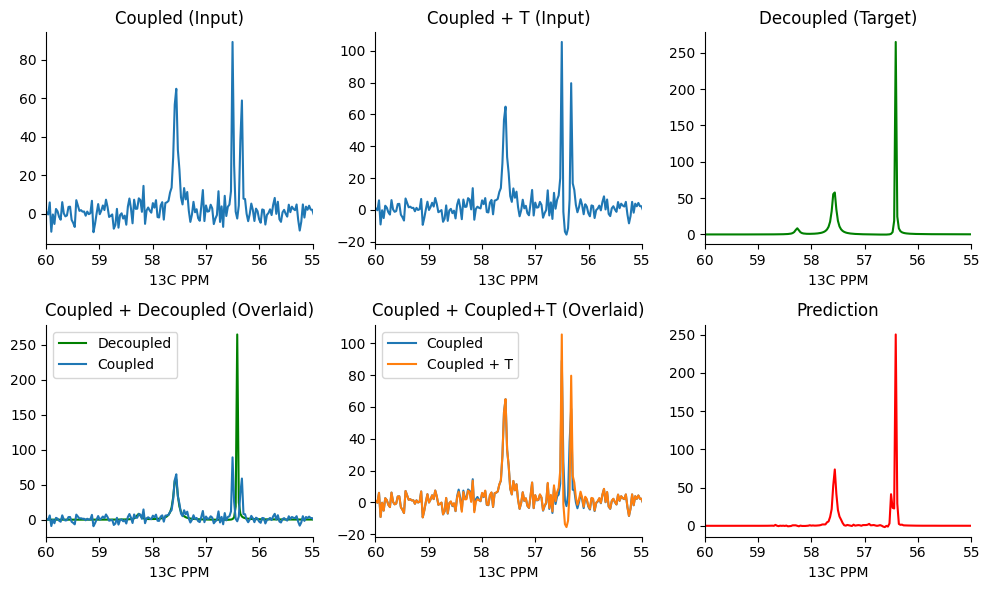



*************************** Verification example 6 ***************************
Number of nuclei / peaks: 4
J: 28.09058736196731
A: 0.8562926863457659
Omega: -338.19001164425185
Coupling degree: 1


INPUT: 
Peak PPM: 57.353515625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
PREDICTION: 
Peak PPM: 57.353515625
Difference between peaks: 0.0


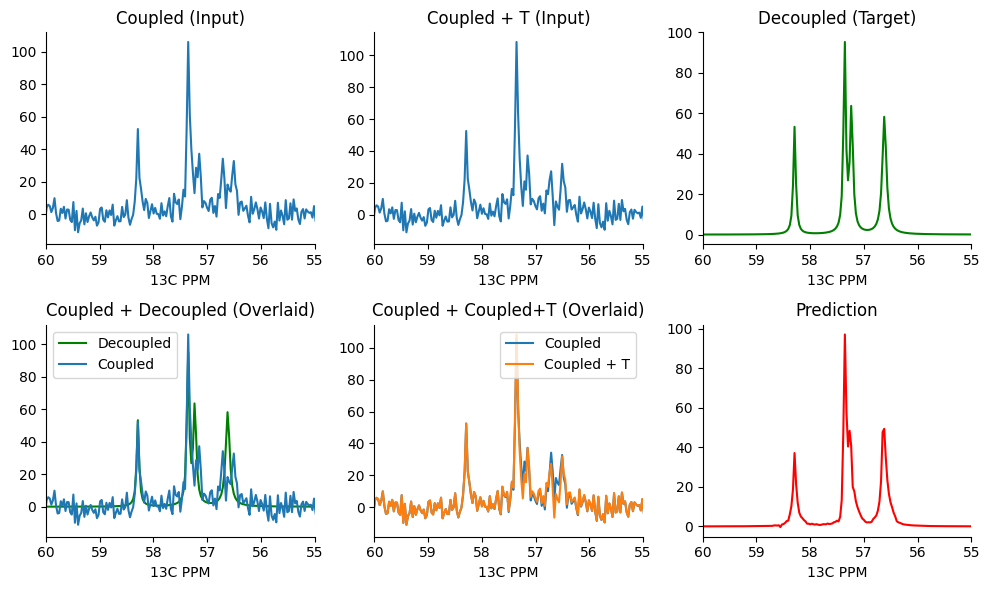



*************************** Verification example 7 ***************************
Number of nuclei / peaks: 1
J: 29.56022946867154
A: 0.7017681873877081
Omega: 407.3336532106041
Coupling degree: 1


INPUT: 
Peak PPM: 57.822265625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
PREDICTION: 
Peak PPM: 57.822265625
Difference between peaks: 0.0


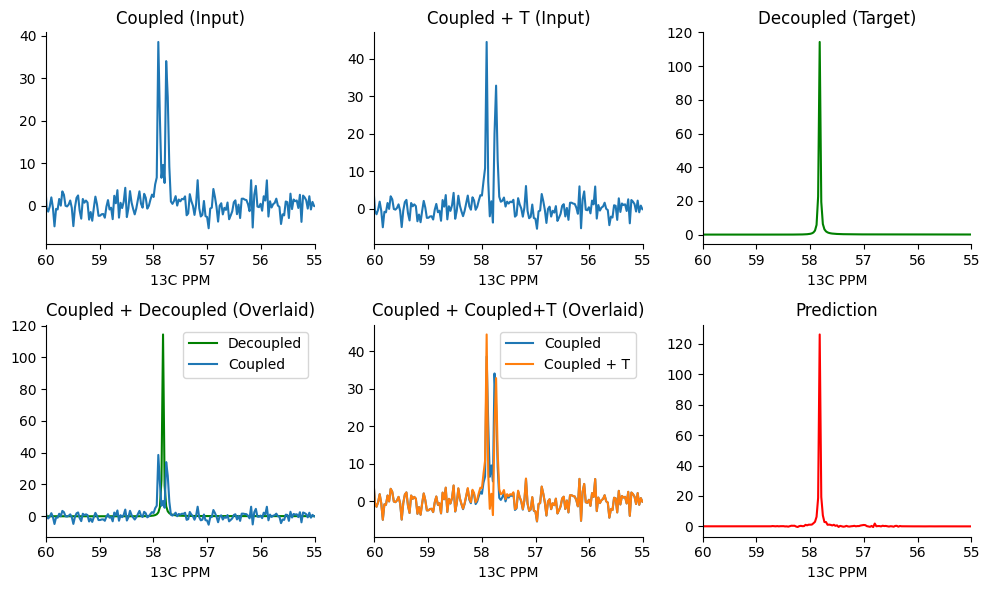



*************************** Verification example 8 ***************************
Number of nuclei / peaks: 3
J: 38.14258370573414
A: 1.7550675692988862
Omega: 363.9247710940542
Coupling degree: 2


INPUT: 
Peak PPM: 57.79296875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
PREDICTION: 
Peak PPM: 57.587890625
Difference between peaks: 0.205078125


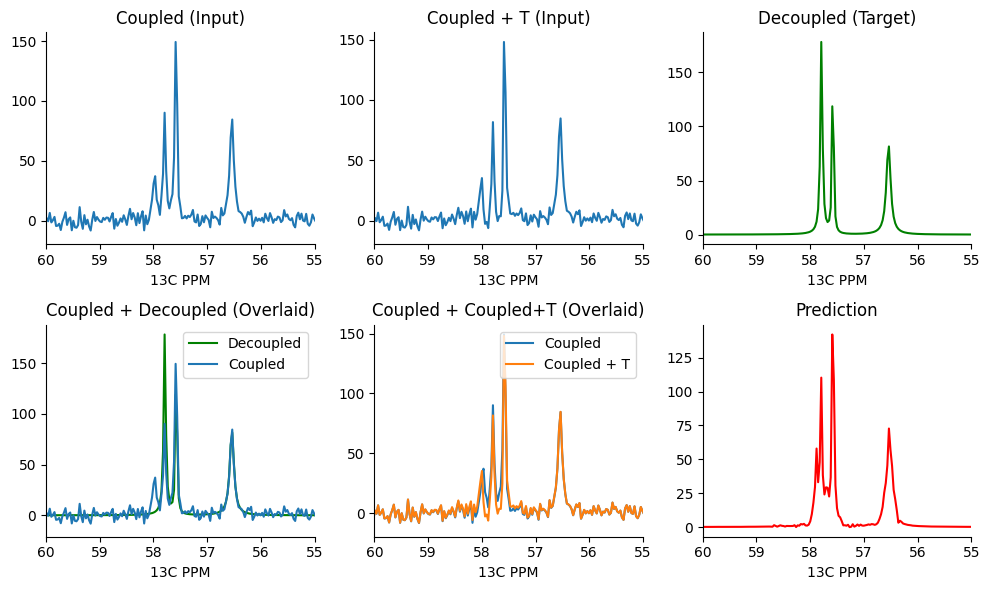



*************************** Verification example 9 ***************************
Number of nuclei / peaks: 1
J: 31.18645897842958
A: 0.6995618166162423
Omega: 273.8830507168375
Coupling degree: 2


INPUT: 
Peak PPM: 57.705078125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
PREDICTION: 
Peak PPM: 57.705078125
Difference between peaks: 0.0


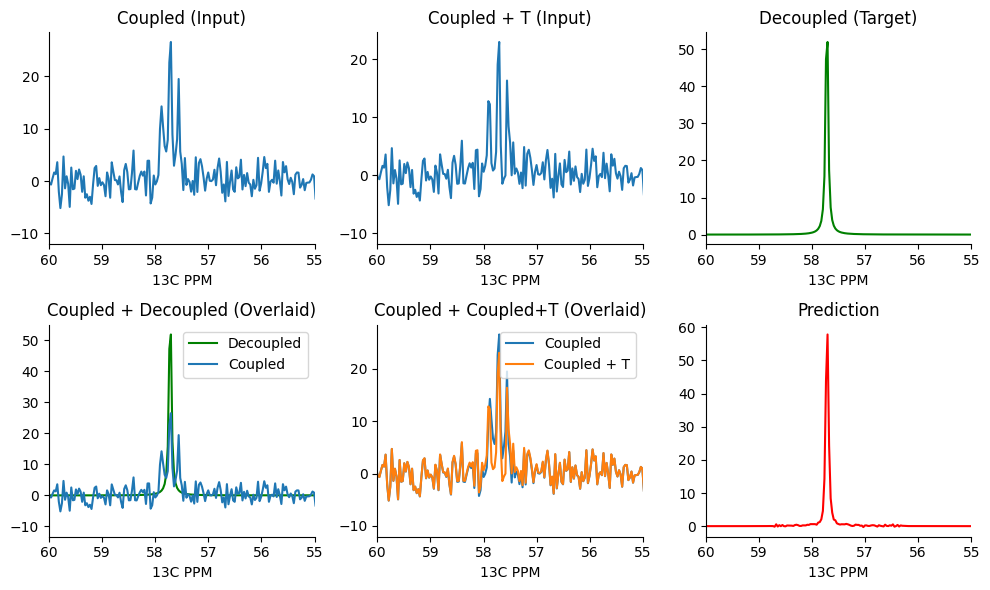



*************************** Verification example 10 ***************************
Number of nuclei / peaks: 4
J: 28.404726001420038
A: 0.763403235382788
Omega: 1030.3111180500296
Coupling degree: 0


INPUT: 
Peak PPM: 58.525390625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
PREDICTION: 
Peak PPM: 58.4375
Difference between peaks: 0.087890625


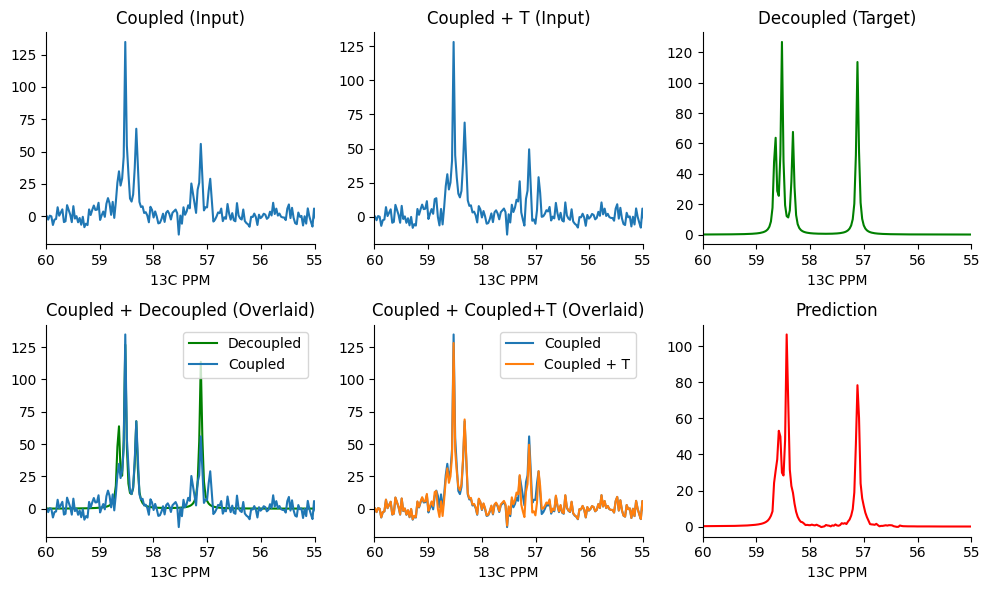



*************************** Verification example 11 ***************************
Number of nuclei / peaks: 2
J: 37.532315087342994
A: 1.1235685206781987
Omega: 406.91010992531415
Coupling degree: 0


INPUT: 
Peak PPM: 57.822265625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
PREDICTION: 
Peak PPM: 57.822265625
Difference between peaks: 0.0


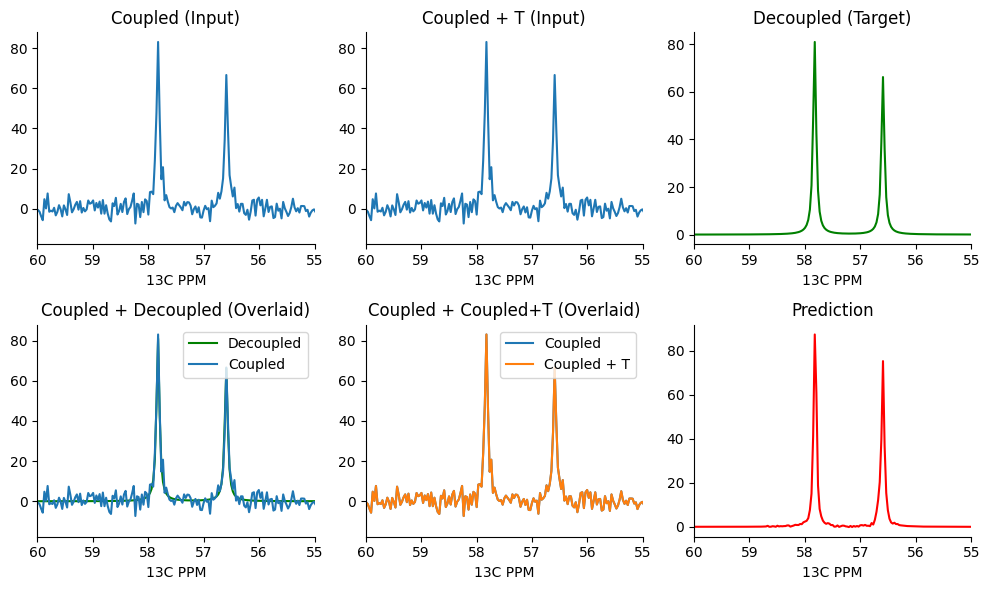



*************************** Verification example 12 ***************************
Number of nuclei / peaks: 1
J: 33.02106383925931
A: 1.0822832933694726
Omega: 1290.4154136876182
Coupling degree: 2


INPUT: 
Peak PPM: 58.525390625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
PREDICTION: 
Peak PPM: 58.525390625
Difference between peaks: 0.0


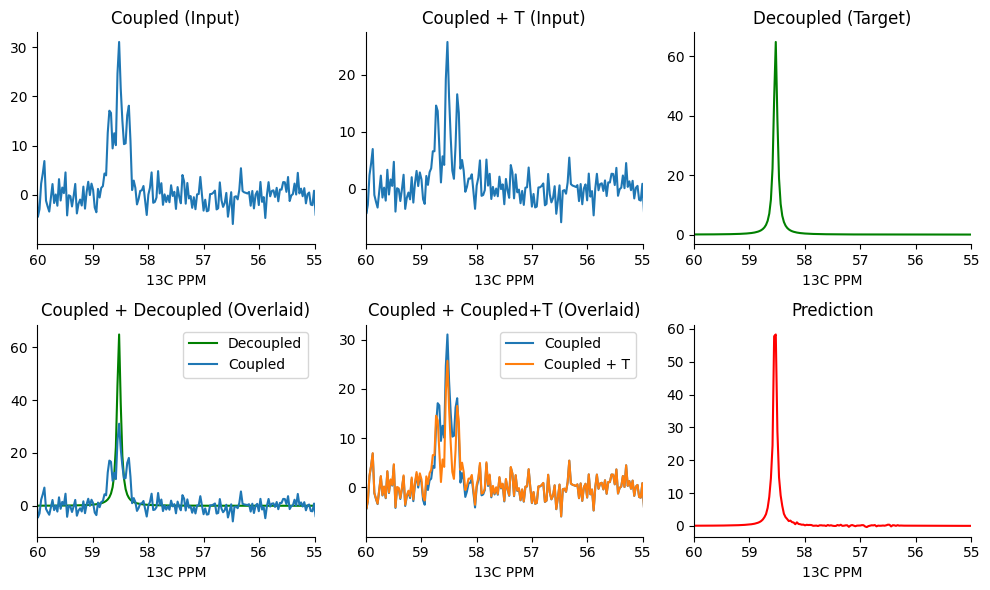



*************************** Verification example 13 ***************************
Number of nuclei / peaks: 3
J: 39.8598646475482
A: 0.3247524388962
Omega: -285.40557728536464
Coupling degree: 1


INPUT: 
Peak PPM: 56.6796875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
PREDICTION: 
Peak PPM: 56.6796875
Difference between peaks: 0.0


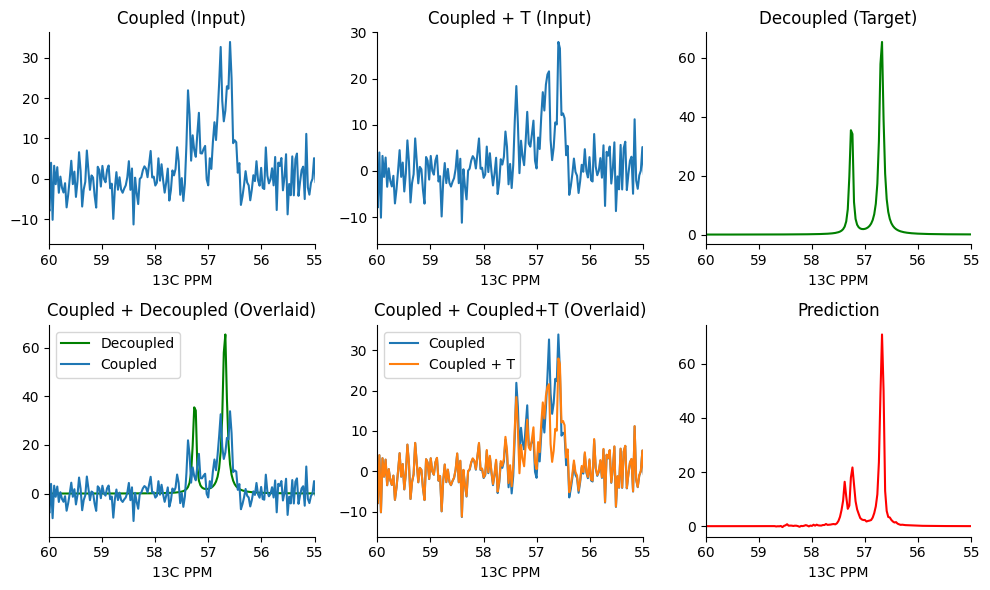



*************************** Verification example 14 ***************************
Number of nuclei / peaks: 2
J: 36.813769100749646
A: 0.599891322676883
Omega: -616.148689872461
Coupling degree: 1


INPUT: 
Peak PPM: 57.001953125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
PREDICTION: 
Peak PPM: 57.001953125
Difference between peaks: 0.0


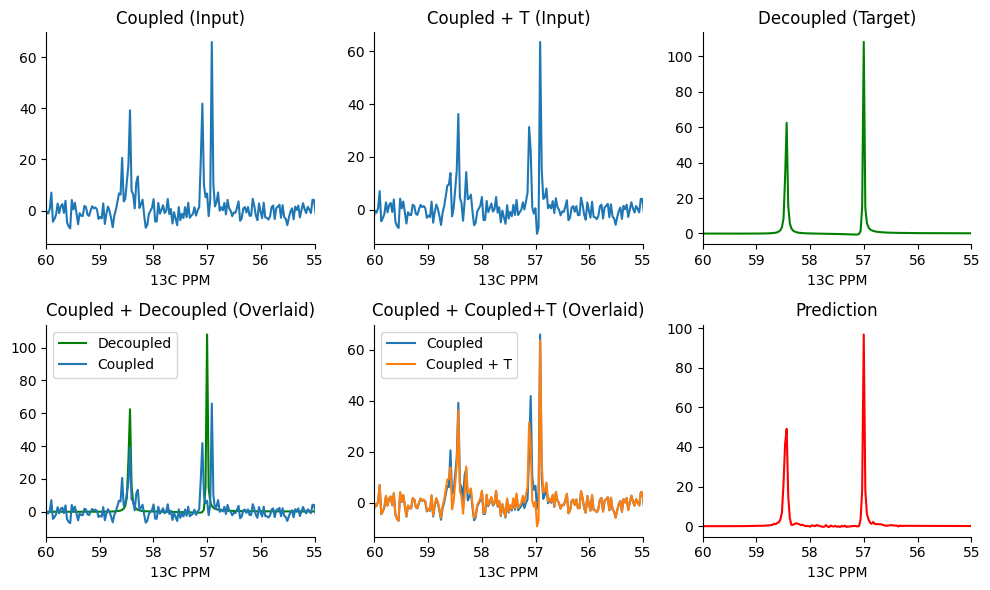



*************************** Verification example 15 ***************************
Number of nuclei / peaks: 1
J: 29.463113666163565
A: 0.4969504637807236
Omega: 53.84339993207095
Coupling degree: 0


INPUT: 
Peak PPM: 57.529296875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
PREDICTION: 
Peak PPM: 57.529296875
Difference between peaks: 0.0


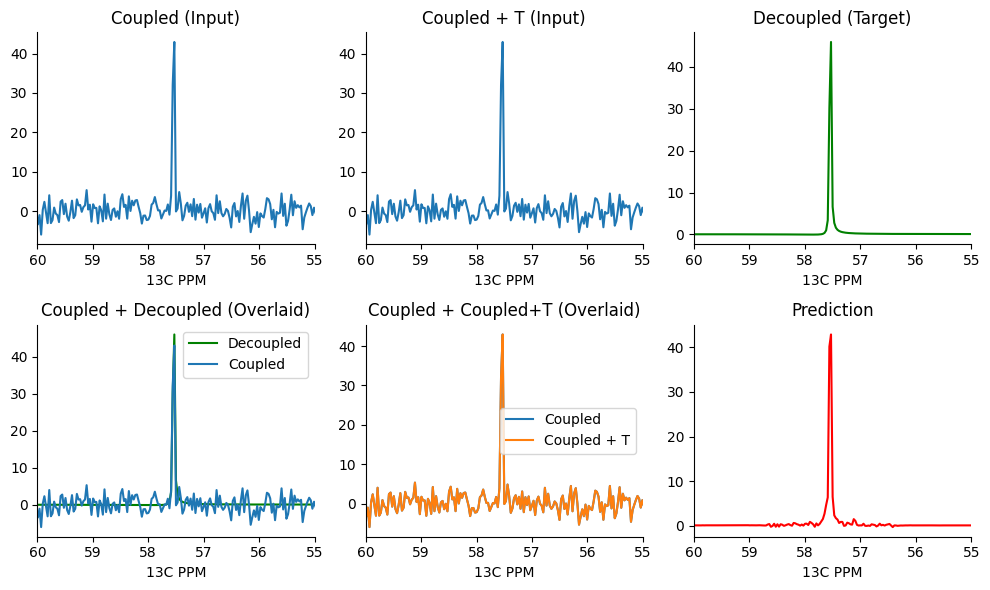

In [26]:
class minuk_gen_FID:
    #Spectra parameters
    R2_upper = 60.
    R2_lower = 5.
    A_mean = 1.
    A_SD = 0.5
    points = 512
    tpi = 2 * np.pi
    magnet_strength_hz = 800 * 10**6 #In Hz
    reference_frequency = magnet_strength_hz * (1/4) #Because C13 NMR
    ppm_upper = 65            
    ppm_lower = 50
    sweep_width = (ppm_upper - ppm_lower) * (reference_frequency / 10**6) # = 3000
    duration = points / sweep_width # = 0.1706 
    J_upper = 40
    J_lower = 28
    max_nuclei = 5
    min_nuclei = 1 
    time_period = 0.0035
    noise_magnitude = 0.1

    def normal_A(self):
        return random.normal(loc=self.A_mean, scale=self.A_SD)
    
    def __init__(self):
        J = 0
        A = 1
        omega = 0
        couple_degree = 0
        number_of_nuclei = random.randint(self.min_nuclei, self.max_nuclei)
        full_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_FID = np.zeros(self.points, dtype="complex_")
        full_coupled_T_FID = np.zeros(self.points, dtype="complex_")
        for i in range(number_of_nuclei):    
            omega = random.uniform(-self.sweep_width/2, self.sweep_width/2)
            t = np.linspace(0, self.duration, self.points)
            A = self.normal_A()
            while A > 2 or A < 0:
                A = self.normal_A()
            R2 = random.uniform(self.R2_lower, self.R2_upper)
            FID = A * np.exp(1j * t * omega - R2 * t)
            FID[0] = FID[0] / 2
            coupled_FID = FID
            coupled_T_FID = FID
            couple_degree = random.randint(0, 3)
            J = random.uniform(self.J_lower, self.J_upper)
            coupled_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            t += self.time_period
            coupled_T_FID = FID * (np.cos(np.pi * J * t))**couple_degree
            noise_real = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise_imag = random.normal(loc=0, scale=self.noise_magnitude, size=self.points)
            noise = noise_real + 1j * noise_imag
            full_FID = full_FID + FID
            full_coupled_FID = full_coupled_FID + coupled_FID + noise
            full_coupled_T_FID = full_coupled_T_FID + coupled_T_FID + noise

        self.out_full_FID = full_FID
        self.out_coupled_FID = full_coupled_FID
        self.out_coupled_T_FID = full_coupled_T_FID
        self.out_omega = omega
        self.out_couple_degree = couple_degree
        self.out_J = J
        self.out_A = A
        self.out_no_nuclei = number_of_nuclei

#Function to convert an array in the form [R1, R2, R3, I1, I2, I3] to [R1+I1, R2+I2, R3+I3]
def output_parse(array):
    final_prediction = []
    transpose = int(len(array)/2)
    for i in range(transpose):
        real = array[i]
        imag = array[i+transpose]
        add = complex(real, imag)
        final_prediction.append(add)
    return final_prediction

def gen_FID():
    return minuk_gen_FID()

def rmsd(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

#DecoupleNET trained on 100,000 examples 
pre_trained_model = "saved_model/DecoupleNET_100k.keras"
print("")
print("Loading model: " + str(pre_trained_model))
print("")
model = tf.keras.models.load_model(pre_trained_model, custom_objects={"rmsd": rmsd})

verif_number = input("How many verification examples would you like? ")
for i in range(int(verif_number)):
    print("*************************** Verification example " + str(i + 1) + " ***************************")
    m = gen_FID()
    full_FID = m.out_full_FID
    full_coupled_FID = m.out_coupled_FID
    full_coupled_T_FID = m.out_coupled_T_FID
    
    spectrum = fftshift(fft(full_FID))
    spectrum2 = fftshift(fft(full_coupled_FID))
    spectrum3 = fftshift(fft(full_coupled_T_FID))
    x_axis = fftshift(fftfreq(minuk_gen_FID.points, minuk_gen_FID.duration / minuk_gen_FID.points))
    ppm_center = (minuk_gen_FID.ppm_lower + minuk_gen_FID.ppm_upper) / 2
    ppm = ((x_axis) / (minuk_gen_FID.reference_frequency / 10**6)) + ppm_center

    verify_no_nuclei = m.out_no_nuclei
    verify_J = m.out_J
    verify_A = m.out_A
    verify_omega = m.out_omega
    verify_coupling_degree = m.out_couple_degree
    
    print("Number of nuclei / peaks: " + str(verify_no_nuclei))
    print("J: " + str(verify_J))
    print("A: " + str(verify_A))
    print("Omega: " + str(verify_omega))
    print("Coupling degree: " + str(verify_coupling_degree))
    print("")
    print("")
    print("INPUT: ")
    print("Peak PPM: " + str(ppm[spectrum.argmax()]))

    model_input = []
    model_input_t = []
    for j in range(len(full_coupled_FID)):
        model_input.append(full_coupled_FID[j].real)
    for k in range((len(full_coupled_FID))):
        model_input.append(full_coupled_FID[k].imag)
    for l in range((len(full_coupled_T_FID))):
        model_input_t.append(full_coupled_T_FID[l].real)
    for m in range((len(full_coupled_T_FID))):
        model_input_t.append(full_coupled_T_FID[m].imag)
    model_input = np.array(model_input)
    model_input_t = np.array(model_input_t)
    model_input = model_input.reshape(1, -1)
    model_input_t = model_input_t.reshape(1, -1)
    prediction = model.predict([model_input, model_input_t])
    output = []
    for n in range(len(prediction[0])):
        output.append(prediction[0][n])
    final_output = output_parse(output)
    final_spectrum = fftshift(fft(final_output))

    print("PREDICTION: ")
    print("Peak PPM: "  + str(ppm[final_spectrum.argmax()]))
    print("Difference between peaks: " + str(np.abs((ppm[final_spectrum.argmax()]) - (ppm[spectrum.argmax()]))))
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    fig.canvas.manager.set_window_title("Verification example " + str(int(i+1)))
    axs[0][0].plot(np.real(ppm), np.real(spectrum2))
    axs[0][0].set_title("Coupled (Input)")
    axs[0][0].set_xlabel("13C PPM")
    axs[0][1].plot(np.real(ppm), np.real(spectrum3))
    axs[0][1].set_title("Coupled + T (Input)")
    axs[0][1].set_xlabel("13C PPM")
    axs[0][2].plot(np.real(ppm), np.real(spectrum), color="green")
    axs[0][2].set_title("Decoupled (Target)")
    axs[0][2].set_xlabel("13C PPM")
    axs[1][0].plot(np.real(ppm), np.real(spectrum), label="Decoupled", color="green")
    axs[1][0].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][0].set_title("Coupled + Decoupled (Overlaid)")
    axs[1][0].set_xlabel("13C PPM")
    axs[1][0].legend()
    axs[1][1].plot(np.real(ppm), np.real(spectrum2), label="Coupled")
    axs[1][1].plot(np.real(ppm), np.real(spectrum3), label="Coupled + T")
    axs[1][1].set_title("Coupled + Coupled+T (Overlaid)")
    axs[1][1].set_xlabel("13C PPM")
    axs[1][1].legend()
    axs[1][2].plot(np.real(ppm), np.real(final_spectrum), color="red")
    axs[1][2].set_title("Prediction")
    axs[1][2].set_xlabel("13C PPM")
    for row in axs:
        for ax in row:
            ax.set_xlim(55, 60)
            ax.invert_xaxis()
            ax.spines["top"].set_visible(False)   
            ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()
    print("")
    print("")